# Define configurations

In [ ]:
user = 'participant1'
frequency = '15s`' # 15min | 15s
dataset_type = '' # ''

if frequency == '15min':
    record_size_per_day = 96
elif frequency == '15s':
    record_size_per_day = 5760

# Columns to include    
if dataset_type == '':
    columns = [ 'timestamp', 'heart_rate', 'steps', 'stress_score',
            'awake', 'deep', 'light', 'rem', 'nonrem_total', 'total', 'nonrem_percentage', 'sleep_efficiency',
            'time_from_last_drug_taken', 'wearing_off' ]

metrics = {
    'balanced_accuracy': 'Bal. Acc.',
    'f1_score': 'F1 Score',
    'accuracy': 'Acc.',
    'precision': 'Precision',
    'sensitivity': 'Recall / Sn',
    'specificity': 'Sp',
    'auc': 'AUC'
}

# Preparation

## Load libraries

In [2]:
from datetime import datetime
from datetime import timedelta
from typing import Union, Generator

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib.patches import Patch
import warnings
from sklearn.exceptions import UndefinedMetricWarning, ConvergenceWarning

import sklearn
from photonai.base import Hyperpipe, PipelineElement, Stack, Switch
from photonai.optimization import FloatRange, IntegerRange, Categorical, BooleanSwitch, PhotonHyperparam
from photonai.optimization import Categorical as PhotonCategorical
from photonai.optimization import MinimumPerformanceConstraint, DummyPerformanceConstraint, BestPerformanceConstraint
from photonai.optimization.base_optimizer import PhotonSlaveOptimizer
from sklearn.model_selection import KFold, StratifiedKFold, TimeSeriesSplit, StratifiedShuffleSplit
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import LinearSVC
from sklearn.model_selection import cross_val_score
from sklearn.metrics import confusion_matrix
from tabulate import tabulate

from skopt import Optimizer
from skopt.space import Real, Integer, Dimension
from skopt.space import Categorical as skoptCategorical
from photonai.photonlogger.logger import logger
from photonai.optimization.scikit_optimize.sk_opt import SkOptOptimizer

warnings.filterwarnings("ignore", category=UndefinedMetricWarning)
warnings.filterwarnings("ignore", category=ConvergenceWarning)
warnings.filterwarnings("ignore", category=Warning)
from photonai.base import Hyperpipe
from photonai.optimization import MinimumPerformanceConstraint
from photonai.photonlogger import logger 

## Load combined data

In [3]:
combined_data = pd.read_excel(f'./data/combined_data/{dataset_type}combined_data_{user}_{frequency}.xlsx',
                              index_col="timestamp",
                              usecols=columns,
                              engine='openpyxl')
if dataset_type == '':
    y = combined_data.loc[:, combined_data.columns == 'wearing_off'].values[:,0]
    X = combined_data.loc[:, columns[1:-1]]

## Define Functions

In [4]:
# Show feature importances
def print_feature_importances(pipeline):
    output = ''
    if pipeline.optimum_pipe.feature_importances_ is None:
        output = 'Best Hyperparameter Configuration is a non-linear SVM, thus feature importances cannot be retrieved'
    else:
        output = 'Feature Importances using the Best Hyperparameter Config'
        if not [value.base_element.support_.tolist() for key, value in pipeline.optimum_pipe.elements if key == 'RFE']:
            if len(pipeline.optimum_pipe.feature_importances_) == 1:
                feature_importances = pipeline.optimum_pipe.feature_importances_[0]
            else:
                feature_importances = pipeline.optimum_pipe.feature_importances_
            output += '\n'
            output += tabulate(
                pd.DataFrame(
                    [np.around(feature_importances, decimals=4)],
                    columns=np.array(columns[1:-1])
                ).transpose().sort_values(by=[0], ascending=False, key=abs),
                tablefmt='psql', floatfmt=".4f", headers=['Features', 'Values']
            )
        else:
            mask = [value.base_element.support_.tolist() for key, value in pipeline.optimum_pipe.elements if key == 'RFE'][0]
            if len(pipeline.optimum_pipe.feature_importances_) == 1:
                feature_importances = pipeline.optimum_pipe.feature_importances_[0]
            else:
                feature_importances = pipeline.optimum_pipe.feature_importances_
            output += '\n'
            output += tabulate(
                pd.DataFrame(
                    [np.around(feature_importances, decimals=4)],
                    columns=np.array(columns[1:-1])[mask]
                ).transpose().sort_values(by=[0], ascending=False, key=abs),
                tablefmt='psql', floatfmt=".4f", headers=['Features', 'Values']
            )
    return output

In [5]:
def plot_cv_indices(cv, X, y, ax, n_splits=0, lw=20):
    """Create a sample plot for indices of a cross-validation object."""

    # Generate the training/testing visualizations for each CV split
    for ii, (tr, tt) in enumerate(cv.split(X=X, y=y)):
        # Fill in indices with the training/test groups
        indices = np.array([np.nan] * len(X))
        indices[tt] = 1
        indices[tr] = 0

        # Visualize the results
        ax.scatter(range(len(indices)), [ii + .5] * len(indices),
                    c=indices, marker='_', lw=lw, cmap=plt.cm.coolwarm,
                    vmin=-.2, vmax=1.2)

    n_splits = ii + 1

    # Plot the data classes and groups at the end
    ax.scatter(range(len(X)), [ii + 1.5] * len(X), c=y, marker='_', lw=lw, cmap=plt.cm.Paired)

    # Formatting
    yticklabels = list(range(n_splits)) + ['wearing-off']
    ax.set(yticks=np.arange(n_splits+1) + .5, yticklabels=yticklabels,
           xlabel='Records\'s Index', ylabel="Folds",
           ylim=[n_splits+1.2, -.2], xlim=[0, len(X)])
    ax.set_title('{}'.format(type(cv).__name__), fontsize=15)
    return ax


In [6]:
def plot_confusion_matrix_from_pipeline(pipeline):
    fig, ax = plt.subplots(figsize=(10, 10))
    cm = confusion_matrix(
        pipeline.results_handler.get_test_predictions()['y_true'],
        pipeline.results_handler.get_test_predictions()['y_pred'],
        labels=[0,1], normalize=None)
    ax = plt.subplot()
    sns.set(font_scale=3.0) # Adjust to fit
    sns.heatmap(cm, annot=True, ax=ax, cmap="Blues", fmt="g");  

    # Labels, title and ticks
    label_font = {'size':'25'}  # Adjust to fit
    ax.set_xlabel('Predicted labels', fontdict=label_font);
    ax.set_ylabel('Observed labels', fontdict=label_font);

    # title_font = {'size':'21'}  # Adjust to fit
    # ax.set_title('Confusion Matrix', fontdict=title_font);

    ax.tick_params(axis='both', which='major', labelsize=25)  # Adjust to fit
    ax.xaxis.set_ticklabels(['Good', 'Wearing-Off']);
    ax.yaxis.set_ticklabels(['Good', 'Wearing-Off']);
    plt.rc('text') # , usetex=False)
    plt.rc('font', family='serif')
    # plt.savefig('./participant2-downsampling-confusionmatrix-real.pdf', bbox_inches='tight')
    plt.show()

In [7]:
# Write other reports to summary file
def add_other_report_to_summary(pipeline, with_estimator_comparison=True):
    with open(f'{pipeline.output_settings.results_folder}/photon_summary.txt', "a+") as summary_file:
        # 1. Write comparison of learning algorithms
        if with_estimator_comparison:
            summary_file.write("\n\n")
            summary_file.write("Comparison on learning algorithms on validation set")
            summary_file.write("\n")
            summary_file.write(str(pipeline.results_handler.get_mean_of_best_validation_configs_per_estimator()))

        # 2. Write feature importance
        summary_file.write("\n\n")
        summary_file.write("Feature Importance")
        summary_file.write(print_feature_importances(pipeline))
        
        # 3. Write beautified average test performance across outer folds
        # a. Get Average Test Performance Across Outer Folds
        test_metric_result = pipeline.results.get_test_metric_dict()
        
        # b. Replace display metric name
        #   Reference: https://stackoverflow.com/a/55250496/2303766
        test_metric_result = { metrics[metric]: test_metric_result[metric]
                                  for metric, metric_name in metrics.items() if metric in test_metric_result
                             }
        
        # c. Add beautified average test performance across outer folds to file 
        summary_file.write("\n\n")
        summary_file.write("Average Test Performance Across Outer Folds")
        summary_file.write("\n")
        summary_file.write(
            tabulate(
                pd.DataFrame(
                    test_metric_result
                ).round(4).transpose(),
                tablefmt='psql', floatfmt=".4f", headers='keys'
            )
        )
        
        # 4. Write outer fold results
        summary_file.write("\n\n")
        summary_file.write("Outer Fold Best Estimators' Performance")
        summary_file.write("\n")
        handler = pipeline.results_handler
        performance_table = handler.get_performance_table()
        with pd.option_context('display.max_rows', None, 'display.max_columns', None):
            summary_file.write(
                tabulate(
                    performance_table.loc[:, ['fold', 'best_config', 'n_train', 'n_validation']].transpose(),
                    tablefmt='psql', headers='keys'
                )
            )
            summary_file.write("\n")
            summary_file.write(
                tabulate(
                    performance_table.loc[:, ['fold'] + list(metrics.keys())].round(4).transpose(),
                    tablefmt='psql', floatfmt=".4f", headers='keys'
                )
            )
            
        outer_fold_performance = {}
        config_evals = handler.get_config_evaluations()
        for metric in metrics.keys():
            # print(f'{metric}')
            for i, j in enumerate(config_evals[metric]):
                if f'{metric}_mean' in outer_fold_performance:
                    # outer_fold_performance[f'{metric}_max'].append(np.max(j))
                    outer_fold_performance[f'{metric}_mean'].append(np.mean(j))
                    outer_fold_performance[f'{metric}_std'].append(np.std(j))
                else:
                    # outer_fold_performance[f'{metric}_max'] = [np.max(j)]
                    outer_fold_performance[f'{metric}_mean'] = [np.mean(j)]
                    outer_fold_performance[f'{metric}_std'] = [np.std(j)]
        summary_file.write("\n")
        summary_file.write(
            tabulate(
                pd.DataFrame(outer_fold_performance).round(4).transpose(),
                tablefmt='psql', floatfmt=".4f", headers='keys'
            )
        )

In [8]:
# PhotonAI Optimize Monkey-patch
#     Added random_state for Optimize for result replicability
def prepare(self, pipeline_elements: list, maximize_metric: bool) -> None:
    """
    Initializes hyperparameter search with scikit-optimize.

    Assembles all hyperparameters of the list of PipelineElements
    in order to prepare the hyperparameter space.
    Hyperparameters can be accessed via pipe_element.hyperparameters.

    Parameters:
        pipeline_elements:
            List of all PipelineElements to create the hyperparameter space.

        maximize_metric:
            Boolean to distinguish between score and error.

    """
    self.start_time = None
    self.optimizer = None
    self.hyperparameter_list = []
    self.maximize_metric = maximize_metric

    # build skopt space
    space = []
    for pipe_element in pipeline_elements:
        if pipe_element.__class__.__name__ == 'Switch':
            error_msg = 'Scikit-Optimize cannot operate in the specified hyperparameter space with a Switch ' \
                        'element. We recommend the use of SMAC.'
            logger.error(error_msg)
            raise ValueError(error_msg)

        if hasattr(pipe_element, 'hyperparameters'):
            for name, value in pipe_element.hyperparameters.items():
                # if we only have one value we do not need to optimize
                if isinstance(value, list) and len(value) < 2:
                    self.constant_dictionary[name] = value[0]
                    continue
                if isinstance(value, PhotonCategorical) and len(value.values) < 2:
                    self.constant_dictionary[name] = value.values[0]
                    continue
                skopt_param = self._convert_photonai_to_skopt_space(value, name)
                if skopt_param is not None:
                    space.append(skopt_param)

    if self.constant_dictionary:
        msg = "PHOTONAI has detected some one-valued params in your hyperparameters. Pleas use the kwargs for " \
              "constant values. This run ignores following settings: " + str(self.constant_dictionary.keys())
        logger.warning(msg)
        warnings.warn(msg)

    if len(space) == 0:
        msg = "Did not find any hyperparameter to convert into skopt space."
        logger.warning(msg)
        warnings.warn(msg)
    else:
        self.optimizer = Optimizer(space,
                                   base_estimator=self.base_estimator,
                                   n_initial_points=self.n_initial_points,
                                   initial_point_generator=self.initial_point_generator,
                                   acq_func=self.acq_func,
                                   acq_func_kwargs=self.acq_func_kwargs,
                                   random_state=4
                                  )
    self.ask = self.ask_generator()
    
#    Monkey patched new prepare function
SkOptOptimizer.prepare = prepare

## Visualize Data Split

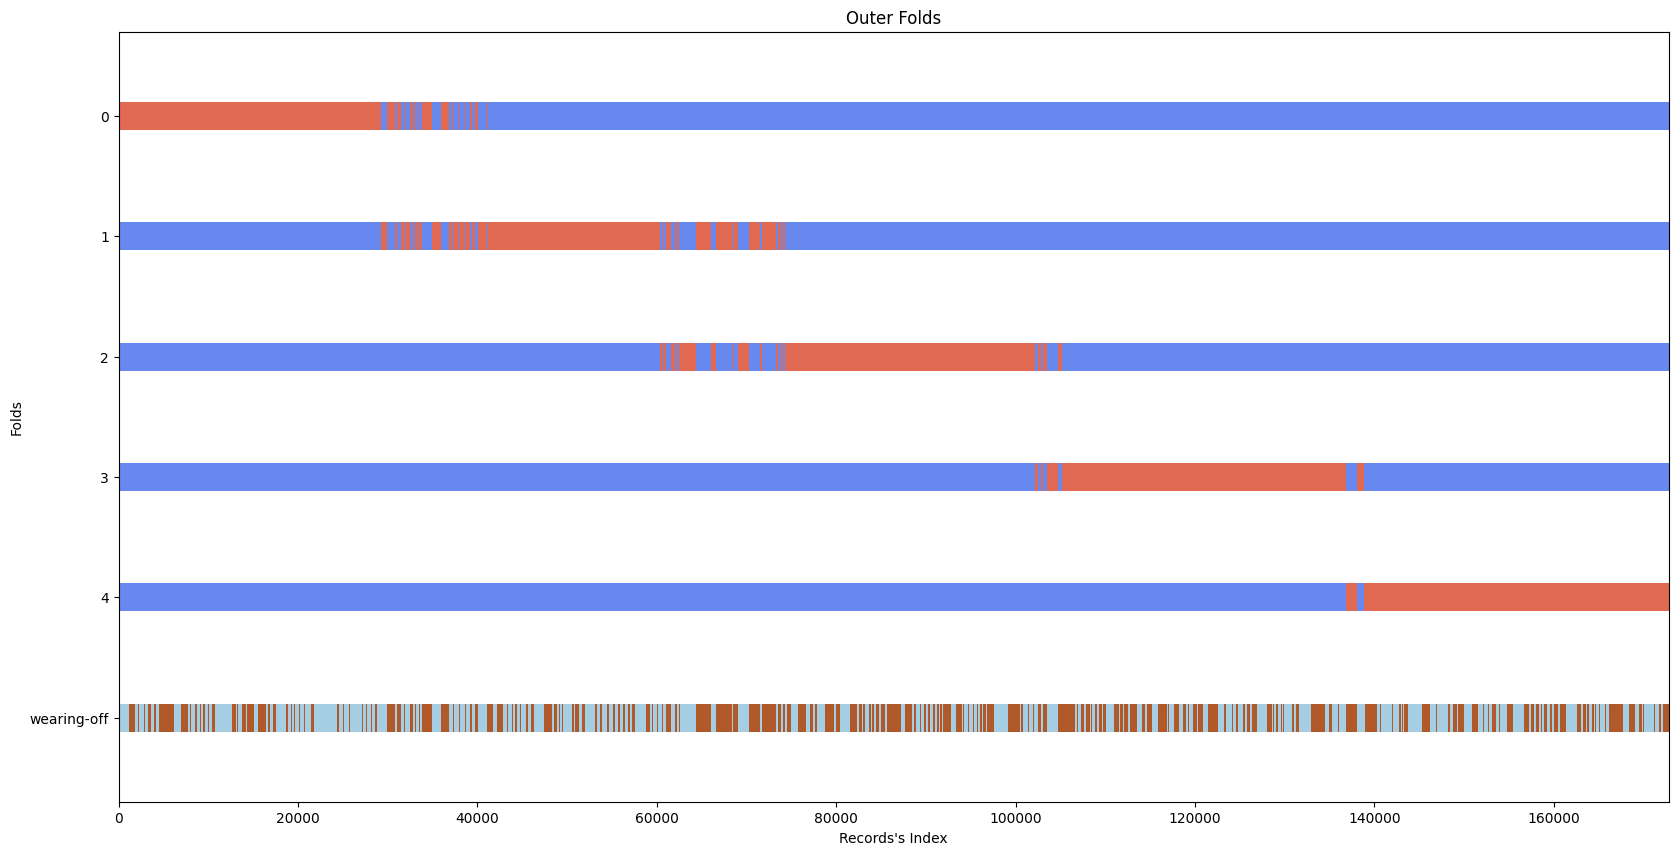

Train Set for Outer Fold 0
[ 29737  29738  29739 ... 172797 172798 172799]

Train Set for Outer Fold 1
[     0      1      2 ... 172797 172798 172799]

Train Set for Outer Fold 2
[     0      1      2 ... 172797 172798 172799]

Train Set for Outer Fold 3
[     0      1      2 ... 172797 172798 172799]

Train Set for Outer Fold 4
[     0      1      2 ... 139339 139340 139341]



In [9]:
# Outer CV
fig, ax = plt.subplots(figsize=(20,10))
cv = StratifiedKFold(n_splits=5, shuffle=False)
plot_cv_indices(cv, X, y, ax)
plt.rc('text') # , usetex=False)
plt.rc('font', family='serif')
plt.title('Outer Folds')
# Save as file
# plt.savefig('./blockingtimeseriessplit.pdf', bbox_inches='tight')
plt.show()

training_folds = []
for train, test in cv.split(X, y):
    print(f'Train Set for Outer Fold {len(training_folds)}')
    print(train)
    training_folds.append(train)
    # print("Test")
    # print(test[0], test[-1])
    print()

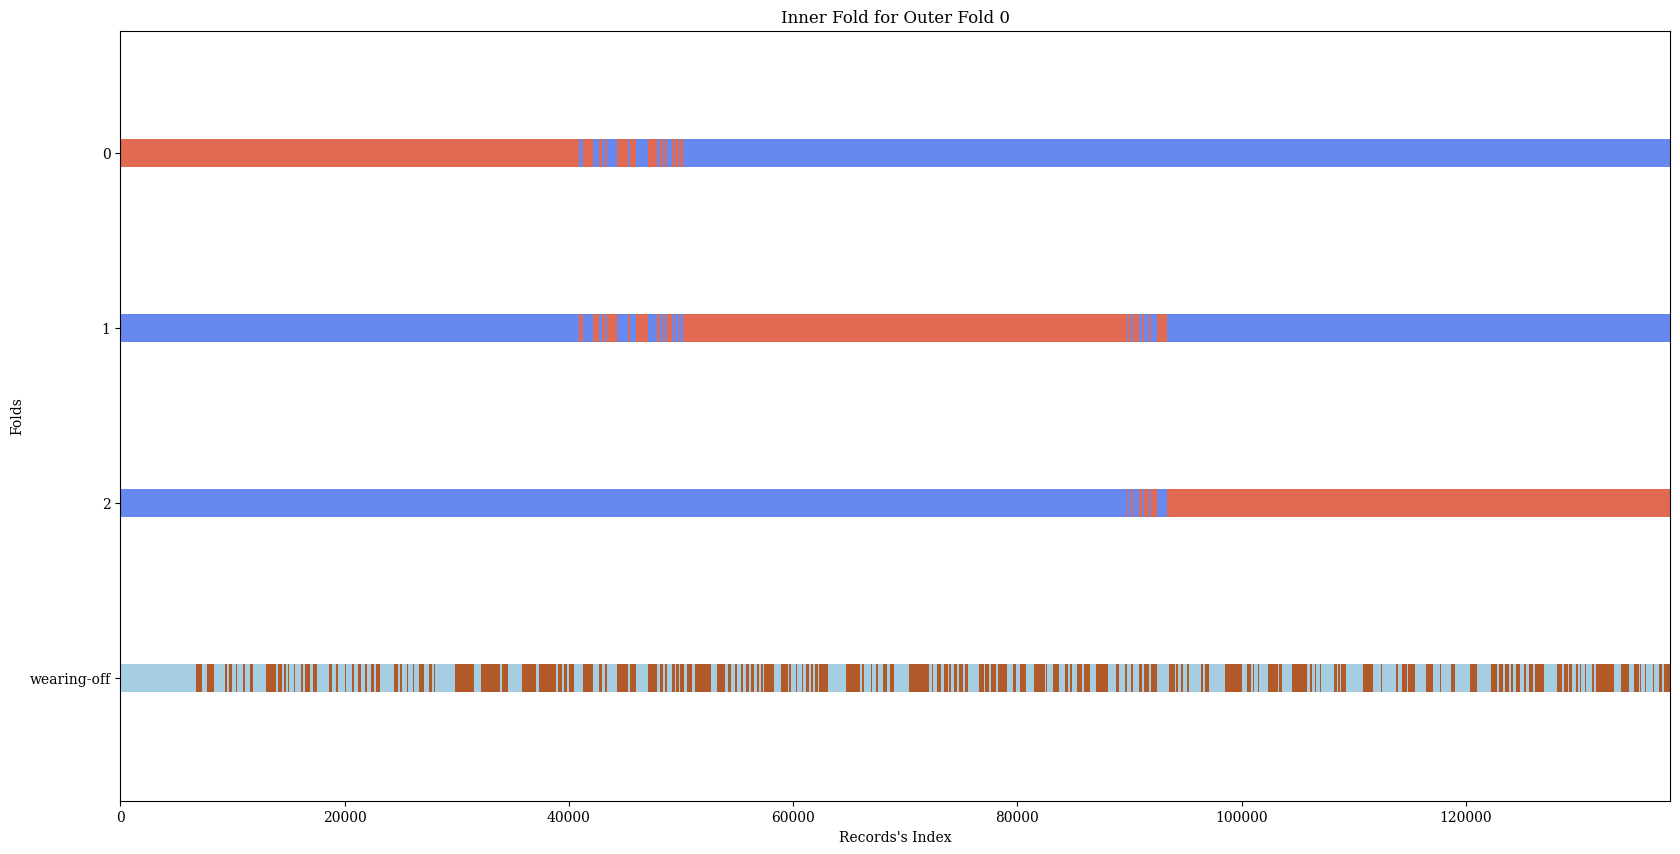

Train Sets for Outer Fold 0
Train Set for Inner Fold 0
[ 41295  41296  41297 ... 138237 138238 138239]

Train Set for Inner Fold 1
[     0      1      2 ... 138237 138238 138239]

Train Set for Inner Fold 2
[    0     1     2 ... 93712 93713 93714]



In [10]:
# Inner CV
outer_fold_number = 0

cmap_data = plt.cm.Paired
cmap_cv = plt.cm.coolwarm
fig, ax = plt.subplots(figsize=(20,10))
cv = StratifiedKFold(n_splits=3, shuffle=False)
plot_cv_indices(cv, X.iloc[training_folds[outer_fold_number]], y[training_folds[outer_fold_number]], ax)
plt.rc('text') # , usetex=False)
plt.rc('font', family='serif')
plt.title(f'Inner Fold for Outer Fold {outer_fold_number}')
# Save as file
# plt.savefig('./blockingtimeseriessplit.pdf', bbox_inches='tight')
plt.show()

inner_training_folds = []
print(f'Train Sets for Outer Fold {outer_fold_number}')
for train, test in cv.split(X.iloc[training_folds[outer_fold_number]], y[training_folds[outer_fold_number]]):
    print(f'Train Set for Inner Fold {len(inner_training_folds)}')
    print(train)
    inner_training_folds.append(train)
    # print("Test")
    # print(test[0], test[-1])
    print()

# Pipeline

## Define learning algorithms

In [11]:
estimator_selection = Switch('estimators')
estimator_selection += PipelineElement("LogisticRegression",
                           hyperparameters={
                               'C': FloatRange(1, 10)
                           }, class_weight='balanced', random_state=4)
estimator_selection += PipelineElement("DecisionTreeClassifier",
                           hyperparameters={
                               'min_samples_split': IntegerRange(2,30),
                               'min_samples_leaf': IntegerRange(2,30)
                           }, random_state=4, criterion='gini')
estimator_selection += PipelineElement('LinearSVC',
                            hyperparameters={
                                'C': FloatRange(1, 25)
                            }, class_weight='balanced', random_state=4)
estimator_selection += PipelineElement('RandomForestClassifier', 
                            hyperparameters={
                                'min_samples_split': IntegerRange(2,30),
                                'max_features': ['auto', 'sqrt', 'log2']
                            }, random_state=4, criterion='gini', bootstrap=True)
estimator_selection += PipelineElement('GradientBoostingClassifier', 
                            hyperparameters={
                                'loss': ['deviance', 'exponential'],
                                'learning_rate': FloatRange(0.001, 1, 'logspace')
                            }, random_state=4)

## Initial Pipeline

In [12]:
initial_pipeline = Hyperpipe('1 - Initial Pipeline',
                     outer_cv = StratifiedKFold(n_splits=5, shuffle=False),
                     inner_cv = StratifiedKFold(n_splits=3, shuffle=False),
                     use_test_set = False,
                     metrics = list(metrics.keys()),
                     best_config_metric='balanced_accuracy',
                     optimizer='switch',
                     optimizer_params={'name': 'sk_opt', 'n_configurations': 30},
                     project_folder=f'./analysis/{dataset_type}{user}_{frequency}',
                     cache_folder=f'./cache/{dataset_type}{user}_{frequency}/',
                     verbosity=1,
                     performance_constraints=[MinimumPerformanceConstraint('balanced_accuracy', 0.75, 'mean')])

# Add learning algorithms to compare
initial_pipeline += estimator_selection

# Fit hyperpipe
initial_pipeline.fit(X, y)

# Show learning algorithms mean validation results
# print("Comparison on learning algorithms on validation set")
# print(initial_pipeline.results_handler.get_mean_of_best_validation_configs_per_estimator())

# # Show feature importances
# print_feature_importances(initial_pipeline)

# # View CV splits for debugging
# for k,v in initial_pipeline.cross_validation.outer_folds.items():
#     print(v.train_indices)
#     print(v.test_indices)
#     print(len(v.train_indices), len(v.test_indices))
#     print()

# Write other reports to summary file
add_other_report_to_summary(initial_pipeline)

11/06/2025-16:12:53 | Output Folder: ./analysis/participant1_15s\1InitialPipeline_results_2025-06-11_16-12-53
PHOTONAI ANALYSIS: 1InitialPipeline
11/06/2025-16:12:53 | Preparing data and PHOTONAI objects for analysis...
11/06/2025-16:12:53 | Checking input data...
11/06/2025-16:12:53 | Running analysis with 172800 samples.
Found 2 target classes: [0 1]
11/06/2025-16:12:53 | Removing cache files...

*****************************************************************************************************
Outer Cross validation Fold 1
*****************************************************************************************************
11/06/2025-16:12:53 | Preparing data for outer fold 1...
11/06/2025-16:12:53 | Preparing Hyperparameter Optimization...
11/06/2025-16:12:53 | Running Dummy Estimator...
-----------------------------------------------------------------------------------------------------
{
    "estimators": [
        "LogisticRegression__C=9.105593099632042",
        "estimator_n

Traceback (most recent call last):
  File "c:\Users\Shared-PC\AppData\Local\Programs\Python\Python312\Lib\site-packages\photonai\processing\inner_folds.py", line 154, in fit
    curr_test_fold, curr_train_fold = InnerFoldManager.fit_and_score(job_data)
                                      ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\Shared-PC\AppData\Local\Programs\Python\Python312\Lib\site-packages\photonai\processing\inner_folds.py", line 350, in fit_and_score
    pipe.fit(job.train_data.X, job.train_data.y, **job.train_data.cv_kwargs)
  File "c:\Users\Shared-PC\AppData\Local\Programs\Python\Python312\Lib\site-packages\photonai\base\photon_pipeline.py", line 162, in fit
    self._final_estimator.fit(X, y, **kwargs)
  File "c:\Users\Shared-PC\AppData\Local\Programs\Python\Python312\Lib\site-packages\photonai\base\photon_elements.py", line 429, in fit
    obj.fit(X, y, **kwargs)
  File "c:\Users\Shared-PC\AppData\Local\Programs\Python\Python312\Lib\site-packages\photonai\

11/06/2025-16:14:11 | Skipped further cross validation after fold 1 due to performance constraints in balanced_accuracy
11/06/2025-16:14:11 | Computed configuration 96/150 in 0:00:05.451903
11/06/2025-16:14:11 | Performance:             balanced_accuracy - Train: 0.9852, Validation: 0.6985
11/06/2025-16:14:11 | Best Performance So Far: balanced_accuracy - Train: 0.9852, Validation: 0.6985
-----------------------------------------------------------------------------------------------------
{
    "estimators": [
        "RandomForestClassifier__min_samples_split=6",
        "RandomForestClassifier__max_features=log2",
        "estimator_name=RandomForestClassifier"
    ]
}
11/06/2025-16:14:16 | Skipped further cross validation after fold 1 due to performance constraints in balanced_accuracy
11/06/2025-16:14:16 | Computed configuration 97/150 in 0:00:05.900266
11/06/2025-16:14:16 | Performance:             balanced_accuracy - Train: 0.9897, Validation: 0.6967
11/06/2025-16:14:16 | Best Pe

Traceback (most recent call last):
  File "c:\Users\Shared-PC\AppData\Local\Programs\Python\Python312\Lib\site-packages\photonai\processing\inner_folds.py", line 154, in fit
    curr_test_fold, curr_train_fold = InnerFoldManager.fit_and_score(job_data)
                                      ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\Shared-PC\AppData\Local\Programs\Python\Python312\Lib\site-packages\photonai\processing\inner_folds.py", line 350, in fit_and_score
    pipe.fit(job.train_data.X, job.train_data.y, **job.train_data.cv_kwargs)
  File "c:\Users\Shared-PC\AppData\Local\Programs\Python\Python312\Lib\site-packages\photonai\base\photon_pipeline.py", line 162, in fit
    self._final_estimator.fit(X, y, **kwargs)
  File "c:\Users\Shared-PC\AppData\Local\Programs\Python\Python312\Lib\site-packages\photonai\base\photon_elements.py", line 429, in fit
    obj.fit(X, y, **kwargs)
  File "c:\Users\Shared-PC\AppData\Local\Programs\Python\Python312\Lib\site-packages\photonai\

-----------------------------------------------------------------------------------------------------
{
    "estimators": [
        "RandomForestClassifier__min_samples_split=20",
        "RandomForestClassifier__max_features=log2",
        "estimator_name=RandomForestClassifier"
    ]
}
11/06/2025-16:14:39 | Skipped further cross validation after fold 1 due to performance constraints in balanced_accuracy
11/06/2025-16:14:39 | Computed configuration 102/150 in 0:00:05.490330
11/06/2025-16:14:39 | Performance:             balanced_accuracy - Train: 0.9868, Validation: 0.7036
11/06/2025-16:14:39 | Best Performance So Far: balanced_accuracy - Train: 0.9868, Validation: 0.7036
-----------------------------------------------------------------------------------------------------
{
    "estimators": [
        "RandomForestClassifier__min_samples_split=19",
        "RandomForestClassifier__max_features=log2",
        "estimator_name=RandomForestClassifier"
    ]
}
11/06/2025-16:14:45 | Skipped

Traceback (most recent call last):
  File "c:\Users\Shared-PC\AppData\Local\Programs\Python\Python312\Lib\site-packages\photonai\processing\inner_folds.py", line 154, in fit
    curr_test_fold, curr_train_fold = InnerFoldManager.fit_and_score(job_data)
                                      ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\Shared-PC\AppData\Local\Programs\Python\Python312\Lib\site-packages\photonai\processing\inner_folds.py", line 350, in fit_and_score
    pipe.fit(job.train_data.X, job.train_data.y, **job.train_data.cv_kwargs)
  File "c:\Users\Shared-PC\AppData\Local\Programs\Python\Python312\Lib\site-packages\photonai\base\photon_pipeline.py", line 162, in fit
    self._final_estimator.fit(X, y, **kwargs)
  File "c:\Users\Shared-PC\AppData\Local\Programs\Python\Python312\Lib\site-packages\photonai\base\photon_elements.py", line 429, in fit
    obj.fit(X, y, **kwargs)
  File "c:\Users\Shared-PC\AppData\Local\Programs\Python\Python312\Lib\site-packages\photonai\

-----------------------------------------------------------------------------------------------------
{
    "estimators": [
        "RandomForestClassifier__min_samples_split=5",
        "RandomForestClassifier__max_features=auto",
        "estimator_name=RandomForestClassifier"
    ]
}
The 'max_features' parameter of RandomForestClassifier must be an int in the range [1, inf), a float in the range (0.0, 1.0], a str among {'log2', 'sqrt'} or None. Got 'auto' instead.
Traceback (most recent call last):
  File "c:\Users\Shared-PC\AppData\Local\Programs\Python\Python312\Lib\site-packages\photonai\processing\inner_folds.py", line 154, in fit
    curr_test_fold, curr_train_fold = InnerFoldManager.fit_and_score(job_data)
                                      ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\Shared-PC\AppData\Local\Programs\Python\Python312\Lib\site-packages\photonai\processing\inner_folds.py", line 350, in fit_and_score
    pipe.fit(job.train_data.X, job.train_data.y

Traceback (most recent call last):
  File "c:\Users\Shared-PC\AppData\Local\Programs\Python\Python312\Lib\site-packages\photonai\processing\inner_folds.py", line 154, in fit
    curr_test_fold, curr_train_fold = InnerFoldManager.fit_and_score(job_data)
                                      ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\Shared-PC\AppData\Local\Programs\Python\Python312\Lib\site-packages\photonai\processing\inner_folds.py", line 350, in fit_and_score
    pipe.fit(job.train_data.X, job.train_data.y, **job.train_data.cv_kwargs)
  File "c:\Users\Shared-PC\AppData\Local\Programs\Python\Python312\Lib\site-packages\photonai\base\photon_pipeline.py", line 162, in fit
    self._final_estimator.fit(X, y, **kwargs)
  File "c:\Users\Shared-PC\AppData\Local\Programs\Python\Python312\Lib\site-packages\photonai\base\photon_elements.py", line 429, in fit
    obj.fit(X, y, **kwargs)
  File "c:\Users\Shared-PC\AppData\Local\Programs\Python\Python312\Lib\site-packages\photonai\

-----------------------------------------------------------------------------------------------------
{
    "estimators": [
        "RandomForestClassifier__min_samples_split=23",
        "RandomForestClassifier__max_features=sqrt",
        "estimator_name=RandomForestClassifier"
    ]
}
11/06/2025-16:15:27 | Skipped further cross validation after fold 1 due to performance constraints in balanced_accuracy
11/06/2025-16:15:27 | Computed configuration 112/150 in 0:00:05.438737
11/06/2025-16:15:27 | Performance:             balanced_accuracy - Train: 0.9861, Validation: 0.7076
11/06/2025-16:15:27 | Best Performance So Far: balanced_accuracy - Train: 0.9861, Validation: 0.7076
-----------------------------------------------------------------------------------------------------
{
    "estimators": [
        "RandomForestClassifier__min_samples_split=3",
        "RandomForestClassifier__max_features=log2",
        "estimator_name=RandomForestClassifier"
    ]
}
11/06/2025-16:15:33 | Skipped 

Traceback (most recent call last):
  File "c:\Users\Shared-PC\AppData\Local\Programs\Python\Python312\Lib\site-packages\photonai\processing\inner_folds.py", line 154, in fit
    curr_test_fold, curr_train_fold = InnerFoldManager.fit_and_score(job_data)
                                      ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\Shared-PC\AppData\Local\Programs\Python\Python312\Lib\site-packages\photonai\processing\inner_folds.py", line 350, in fit_and_score
    pipe.fit(job.train_data.X, job.train_data.y, **job.train_data.cv_kwargs)
  File "c:\Users\Shared-PC\AppData\Local\Programs\Python\Python312\Lib\site-packages\photonai\base\photon_pipeline.py", line 162, in fit
    self._final_estimator.fit(X, y, **kwargs)
  File "c:\Users\Shared-PC\AppData\Local\Programs\Python\Python312\Lib\site-packages\photonai\base\photon_elements.py", line 429, in fit
    obj.fit(X, y, **kwargs)
  File "c:\Users\Shared-PC\AppData\Local\Programs\Python\Python312\Lib\site-packages\photonai\

-----------------------------------------------------------------------------------------------------
{
    "estimators": [
        "RandomForestClassifier__min_samples_split=28",
        "RandomForestClassifier__max_features=log2",
        "estimator_name=RandomForestClassifier"
    ]
}
11/06/2025-16:15:39 | Skipped further cross validation after fold 1 due to performance constraints in balanced_accuracy
11/06/2025-16:15:39 | Computed configuration 115/150 in 0:00:05.333703
11/06/2025-16:15:39 | Performance:             balanced_accuracy - Train: 0.9846, Validation: 0.6914
11/06/2025-16:15:39 | Best Performance So Far: balanced_accuracy - Train: 0.9861, Validation: 0.7076
-----------------------------------------------------------------------------------------------------
{
    "estimators": [
        "RandomForestClassifier__min_samples_split=27",
        "RandomForestClassifier__max_features=log2",
        "estimator_name=RandomForestClassifier"
    ]
}
11/06/2025-16:15:45 | Skipped

Traceback (most recent call last):
  File "c:\Users\Shared-PC\AppData\Local\Programs\Python\Python312\Lib\site-packages\photonai\processing\inner_folds.py", line 154, in fit
    curr_test_fold, curr_train_fold = InnerFoldManager.fit_and_score(job_data)
                                      ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\Shared-PC\AppData\Local\Programs\Python\Python312\Lib\site-packages\photonai\processing\inner_folds.py", line 350, in fit_and_score
    pipe.fit(job.train_data.X, job.train_data.y, **job.train_data.cv_kwargs)
  File "c:\Users\Shared-PC\AppData\Local\Programs\Python\Python312\Lib\site-packages\photonai\base\photon_pipeline.py", line 162, in fit
    self._final_estimator.fit(X, y, **kwargs)
  File "c:\Users\Shared-PC\AppData\Local\Programs\Python\Python312\Lib\site-packages\photonai\base\photon_elements.py", line 429, in fit
    obj.fit(X, y, **kwargs)
  File "c:\Users\Shared-PC\AppData\Local\Programs\Python\Python312\Lib\site-packages\photonai\

-----------------------------------------------------------------------------------------------------
{
    "estimators": [
        "RandomForestClassifier__min_samples_split=19",
        "RandomForestClassifier__max_features=sqrt",
        "estimator_name=RandomForestClassifier"
    ]
}
11/06/2025-16:15:57 | Skipped further cross validation after fold 1 due to performance constraints in balanced_accuracy
11/06/2025-16:15:57 | Computed configuration 119/150 in 0:00:05.499938
11/06/2025-16:15:57 | Performance:             balanced_accuracy - Train: 0.9871, Validation: 0.6981
11/06/2025-16:15:57 | Best Performance So Far: balanced_accuracy - Train: 0.9861, Validation: 0.7076
-----------------------------------------------------------------------------------------------------
{
    "estimators": [
        "RandomForestClassifier__min_samples_split=8",
        "RandomForestClassifier__max_features=log2",
        "estimator_name=RandomForestClassifier"
    ]
}
11/06/2025-16:16:03 | Skipped 

Traceback (most recent call last):
  File "c:\Users\Shared-PC\AppData\Local\Programs\Python\Python312\Lib\site-packages\photonai\processing\inner_folds.py", line 154, in fit
    curr_test_fold, curr_train_fold = InnerFoldManager.fit_and_score(job_data)
                                      ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\Shared-PC\AppData\Local\Programs\Python\Python312\Lib\site-packages\photonai\processing\inner_folds.py", line 350, in fit_and_score
    pipe.fit(job.train_data.X, job.train_data.y, **job.train_data.cv_kwargs)
  File "c:\Users\Shared-PC\AppData\Local\Programs\Python\Python312\Lib\site-packages\photonai\base\photon_pipeline.py", line 162, in fit
    self._final_estimator.fit(X, y, **kwargs)
  File "c:\Users\Shared-PC\AppData\Local\Programs\Python\Python312\Lib\site-packages\photonai\base\photon_elements.py", line 429, in fit
    obj.fit(X, y, **kwargs)
  File "c:\Users\Shared-PC\AppData\Local\Programs\Python\Python312\Lib\site-packages\photonai\

11/06/2025-16:16:30 | Skipped further cross validation after fold 1 due to performance constraints in balanced_accuracy
11/06/2025-16:16:30 | Computed configuration 125/150 in 0:00:06.583742
11/06/2025-16:16:30 | Performance:             balanced_accuracy - Train: 0.8202, Validation: 0.7132
11/06/2025-16:16:30 | Best Performance So Far: balanced_accuracy - Train: 0.7226, Validation: 0.7189
-----------------------------------------------------------------------------------------------------
{
    "estimators": [
        "GradientBoostingClassifier__loss=deviance",
        "GradientBoostingClassifier__learning_rate=0.05212780929227985",
        "estimator_name=GradientBoostingClassifier"
    ]
}
The 'loss' parameter of GradientBoostingClassifier must be a str among {'exponential', 'log_loss'}. Got 'deviance' instead.
Traceback (most recent call last):
  File "c:\Users\Shared-PC\AppData\Local\Programs\Python\Python312\Lib\site-packages\photonai\processing\inner_folds.py", line 154, in fit

Traceback (most recent call last):
  File "c:\Users\Shared-PC\AppData\Local\Programs\Python\Python312\Lib\site-packages\photonai\processing\inner_folds.py", line 154, in fit
    curr_test_fold, curr_train_fold = InnerFoldManager.fit_and_score(job_data)
                                      ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\Shared-PC\AppData\Local\Programs\Python\Python312\Lib\site-packages\photonai\processing\inner_folds.py", line 350, in fit_and_score
    pipe.fit(job.train_data.X, job.train_data.y, **job.train_data.cv_kwargs)
  File "c:\Users\Shared-PC\AppData\Local\Programs\Python\Python312\Lib\site-packages\photonai\base\photon_pipeline.py", line 162, in fit
    self._final_estimator.fit(X, y, **kwargs)
  File "c:\Users\Shared-PC\AppData\Local\Programs\Python\Python312\Lib\site-packages\photonai\base\photon_elements.py", line 429, in fit
    obj.fit(X, y, **kwargs)
  File "c:\Users\Shared-PC\AppData\Local\Programs\Python\Python312\Lib\site-packages\photonai\

11/06/2025-16:16:37 | Skipped further cross validation after fold 1 due to performance constraints in balanced_accuracy
11/06/2025-16:16:37 | Computed configuration 129/150 in 0:00:06.640238
11/06/2025-16:16:37 | Performance:             balanced_accuracy - Train: 0.7224, Validation: 0.7190
11/06/2025-16:16:37 | Best Performance So Far: balanced_accuracy - Train: 0.7224, Validation: 0.7190
-----------------------------------------------------------------------------------------------------
{
    "estimators": [
        "GradientBoostingClassifier__loss=exponential",
        "GradientBoostingClassifier__learning_rate=0.2711354491499446",
        "estimator_name=GradientBoostingClassifier"
    ]
}
11/06/2025-16:16:43 | Skipped further cross validation after fold 1 due to performance constraints in balanced_accuracy
11/06/2025-16:16:43 | Computed configuration 130/150 in 0:00:06.516788
11/06/2025-16:16:43 | Performance:             balanced_accuracy - Train: 0.8706, Validation: 0.6801
11/

Traceback (most recent call last):
  File "c:\Users\Shared-PC\AppData\Local\Programs\Python\Python312\Lib\site-packages\photonai\processing\inner_folds.py", line 154, in fit
    curr_test_fold, curr_train_fold = InnerFoldManager.fit_and_score(job_data)
                                      ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\Shared-PC\AppData\Local\Programs\Python\Python312\Lib\site-packages\photonai\processing\inner_folds.py", line 350, in fit_and_score
    pipe.fit(job.train_data.X, job.train_data.y, **job.train_data.cv_kwargs)
  File "c:\Users\Shared-PC\AppData\Local\Programs\Python\Python312\Lib\site-packages\photonai\base\photon_pipeline.py", line 162, in fit
    self._final_estimator.fit(X, y, **kwargs)
  File "c:\Users\Shared-PC\AppData\Local\Programs\Python\Python312\Lib\site-packages\photonai\base\photon_elements.py", line 429, in fit
    obj.fit(X, y, **kwargs)
  File "c:\Users\Shared-PC\AppData\Local\Programs\Python\Python312\Lib\site-packages\photonai\

11/06/2025-16:20:31 | Skipped further cross validation after fold 1 due to performance constraints in balanced_accuracy
11/06/2025-16:20:31 | Computed configuration 96/150 in 0:00:05.502812
11/06/2025-16:20:31 | Performance:             balanced_accuracy - Train: 0.9851, Validation: 0.6921
11/06/2025-16:20:31 | Best Performance So Far: balanced_accuracy - Train: 0.9871, Validation: 0.7082
-----------------------------------------------------------------------------------------------------
{
    "estimators": [
        "RandomForestClassifier__min_samples_split=6",
        "RandomForestClassifier__max_features=log2",
        "estimator_name=RandomForestClassifier"
    ]
}
11/06/2025-16:20:37 | Skipped further cross validation after fold 1 due to performance constraints in balanced_accuracy
11/06/2025-16:20:37 | Computed configuration 97/150 in 0:00:05.782961
11/06/2025-16:20:37 | Performance:             balanced_accuracy - Train: 0.9897, Validation: 0.7004
11/06/2025-16:20:37 | Best Pe

Traceback (most recent call last):
  File "c:\Users\Shared-PC\AppData\Local\Programs\Python\Python312\Lib\site-packages\photonai\processing\inner_folds.py", line 154, in fit
    curr_test_fold, curr_train_fold = InnerFoldManager.fit_and_score(job_data)
                                      ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\Shared-PC\AppData\Local\Programs\Python\Python312\Lib\site-packages\photonai\processing\inner_folds.py", line 350, in fit_and_score
    pipe.fit(job.train_data.X, job.train_data.y, **job.train_data.cv_kwargs)
  File "c:\Users\Shared-PC\AppData\Local\Programs\Python\Python312\Lib\site-packages\photonai\base\photon_pipeline.py", line 162, in fit
    self._final_estimator.fit(X, y, **kwargs)
  File "c:\Users\Shared-PC\AppData\Local\Programs\Python\Python312\Lib\site-packages\photonai\base\photon_elements.py", line 429, in fit
    obj.fit(X, y, **kwargs)
  File "c:\Users\Shared-PC\AppData\Local\Programs\Python\Python312\Lib\site-packages\photonai\

-----------------------------------------------------------------------------------------------------
{
    "estimators": [
        "RandomForestClassifier__min_samples_split=9",
        "RandomForestClassifier__max_features=log2",
        "estimator_name=RandomForestClassifier"
    ]
}
11/06/2025-16:21:00 | Skipped further cross validation after fold 1 due to performance constraints in balanced_accuracy
11/06/2025-16:21:00 | Computed configuration 102/150 in 0:00:05.684092
11/06/2025-16:21:00 | Performance:             balanced_accuracy - Train: 0.9894, Validation: 0.7002
11/06/2025-16:21:00 | Best Performance So Far: balanced_accuracy - Train: 0.9871, Validation: 0.7082
-----------------------------------------------------------------------------------------------------
{
    "estimators": [
        "RandomForestClassifier__min_samples_split=5",
        "RandomForestClassifier__max_features=log2",
        "estimator_name=RandomForestClassifier"
    ]
}
11/06/2025-16:21:06 | Skipped f

Traceback (most recent call last):
  File "c:\Users\Shared-PC\AppData\Local\Programs\Python\Python312\Lib\site-packages\photonai\processing\inner_folds.py", line 154, in fit
    curr_test_fold, curr_train_fold = InnerFoldManager.fit_and_score(job_data)
                                      ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\Shared-PC\AppData\Local\Programs\Python\Python312\Lib\site-packages\photonai\processing\inner_folds.py", line 350, in fit_and_score
    pipe.fit(job.train_data.X, job.train_data.y, **job.train_data.cv_kwargs)
  File "c:\Users\Shared-PC\AppData\Local\Programs\Python\Python312\Lib\site-packages\photonai\base\photon_pipeline.py", line 162, in fit
    self._final_estimator.fit(X, y, **kwargs)
  File "c:\Users\Shared-PC\AppData\Local\Programs\Python\Python312\Lib\site-packages\photonai\base\photon_elements.py", line 429, in fit
    obj.fit(X, y, **kwargs)
  File "c:\Users\Shared-PC\AppData\Local\Programs\Python\Python312\Lib\site-packages\photonai\

-----------------------------------------------------------------------------------------------------
{
    "estimators": [
        "RandomForestClassifier__min_samples_split=15",
        "RandomForestClassifier__max_features=log2",
        "estimator_name=RandomForestClassifier"
    ]
}
11/06/2025-16:22:22 | Skipped further cross validation after fold 1 due to performance constraints in balanced_accuracy
11/06/2025-16:22:23 | Computed configuration 117/150 in 0:00:05.531746
11/06/2025-16:22:23 | Performance:             balanced_accuracy - Train: 0.9882, Validation: 0.6976
11/06/2025-16:22:23 | Best Performance So Far: balanced_accuracy - Train: 0.9871, Validation: 0.7082
-----------------------------------------------------------------------------------------------------
{
    "estimators": [
        "RandomForestClassifier__min_samples_split=7",
        "RandomForestClassifier__max_features=auto",
        "estimator_name=RandomForestClassifier"
    ]
}
The 'max_features' parameter o

Traceback (most recent call last):
  File "c:\Users\Shared-PC\AppData\Local\Programs\Python\Python312\Lib\site-packages\photonai\processing\inner_folds.py", line 154, in fit
    curr_test_fold, curr_train_fold = InnerFoldManager.fit_and_score(job_data)
                                      ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\Shared-PC\AppData\Local\Programs\Python\Python312\Lib\site-packages\photonai\processing\inner_folds.py", line 350, in fit_and_score
    pipe.fit(job.train_data.X, job.train_data.y, **job.train_data.cv_kwargs)
  File "c:\Users\Shared-PC\AppData\Local\Programs\Python\Python312\Lib\site-packages\photonai\base\photon_pipeline.py", line 162, in fit
    self._final_estimator.fit(X, y, **kwargs)
  File "c:\Users\Shared-PC\AppData\Local\Programs\Python\Python312\Lib\site-packages\photonai\base\photon_elements.py", line 429, in fit
    obj.fit(X, y, **kwargs)
  File "c:\Users\Shared-PC\AppData\Local\Programs\Python\Python312\Lib\site-packages\photonai\

-----------------------------------------------------------------------------------------------------
{
    "estimators": [
        "RandomForestClassifier__min_samples_split=7",
        "RandomForestClassifier__max_features=log2",
        "estimator_name=RandomForestClassifier"
    ]
}
11/06/2025-16:22:29 | Skipped further cross validation after fold 1 due to performance constraints in balanced_accuracy
11/06/2025-16:22:29 | Computed configuration 119/150 in 0:00:05.750356
11/06/2025-16:22:29 | Performance:             balanced_accuracy - Train: 0.9897, Validation: 0.6957
11/06/2025-16:22:29 | Best Performance So Far: balanced_accuracy - Train: 0.9871, Validation: 0.7082
-----------------------------------------------------------------------------------------------------
{
    "estimators": [
        "RandomForestClassifier__min_samples_split=20",
        "RandomForestClassifier__max_features=log2",
        "estimator_name=RandomForestClassifier"
    ]
}
11/06/2025-16:22:35 | Skipped 

Traceback (most recent call last):
  File "c:\Users\Shared-PC\AppData\Local\Programs\Python\Python312\Lib\site-packages\photonai\processing\inner_folds.py", line 154, in fit
    curr_test_fold, curr_train_fold = InnerFoldManager.fit_and_score(job_data)
                                      ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\Shared-PC\AppData\Local\Programs\Python\Python312\Lib\site-packages\photonai\processing\inner_folds.py", line 350, in fit_and_score
    pipe.fit(job.train_data.X, job.train_data.y, **job.train_data.cv_kwargs)
  File "c:\Users\Shared-PC\AppData\Local\Programs\Python\Python312\Lib\site-packages\photonai\base\photon_pipeline.py", line 162, in fit
    self._final_estimator.fit(X, y, **kwargs)
  File "c:\Users\Shared-PC\AppData\Local\Programs\Python\Python312\Lib\site-packages\photonai\base\photon_elements.py", line 429, in fit
    obj.fit(X, y, **kwargs)
  File "c:\Users\Shared-PC\AppData\Local\Programs\Python\Python312\Lib\site-packages\photonai\

11/06/2025-16:23:02 | Skipped further cross validation after fold 1 due to performance constraints in balanced_accuracy
11/06/2025-16:23:02 | Computed configuration 125/150 in 0:00:06.583772
11/06/2025-16:23:02 | Performance:             balanced_accuracy - Train: 0.8202, Validation: 0.7472
11/06/2025-16:23:02 | Best Performance So Far: balanced_accuracy - Train: 0.8202, Validation: 0.7472
-----------------------------------------------------------------------------------------------------
{
    "estimators": [
        "GradientBoostingClassifier__loss=deviance",
        "GradientBoostingClassifier__learning_rate=0.05212780929227985",
        "estimator_name=GradientBoostingClassifier"
    ]
}
The 'loss' parameter of GradientBoostingClassifier must be a str among {'exponential', 'log_loss'}. Got 'deviance' instead.
Traceback (most recent call last):
  File "c:\Users\Shared-PC\AppData\Local\Programs\Python\Python312\Lib\site-packages\photonai\processing\inner_folds.py", line 154, in fit

Traceback (most recent call last):
  File "c:\Users\Shared-PC\AppData\Local\Programs\Python\Python312\Lib\site-packages\photonai\processing\inner_folds.py", line 154, in fit
    curr_test_fold, curr_train_fold = InnerFoldManager.fit_and_score(job_data)
                                      ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\Shared-PC\AppData\Local\Programs\Python\Python312\Lib\site-packages\photonai\processing\inner_folds.py", line 350, in fit_and_score
    pipe.fit(job.train_data.X, job.train_data.y, **job.train_data.cv_kwargs)
  File "c:\Users\Shared-PC\AppData\Local\Programs\Python\Python312\Lib\site-packages\photonai\base\photon_pipeline.py", line 162, in fit
    self._final_estimator.fit(X, y, **kwargs)
  File "c:\Users\Shared-PC\AppData\Local\Programs\Python\Python312\Lib\site-packages\photonai\base\photon_elements.py", line 429, in fit
    obj.fit(X, y, **kwargs)
  File "c:\Users\Shared-PC\AppData\Local\Programs\Python\Python312\Lib\site-packages\photonai\

11/06/2025-16:23:08 | Skipped further cross validation after fold 1 due to performance constraints in balanced_accuracy
11/06/2025-16:23:08 | Computed configuration 129/150 in 0:00:06.616827
11/06/2025-16:23:08 | Performance:             balanced_accuracy - Train: 0.7223, Validation: 0.7240
11/06/2025-16:23:08 | Best Performance So Far: balanced_accuracy - Train: 0.8202, Validation: 0.7472
-----------------------------------------------------------------------------------------------------
{
    "estimators": [
        "GradientBoostingClassifier__loss=exponential",
        "GradientBoostingClassifier__learning_rate=0.2711354491499446",
        "estimator_name=GradientBoostingClassifier"
    ]
}
11/06/2025-16:23:15 | Skipped further cross validation after fold 1 due to performance constraints in balanced_accuracy
11/06/2025-16:23:15 | Computed configuration 130/150 in 0:00:06.516843
11/06/2025-16:23:15 | Performance:             balanced_accuracy - Train: 0.8729, Validation: 0.7307
11/

Traceback (most recent call last):
  File "c:\Users\Shared-PC\AppData\Local\Programs\Python\Python312\Lib\site-packages\photonai\processing\inner_folds.py", line 154, in fit
    curr_test_fold, curr_train_fold = InnerFoldManager.fit_and_score(job_data)
                                      ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\Shared-PC\AppData\Local\Programs\Python\Python312\Lib\site-packages\photonai\processing\inner_folds.py", line 350, in fit_and_score
    pipe.fit(job.train_data.X, job.train_data.y, **job.train_data.cv_kwargs)
  File "c:\Users\Shared-PC\AppData\Local\Programs\Python\Python312\Lib\site-packages\photonai\base\photon_pipeline.py", line 162, in fit
    self._final_estimator.fit(X, y, **kwargs)
  File "c:\Users\Shared-PC\AppData\Local\Programs\Python\Python312\Lib\site-packages\photonai\base\photon_elements.py", line 429, in fit
    obj.fit(X, y, **kwargs)
  File "c:\Users\Shared-PC\AppData\Local\Programs\Python\Python312\Lib\site-packages\photonai\

11/06/2025-16:27:48 | Skipped further cross validation after fold 1 due to performance constraints in balanced_accuracy
11/06/2025-16:27:48 | Computed configuration 96/150 in 0:00:05.350465
11/06/2025-16:27:48 | Performance:             balanced_accuracy - Train: 0.9878, Validation: 0.6180
11/06/2025-16:27:48 | Best Performance So Far: balanced_accuracy - Train: 0.6737, Validation: 0.7399
-----------------------------------------------------------------------------------------------------
{
    "estimators": [
        "RandomForestClassifier__min_samples_split=6",
        "RandomForestClassifier__max_features=log2",
        "estimator_name=RandomForestClassifier"
    ]
}
11/06/2025-16:27:54 | Skipped further cross validation after fold 1 due to performance constraints in balanced_accuracy
11/06/2025-16:27:54 | Computed configuration 97/150 in 0:00:05.619047
11/06/2025-16:27:54 | Performance:             balanced_accuracy - Train: 0.9912, Validation: 0.6163
11/06/2025-16:27:54 | Best Pe

Traceback (most recent call last):
  File "c:\Users\Shared-PC\AppData\Local\Programs\Python\Python312\Lib\site-packages\photonai\processing\inner_folds.py", line 154, in fit
    curr_test_fold, curr_train_fold = InnerFoldManager.fit_and_score(job_data)
                                      ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\Shared-PC\AppData\Local\Programs\Python\Python312\Lib\site-packages\photonai\processing\inner_folds.py", line 350, in fit_and_score
    pipe.fit(job.train_data.X, job.train_data.y, **job.train_data.cv_kwargs)
  File "c:\Users\Shared-PC\AppData\Local\Programs\Python\Python312\Lib\site-packages\photonai\base\photon_pipeline.py", line 162, in fit
    self._final_estimator.fit(X, y, **kwargs)
  File "c:\Users\Shared-PC\AppData\Local\Programs\Python\Python312\Lib\site-packages\photonai\base\photon_elements.py", line 429, in fit
    obj.fit(X, y, **kwargs)
  File "c:\Users\Shared-PC\AppData\Local\Programs\Python\Python312\Lib\site-packages\photonai\

-----------------------------------------------------------------------------------------------------
{
    "estimators": [
        "RandomForestClassifier__min_samples_split=7",
        "RandomForestClassifier__max_features=sqrt",
        "estimator_name=RandomForestClassifier"
    ]
}
11/06/2025-16:28:16 | Skipped further cross validation after fold 1 due to performance constraints in balanced_accuracy
11/06/2025-16:28:16 | Computed configuration 102/150 in 0:00:05.633716
11/06/2025-16:28:16 | Performance:             balanced_accuracy - Train: 0.9912, Validation: 0.6183
11/06/2025-16:28:16 | Best Performance So Far: balanced_accuracy - Train: 0.6737, Validation: 0.7399
-----------------------------------------------------------------------------------------------------
{
    "estimators": [
        "RandomForestClassifier__min_samples_split=14",
        "RandomForestClassifier__max_features=sqrt",
        "estimator_name=RandomForestClassifier"
    ]
}
11/06/2025-16:28:22 | Skipped 

Traceback (most recent call last):
  File "c:\Users\Shared-PC\AppData\Local\Programs\Python\Python312\Lib\site-packages\photonai\processing\inner_folds.py", line 154, in fit
    curr_test_fold, curr_train_fold = InnerFoldManager.fit_and_score(job_data)
                                      ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\Shared-PC\AppData\Local\Programs\Python\Python312\Lib\site-packages\photonai\processing\inner_folds.py", line 350, in fit_and_score
    pipe.fit(job.train_data.X, job.train_data.y, **job.train_data.cv_kwargs)
  File "c:\Users\Shared-PC\AppData\Local\Programs\Python\Python312\Lib\site-packages\photonai\base\photon_pipeline.py", line 162, in fit
    self._final_estimator.fit(X, y, **kwargs)
  File "c:\Users\Shared-PC\AppData\Local\Programs\Python\Python312\Lib\site-packages\photonai\base\photon_elements.py", line 429, in fit
    obj.fit(X, y, **kwargs)
  File "c:\Users\Shared-PC\AppData\Local\Programs\Python\Python312\Lib\site-packages\photonai\

-----------------------------------------------------------------------------------------------------
{
    "estimators": [
        "RandomForestClassifier__min_samples_split=18",
        "RandomForestClassifier__max_features=auto",
        "estimator_name=RandomForestClassifier"
    ]
}
The 'max_features' parameter of RandomForestClassifier must be an int in the range [1, inf), a float in the range (0.0, 1.0], a str among {'log2', 'sqrt'} or None. Got 'auto' instead.
Traceback (most recent call last):
  File "c:\Users\Shared-PC\AppData\Local\Programs\Python\Python312\Lib\site-packages\photonai\processing\inner_folds.py", line 154, in fit
    curr_test_fold, curr_train_fold = InnerFoldManager.fit_and_score(job_data)
                                      ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\Shared-PC\AppData\Local\Programs\Python\Python312\Lib\site-packages\photonai\processing\inner_folds.py", line 350, in fit_and_score
    pipe.fit(job.train_data.X, job.train_data.

Traceback (most recent call last):
  File "c:\Users\Shared-PC\AppData\Local\Programs\Python\Python312\Lib\site-packages\photonai\processing\inner_folds.py", line 154, in fit
    curr_test_fold, curr_train_fold = InnerFoldManager.fit_and_score(job_data)
                                      ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\Shared-PC\AppData\Local\Programs\Python\Python312\Lib\site-packages\photonai\processing\inner_folds.py", line 350, in fit_and_score
    pipe.fit(job.train_data.X, job.train_data.y, **job.train_data.cv_kwargs)
  File "c:\Users\Shared-PC\AppData\Local\Programs\Python\Python312\Lib\site-packages\photonai\base\photon_pipeline.py", line 162, in fit
    self._final_estimator.fit(X, y, **kwargs)
  File "c:\Users\Shared-PC\AppData\Local\Programs\Python\Python312\Lib\site-packages\photonai\base\photon_elements.py", line 429, in fit
    obj.fit(X, y, **kwargs)
  File "c:\Users\Shared-PC\AppData\Local\Programs\Python\Python312\Lib\site-packages\photonai\

-----------------------------------------------------------------------------------------------------
{
    "estimators": [
        "RandomForestClassifier__min_samples_split=22",
        "RandomForestClassifier__max_features=log2",
        "estimator_name=RandomForestClassifier"
    ]
}
11/06/2025-16:28:46 | Skipped further cross validation after fold 1 due to performance constraints in balanced_accuracy
11/06/2025-16:28:46 | Computed configuration 109/150 in 0:00:05.483745
11/06/2025-16:28:46 | Performance:             balanced_accuracy - Train: 0.9888, Validation: 0.6137
11/06/2025-16:28:46 | Best Performance So Far: balanced_accuracy - Train: 0.6737, Validation: 0.7399
-----------------------------------------------------------------------------------------------------
{
    "estimators": [
        "RandomForestClassifier__min_samples_split=17",
        "RandomForestClassifier__max_features=sqrt",
        "estimator_name=RandomForestClassifier"
    ]
}
11/06/2025-16:28:52 | Skipped

Traceback (most recent call last):
  File "c:\Users\Shared-PC\AppData\Local\Programs\Python\Python312\Lib\site-packages\photonai\processing\inner_folds.py", line 154, in fit
    curr_test_fold, curr_train_fold = InnerFoldManager.fit_and_score(job_data)
                                      ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\Shared-PC\AppData\Local\Programs\Python\Python312\Lib\site-packages\photonai\processing\inner_folds.py", line 350, in fit_and_score
    pipe.fit(job.train_data.X, job.train_data.y, **job.train_data.cv_kwargs)
  File "c:\Users\Shared-PC\AppData\Local\Programs\Python\Python312\Lib\site-packages\photonai\base\photon_pipeline.py", line 162, in fit
    self._final_estimator.fit(X, y, **kwargs)
  File "c:\Users\Shared-PC\AppData\Local\Programs\Python\Python312\Lib\site-packages\photonai\base\photon_elements.py", line 429, in fit
    obj.fit(X, y, **kwargs)
  File "c:\Users\Shared-PC\AppData\Local\Programs\Python\Python312\Lib\site-packages\photonai\

-----------------------------------------------------------------------------------------------------
{
    "estimators": [
        "RandomForestClassifier__min_samples_split=22",
        "RandomForestClassifier__max_features=log2",
        "estimator_name=RandomForestClassifier"
    ]
}
11/06/2025-16:28:58 | Skipped further cross validation after fold 1 due to performance constraints in balanced_accuracy
11/06/2025-16:28:58 | Computed configuration 112/150 in 0:00:05.467133
11/06/2025-16:28:58 | Performance:             balanced_accuracy - Train: 0.9888, Validation: 0.6137
11/06/2025-16:28:58 | Best Performance So Far: balanced_accuracy - Train: 0.6737, Validation: 0.7399
-----------------------------------------------------------------------------------------------------
{
    "estimators": [
        "RandomForestClassifier__min_samples_split=9",
        "RandomForestClassifier__max_features=sqrt",
        "estimator_name=RandomForestClassifier"
    ]
}
11/06/2025-16:29:04 | Skipped 

Traceback (most recent call last):
  File "c:\Users\Shared-PC\AppData\Local\Programs\Python\Python312\Lib\site-packages\photonai\processing\inner_folds.py", line 154, in fit
    curr_test_fold, curr_train_fold = InnerFoldManager.fit_and_score(job_data)
                                      ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\Shared-PC\AppData\Local\Programs\Python\Python312\Lib\site-packages\photonai\processing\inner_folds.py", line 350, in fit_and_score
    pipe.fit(job.train_data.X, job.train_data.y, **job.train_data.cv_kwargs)
  File "c:\Users\Shared-PC\AppData\Local\Programs\Python\Python312\Lib\site-packages\photonai\base\photon_pipeline.py", line 162, in fit
    self._final_estimator.fit(X, y, **kwargs)
  File "c:\Users\Shared-PC\AppData\Local\Programs\Python\Python312\Lib\site-packages\photonai\base\photon_elements.py", line 429, in fit
    obj.fit(X, y, **kwargs)
  File "c:\Users\Shared-PC\AppData\Local\Programs\Python\Python312\Lib\site-packages\photonai\

-----------------------------------------------------------------------------------------------------
{
    "estimators": [
        "RandomForestClassifier__min_samples_split=17",
        "RandomForestClassifier__max_features=log2",
        "estimator_name=RandomForestClassifier"
    ]
}
11/06/2025-16:29:16 | Skipped further cross validation after fold 1 due to performance constraints in balanced_accuracy
11/06/2025-16:29:16 | Computed configuration 116/150 in 0:00:05.417029
11/06/2025-16:29:16 | Performance:             balanced_accuracy - Train: 0.9896, Validation: 0.6167
11/06/2025-16:29:16 | Best Performance So Far: balanced_accuracy - Train: 0.6737, Validation: 0.7399
-----------------------------------------------------------------------------------------------------
{
    "estimators": [
        "RandomForestClassifier__min_samples_split=18",
        "RandomForestClassifier__max_features=auto",
        "estimator_name=RandomForestClassifier"
    ]
}
The 'max_features' parameter 

Traceback (most recent call last):
  File "c:\Users\Shared-PC\AppData\Local\Programs\Python\Python312\Lib\site-packages\photonai\processing\inner_folds.py", line 154, in fit
    curr_test_fold, curr_train_fold = InnerFoldManager.fit_and_score(job_data)
                                      ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\Shared-PC\AppData\Local\Programs\Python\Python312\Lib\site-packages\photonai\processing\inner_folds.py", line 350, in fit_and_score
    pipe.fit(job.train_data.X, job.train_data.y, **job.train_data.cv_kwargs)
  File "c:\Users\Shared-PC\AppData\Local\Programs\Python\Python312\Lib\site-packages\photonai\base\photon_pipeline.py", line 162, in fit
    self._final_estimator.fit(X, y, **kwargs)
  File "c:\Users\Shared-PC\AppData\Local\Programs\Python\Python312\Lib\site-packages\photonai\base\photon_elements.py", line 429, in fit
    obj.fit(X, y, **kwargs)
  File "c:\Users\Shared-PC\AppData\Local\Programs\Python\Python312\Lib\site-packages\photonai\

-----------------------------------------------------------------------------------------------------
{
    "estimators": [
        "RandomForestClassifier__min_samples_split=30",
        "RandomForestClassifier__max_features=sqrt",
        "estimator_name=RandomForestClassifier"
    ]
}
11/06/2025-16:29:22 | Skipped further cross validation after fold 1 due to performance constraints in balanced_accuracy
11/06/2025-16:29:22 | Computed configuration 118/150 in 0:00:05.533712
11/06/2025-16:29:22 | Performance:             balanced_accuracy - Train: 0.9865, Validation: 0.6194
11/06/2025-16:29:22 | Best Performance So Far: balanced_accuracy - Train: 0.6737, Validation: 0.7399
-----------------------------------------------------------------------------------------------------
{
    "estimators": [
        "RandomForestClassifier__min_samples_split=14",
        "RandomForestClassifier__max_features=sqrt",
        "estimator_name=RandomForestClassifier"
    ]
}
11/06/2025-16:29:28 | Skipped

Traceback (most recent call last):
  File "c:\Users\Shared-PC\AppData\Local\Programs\Python\Python312\Lib\site-packages\photonai\processing\inner_folds.py", line 154, in fit
    curr_test_fold, curr_train_fold = InnerFoldManager.fit_and_score(job_data)
                                      ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\Shared-PC\AppData\Local\Programs\Python\Python312\Lib\site-packages\photonai\processing\inner_folds.py", line 350, in fit_and_score
    pipe.fit(job.train_data.X, job.train_data.y, **job.train_data.cv_kwargs)
  File "c:\Users\Shared-PC\AppData\Local\Programs\Python\Python312\Lib\site-packages\photonai\base\photon_pipeline.py", line 162, in fit
    self._final_estimator.fit(X, y, **kwargs)
  File "c:\Users\Shared-PC\AppData\Local\Programs\Python\Python312\Lib\site-packages\photonai\base\photon_elements.py", line 429, in fit
    obj.fit(X, y, **kwargs)
  File "c:\Users\Shared-PC\AppData\Local\Programs\Python\Python312\Lib\site-packages\photonai\

11/06/2025-16:30:01 | Skipped further cross validation after fold 1 due to performance constraints in balanced_accuracy
11/06/2025-16:30:01 | Computed configuration 125/150 in 0:00:06.734780
11/06/2025-16:30:01 | Performance:             balanced_accuracy - Train: 0.8370, Validation: 0.6818
11/06/2025-16:30:01 | Best Performance So Far: balanced_accuracy - Train: 0.6737, Validation: 0.7399
-----------------------------------------------------------------------------------------------------
{
    "estimators": [
        "GradientBoostingClassifier__loss=deviance",
        "GradientBoostingClassifier__learning_rate=0.05212780929227985",
        "estimator_name=GradientBoostingClassifier"
    ]
}
The 'loss' parameter of GradientBoostingClassifier must be a str among {'exponential', 'log_loss'}. Got 'deviance' instead.
Traceback (most recent call last):
  File "c:\Users\Shared-PC\AppData\Local\Programs\Python\Python312\Lib\site-packages\photonai\processing\inner_folds.py", line 154, in fit

Traceback (most recent call last):
  File "c:\Users\Shared-PC\AppData\Local\Programs\Python\Python312\Lib\site-packages\photonai\processing\inner_folds.py", line 154, in fit
    curr_test_fold, curr_train_fold = InnerFoldManager.fit_and_score(job_data)
                                      ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\Shared-PC\AppData\Local\Programs\Python\Python312\Lib\site-packages\photonai\processing\inner_folds.py", line 350, in fit_and_score
    pipe.fit(job.train_data.X, job.train_data.y, **job.train_data.cv_kwargs)
  File "c:\Users\Shared-PC\AppData\Local\Programs\Python\Python312\Lib\site-packages\photonai\base\photon_pipeline.py", line 162, in fit
    self._final_estimator.fit(X, y, **kwargs)
  File "c:\Users\Shared-PC\AppData\Local\Programs\Python\Python312\Lib\site-packages\photonai\base\photon_elements.py", line 429, in fit
    obj.fit(X, y, **kwargs)
  File "c:\Users\Shared-PC\AppData\Local\Programs\Python\Python312\Lib\site-packages\photonai\

11/06/2025-16:30:08 | Skipped further cross validation after fold 1 due to performance constraints in balanced_accuracy
11/06/2025-16:30:08 | Computed configuration 129/150 in 0:00:06.727132
11/06/2025-16:30:08 | Performance:             balanced_accuracy - Train: 0.7693, Validation: 0.7040
11/06/2025-16:30:08 | Best Performance So Far: balanced_accuracy - Train: 0.6737, Validation: 0.7399
-----------------------------------------------------------------------------------------------------
{
    "estimators": [
        "GradientBoostingClassifier__loss=exponential",
        "GradientBoostingClassifier__learning_rate=0.2711354491499446",
        "estimator_name=GradientBoostingClassifier"
    ]
}
11/06/2025-16:30:15 | Skipped further cross validation after fold 1 due to performance constraints in balanced_accuracy
11/06/2025-16:30:15 | Computed configuration 130/150 in 0:00:06.696681
11/06/2025-16:30:15 | Performance:             balanced_accuracy - Train: 0.8901, Validation: 0.6641
11/

Traceback (most recent call last):
  File "c:\Users\Shared-PC\AppData\Local\Programs\Python\Python312\Lib\site-packages\photonai\processing\inner_folds.py", line 154, in fit
    curr_test_fold, curr_train_fold = InnerFoldManager.fit_and_score(job_data)
                                      ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\Shared-PC\AppData\Local\Programs\Python\Python312\Lib\site-packages\photonai\processing\inner_folds.py", line 350, in fit_and_score
    pipe.fit(job.train_data.X, job.train_data.y, **job.train_data.cv_kwargs)
  File "c:\Users\Shared-PC\AppData\Local\Programs\Python\Python312\Lib\site-packages\photonai\base\photon_pipeline.py", line 162, in fit
    self._final_estimator.fit(X, y, **kwargs)
  File "c:\Users\Shared-PC\AppData\Local\Programs\Python\Python312\Lib\site-packages\photonai\base\photon_elements.py", line 429, in fit
    obj.fit(X, y, **kwargs)
  File "c:\Users\Shared-PC\AppData\Local\Programs\Python\Python312\Lib\site-packages\photonai\

11/06/2025-16:34:02 | Skipped further cross validation after fold 1 due to performance constraints in balanced_accuracy
11/06/2025-16:34:02 | Computed configuration 96/150 in 0:00:05.246997
11/06/2025-16:34:02 | Performance:             balanced_accuracy - Train: 0.9905, Validation: 0.6489
11/06/2025-16:34:02 | Best Performance So Far: balanced_accuracy - Train: 0.7077, Validation: 0.6936
-----------------------------------------------------------------------------------------------------
{
    "estimators": [
        "RandomForestClassifier__min_samples_split=6",
        "RandomForestClassifier__max_features=log2",
        "estimator_name=RandomForestClassifier"
    ]
}
11/06/2025-16:34:07 | Skipped further cross validation after fold 1 due to performance constraints in balanced_accuracy
11/06/2025-16:34:07 | Computed configuration 97/150 in 0:00:05.409829
11/06/2025-16:34:07 | Performance:             balanced_accuracy - Train: 0.9941, Validation: 0.6512
11/06/2025-16:34:07 | Best Pe

Traceback (most recent call last):
  File "c:\Users\Shared-PC\AppData\Local\Programs\Python\Python312\Lib\site-packages\photonai\processing\inner_folds.py", line 154, in fit
    curr_test_fold, curr_train_fold = InnerFoldManager.fit_and_score(job_data)
                                      ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\Shared-PC\AppData\Local\Programs\Python\Python312\Lib\site-packages\photonai\processing\inner_folds.py", line 350, in fit_and_score
    pipe.fit(job.train_data.X, job.train_data.y, **job.train_data.cv_kwargs)
  File "c:\Users\Shared-PC\AppData\Local\Programs\Python\Python312\Lib\site-packages\photonai\base\photon_pipeline.py", line 162, in fit
    self._final_estimator.fit(X, y, **kwargs)
  File "c:\Users\Shared-PC\AppData\Local\Programs\Python\Python312\Lib\site-packages\photonai\base\photon_elements.py", line 429, in fit
    obj.fit(X, y, **kwargs)
  File "c:\Users\Shared-PC\AppData\Local\Programs\Python\Python312\Lib\site-packages\photonai\

-----------------------------------------------------------------------------------------------------
{
    "estimators": [
        "RandomForestClassifier__min_samples_split=20",
        "RandomForestClassifier__max_features=log2",
        "estimator_name=RandomForestClassifier"
    ]
}
11/06/2025-16:34:28 | Skipped further cross validation after fold 1 due to performance constraints in balanced_accuracy
11/06/2025-16:34:28 | Computed configuration 102/150 in 0:00:05.166895
11/06/2025-16:34:28 | Performance:             balanced_accuracy - Train: 0.9918, Validation: 0.6557
11/06/2025-16:34:28 | Best Performance So Far: balanced_accuracy - Train: 0.7077, Validation: 0.6936
-----------------------------------------------------------------------------------------------------
{
    "estimators": [
        "RandomForestClassifier__min_samples_split=21",
        "RandomForestClassifier__max_features=log2",
        "estimator_name=RandomForestClassifier"
    ]
}
11/06/2025-16:34:34 | Skipped

Traceback (most recent call last):
  File "c:\Users\Shared-PC\AppData\Local\Programs\Python\Python312\Lib\site-packages\photonai\processing\inner_folds.py", line 154, in fit
    curr_test_fold, curr_train_fold = InnerFoldManager.fit_and_score(job_data)
                                      ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\Shared-PC\AppData\Local\Programs\Python\Python312\Lib\site-packages\photonai\processing\inner_folds.py", line 350, in fit_and_score
    pipe.fit(job.train_data.X, job.train_data.y, **job.train_data.cv_kwargs)
  File "c:\Users\Shared-PC\AppData\Local\Programs\Python\Python312\Lib\site-packages\photonai\base\photon_pipeline.py", line 162, in fit
    self._final_estimator.fit(X, y, **kwargs)
  File "c:\Users\Shared-PC\AppData\Local\Programs\Python\Python312\Lib\site-packages\photonai\base\photon_elements.py", line 429, in fit
    obj.fit(X, y, **kwargs)
  File "c:\Users\Shared-PC\AppData\Local\Programs\Python\Python312\Lib\site-packages\photonai\

-----------------------------------------------------------------------------------------------------
{
    "estimators": [
        "RandomForestClassifier__min_samples_split=7",
        "RandomForestClassifier__max_features=sqrt",
        "estimator_name=RandomForestClassifier"
    ]
}
11/06/2025-16:34:40 | Skipped further cross validation after fold 1 due to performance constraints in balanced_accuracy
11/06/2025-16:34:40 | Computed configuration 105/150 in 0:00:05.288337
11/06/2025-16:34:40 | Performance:             balanced_accuracy - Train: 0.9940, Validation: 0.6482
11/06/2025-16:34:40 | Best Performance So Far: balanced_accuracy - Train: 0.7077, Validation: 0.6936
-----------------------------------------------------------------------------------------------------
{
    "estimators": [
        "RandomForestClassifier__min_samples_split=11",
        "RandomForestClassifier__max_features=log2",
        "estimator_name=RandomForestClassifier"
    ]
}
11/06/2025-16:34:45 | Skipped 

Traceback (most recent call last):
  File "c:\Users\Shared-PC\AppData\Local\Programs\Python\Python312\Lib\site-packages\photonai\processing\inner_folds.py", line 154, in fit
    curr_test_fold, curr_train_fold = InnerFoldManager.fit_and_score(job_data)
                                      ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\Shared-PC\AppData\Local\Programs\Python\Python312\Lib\site-packages\photonai\processing\inner_folds.py", line 350, in fit_and_score
    pipe.fit(job.train_data.X, job.train_data.y, **job.train_data.cv_kwargs)
  File "c:\Users\Shared-PC\AppData\Local\Programs\Python\Python312\Lib\site-packages\photonai\base\photon_pipeline.py", line 162, in fit
    self._final_estimator.fit(X, y, **kwargs)
  File "c:\Users\Shared-PC\AppData\Local\Programs\Python\Python312\Lib\site-packages\photonai\base\photon_elements.py", line 429, in fit
    obj.fit(X, y, **kwargs)
  File "c:\Users\Shared-PC\AppData\Local\Programs\Python\Python312\Lib\site-packages\photonai\

-----------------------------------------------------------------------------------------------------
{
    "estimators": [
        "RandomForestClassifier__min_samples_split=20",
        "RandomForestClassifier__max_features=log2",
        "estimator_name=RandomForestClassifier"
    ]
}
11/06/2025-16:34:51 | Skipped further cross validation after fold 1 due to performance constraints in balanced_accuracy
11/06/2025-16:34:51 | Computed configuration 108/150 in 0:00:05.172503
11/06/2025-16:34:51 | Performance:             balanced_accuracy - Train: 0.9918, Validation: 0.6557
11/06/2025-16:34:51 | Best Performance So Far: balanced_accuracy - Train: 0.7077, Validation: 0.6936
-----------------------------------------------------------------------------------------------------
{
    "estimators": [
        "RandomForestClassifier__min_samples_split=28",
        "RandomForestClassifier__max_features=sqrt",
        "estimator_name=RandomForestClassifier"
    ]
}
11/06/2025-16:34:57 | Skipped

Traceback (most recent call last):
  File "c:\Users\Shared-PC\AppData\Local\Programs\Python\Python312\Lib\site-packages\photonai\processing\inner_folds.py", line 154, in fit
    curr_test_fold, curr_train_fold = InnerFoldManager.fit_and_score(job_data)
                                      ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\Shared-PC\AppData\Local\Programs\Python\Python312\Lib\site-packages\photonai\processing\inner_folds.py", line 350, in fit_and_score
    pipe.fit(job.train_data.X, job.train_data.y, **job.train_data.cv_kwargs)
  File "c:\Users\Shared-PC\AppData\Local\Programs\Python\Python312\Lib\site-packages\photonai\base\photon_pipeline.py", line 162, in fit
    self._final_estimator.fit(X, y, **kwargs)
  File "c:\Users\Shared-PC\AppData\Local\Programs\Python\Python312\Lib\site-packages\photonai\base\photon_elements.py", line 429, in fit
    obj.fit(X, y, **kwargs)
  File "c:\Users\Shared-PC\AppData\Local\Programs\Python\Python312\Lib\site-packages\photonai\

-----------------------------------------------------------------------------------------------------
{
    "estimators": [
        "RandomForestClassifier__min_samples_split=30",
        "RandomForestClassifier__max_features=auto",
        "estimator_name=RandomForestClassifier"
    ]
}
The 'max_features' parameter of RandomForestClassifier must be an int in the range [1, inf), a float in the range (0.0, 1.0], a str among {'log2', 'sqrt'} or None. Got 'auto' instead.
Traceback (most recent call last):
  File "c:\Users\Shared-PC\AppData\Local\Programs\Python\Python312\Lib\site-packages\photonai\processing\inner_folds.py", line 154, in fit
    curr_test_fold, curr_train_fold = InnerFoldManager.fit_and_score(job_data)
                                      ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\Shared-PC\AppData\Local\Programs\Python\Python312\Lib\site-packages\photonai\processing\inner_folds.py", line 350, in fit_and_score
    pipe.fit(job.train_data.X, job.train_data.

Traceback (most recent call last):
  File "c:\Users\Shared-PC\AppData\Local\Programs\Python\Python312\Lib\site-packages\photonai\processing\inner_folds.py", line 154, in fit
    curr_test_fold, curr_train_fold = InnerFoldManager.fit_and_score(job_data)
                                      ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\Shared-PC\AppData\Local\Programs\Python\Python312\Lib\site-packages\photonai\processing\inner_folds.py", line 350, in fit_and_score
    pipe.fit(job.train_data.X, job.train_data.y, **job.train_data.cv_kwargs)
  File "c:\Users\Shared-PC\AppData\Local\Programs\Python\Python312\Lib\site-packages\photonai\base\photon_pipeline.py", line 162, in fit
    self._final_estimator.fit(X, y, **kwargs)
  File "c:\Users\Shared-PC\AppData\Local\Programs\Python\Python312\Lib\site-packages\photonai\base\photon_elements.py", line 429, in fit
    obj.fit(X, y, **kwargs)
  File "c:\Users\Shared-PC\AppData\Local\Programs\Python\Python312\Lib\site-packages\photonai\

-----------------------------------------------------------------------------------------------------
{
    "estimators": [
        "RandomForestClassifier__min_samples_split=2",
        "RandomForestClassifier__max_features=log2",
        "estimator_name=RandomForestClassifier"
    ]
}
11/06/2025-16:35:04 | Skipped further cross validation after fold 1 due to performance constraints in balanced_accuracy
11/06/2025-16:35:04 | Computed configuration 112/150 in 0:00:05.721138
11/06/2025-16:35:04 | Performance:             balanced_accuracy - Train: 0.9942, Validation: 0.6502
11/06/2025-16:35:04 | Best Performance So Far: balanced_accuracy - Train: 0.7077, Validation: 0.6936
-----------------------------------------------------------------------------------------------------
{
    "estimators": [
        "RandomForestClassifier__min_samples_split=3",
        "RandomForestClassifier__max_features=log2",
        "estimator_name=RandomForestClassifier"
    ]
}
11/06/2025-16:35:09 | Skipped f

Traceback (most recent call last):
  File "c:\Users\Shared-PC\AppData\Local\Programs\Python\Python312\Lib\site-packages\photonai\processing\inner_folds.py", line 154, in fit
    curr_test_fold, curr_train_fold = InnerFoldManager.fit_and_score(job_data)
                                      ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\Shared-PC\AppData\Local\Programs\Python\Python312\Lib\site-packages\photonai\processing\inner_folds.py", line 350, in fit_and_score
    pipe.fit(job.train_data.X, job.train_data.y, **job.train_data.cv_kwargs)
  File "c:\Users\Shared-PC\AppData\Local\Programs\Python\Python312\Lib\site-packages\photonai\base\photon_pipeline.py", line 162, in fit
    self._final_estimator.fit(X, y, **kwargs)
  File "c:\Users\Shared-PC\AppData\Local\Programs\Python\Python312\Lib\site-packages\photonai\base\photon_elements.py", line 429, in fit
    obj.fit(X, y, **kwargs)
  File "c:\Users\Shared-PC\AppData\Local\Programs\Python\Python312\Lib\site-packages\photonai\

-----------------------------------------------------------------------------------------------------
{
    "estimators": [
        "RandomForestClassifier__min_samples_split=28",
        "RandomForestClassifier__max_features=log2",
        "estimator_name=RandomForestClassifier"
    ]
}
11/06/2025-16:35:15 | Skipped further cross validation after fold 1 due to performance constraints in balanced_accuracy
11/06/2025-16:35:15 | Computed configuration 115/150 in 0:00:05.145459
11/06/2025-16:35:15 | Performance:             balanced_accuracy - Train: 0.9900, Validation: 0.6450
11/06/2025-16:35:15 | Best Performance So Far: balanced_accuracy - Train: 0.7077, Validation: 0.6936
-----------------------------------------------------------------------------------------------------
{
    "estimators": [
        "RandomForestClassifier__min_samples_split=27",
        "RandomForestClassifier__max_features=log2",
        "estimator_name=RandomForestClassifier"
    ]
}
11/06/2025-16:35:21 | Skipped

Traceback (most recent call last):
  File "c:\Users\Shared-PC\AppData\Local\Programs\Python\Python312\Lib\site-packages\photonai\processing\inner_folds.py", line 154, in fit
    curr_test_fold, curr_train_fold = InnerFoldManager.fit_and_score(job_data)
                                      ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\Shared-PC\AppData\Local\Programs\Python\Python312\Lib\site-packages\photonai\processing\inner_folds.py", line 350, in fit_and_score
    pipe.fit(job.train_data.X, job.train_data.y, **job.train_data.cv_kwargs)
  File "c:\Users\Shared-PC\AppData\Local\Programs\Python\Python312\Lib\site-packages\photonai\base\photon_pipeline.py", line 162, in fit
    self._final_estimator.fit(X, y, **kwargs)
  File "c:\Users\Shared-PC\AppData\Local\Programs\Python\Python312\Lib\site-packages\photonai\base\photon_elements.py", line 429, in fit
    obj.fit(X, y, **kwargs)
  File "c:\Users\Shared-PC\AppData\Local\Programs\Python\Python312\Lib\site-packages\photonai\

-----------------------------------------------------------------------------------------------------
{
    "estimators": [
        "RandomForestClassifier__min_samples_split=19",
        "RandomForestClassifier__max_features=sqrt",
        "estimator_name=RandomForestClassifier"
    ]
}
11/06/2025-16:35:32 | Skipped further cross validation after fold 1 due to performance constraints in balanced_accuracy
11/06/2025-16:35:32 | Computed configuration 119/150 in 0:00:05.134297
11/06/2025-16:35:32 | Performance:             balanced_accuracy - Train: 0.9921, Validation: 0.6450
11/06/2025-16:35:32 | Best Performance So Far: balanced_accuracy - Train: 0.7077, Validation: 0.6936
-----------------------------------------------------------------------------------------------------
{
    "estimators": [
        "RandomForestClassifier__min_samples_split=8",
        "RandomForestClassifier__max_features=log2",
        "estimator_name=RandomForestClassifier"
    ]
}
11/06/2025-16:35:37 | Skipped 

Traceback (most recent call last):
  File "c:\Users\Shared-PC\AppData\Local\Programs\Python\Python312\Lib\site-packages\photonai\processing\inner_folds.py", line 154, in fit
    curr_test_fold, curr_train_fold = InnerFoldManager.fit_and_score(job_data)
                                      ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\Shared-PC\AppData\Local\Programs\Python\Python312\Lib\site-packages\photonai\processing\inner_folds.py", line 350, in fit_and_score
    pipe.fit(job.train_data.X, job.train_data.y, **job.train_data.cv_kwargs)
  File "c:\Users\Shared-PC\AppData\Local\Programs\Python\Python312\Lib\site-packages\photonai\base\photon_pipeline.py", line 162, in fit
    self._final_estimator.fit(X, y, **kwargs)
  File "c:\Users\Shared-PC\AppData\Local\Programs\Python\Python312\Lib\site-packages\photonai\base\photon_elements.py", line 429, in fit
    obj.fit(X, y, **kwargs)
  File "c:\Users\Shared-PC\AppData\Local\Programs\Python\Python312\Lib\site-packages\photonai\

11/06/2025-16:36:05 | Skipped further cross validation after fold 1 due to performance constraints in balanced_accuracy
11/06/2025-16:36:05 | Computed configuration 125/150 in 0:00:06.633882
11/06/2025-16:36:05 | Performance:             balanced_accuracy - Train: 0.8560, Validation: 0.6751
11/06/2025-16:36:05 | Best Performance So Far: balanced_accuracy - Train: 0.7077, Validation: 0.6936
-----------------------------------------------------------------------------------------------------
{
    "estimators": [
        "GradientBoostingClassifier__loss=deviance",
        "GradientBoostingClassifier__learning_rate=0.05212780929227985",
        "estimator_name=GradientBoostingClassifier"
    ]
}
The 'loss' parameter of GradientBoostingClassifier must be a str among {'exponential', 'log_loss'}. Got 'deviance' instead.
Traceback (most recent call last):
  File "c:\Users\Shared-PC\AppData\Local\Programs\Python\Python312\Lib\site-packages\photonai\processing\inner_folds.py", line 154, in fit

Traceback (most recent call last):
  File "c:\Users\Shared-PC\AppData\Local\Programs\Python\Python312\Lib\site-packages\photonai\processing\inner_folds.py", line 154, in fit
    curr_test_fold, curr_train_fold = InnerFoldManager.fit_and_score(job_data)
                                      ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\Shared-PC\AppData\Local\Programs\Python\Python312\Lib\site-packages\photonai\processing\inner_folds.py", line 350, in fit_and_score
    pipe.fit(job.train_data.X, job.train_data.y, **job.train_data.cv_kwargs)
  File "c:\Users\Shared-PC\AppData\Local\Programs\Python\Python312\Lib\site-packages\photonai\base\photon_pipeline.py", line 162, in fit
    self._final_estimator.fit(X, y, **kwargs)
  File "c:\Users\Shared-PC\AppData\Local\Programs\Python\Python312\Lib\site-packages\photonai\base\photon_elements.py", line 429, in fit
    obj.fit(X, y, **kwargs)
  File "c:\Users\Shared-PC\AppData\Local\Programs\Python\Python312\Lib\site-packages\photonai\

11/06/2025-16:36:12 | Skipped further cross validation after fold 1 due to performance constraints in balanced_accuracy
11/06/2025-16:36:12 | Computed configuration 129/150 in 0:00:06.600505
11/06/2025-16:36:12 | Performance:             balanced_accuracy - Train: 0.7343, Validation: 0.6925
11/06/2025-16:36:12 | Best Performance So Far: balanced_accuracy - Train: 0.7077, Validation: 0.6936
-----------------------------------------------------------------------------------------------------
{
    "estimators": [
        "GradientBoostingClassifier__loss=exponential",
        "GradientBoostingClassifier__learning_rate=0.2711354491499446",
        "estimator_name=GradientBoostingClassifier"
    ]
}
11/06/2025-16:36:18 | Skipped further cross validation after fold 1 due to performance constraints in balanced_accuracy
11/06/2025-16:36:18 | Computed configuration 130/150 in 0:00:06.566589
11/06/2025-16:36:18 | Performance:             balanced_accuracy - Train: 0.9046, Validation: 0.6578
11/

Traceback (most recent call last):
  File "c:\Users\Shared-PC\AppData\Local\Programs\Python\Python312\Lib\site-packages\photonai\processing\inner_folds.py", line 154, in fit
    curr_test_fold, curr_train_fold = InnerFoldManager.fit_and_score(job_data)
                                      ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\Shared-PC\AppData\Local\Programs\Python\Python312\Lib\site-packages\photonai\processing\inner_folds.py", line 350, in fit_and_score
    pipe.fit(job.train_data.X, job.train_data.y, **job.train_data.cv_kwargs)
  File "c:\Users\Shared-PC\AppData\Local\Programs\Python\Python312\Lib\site-packages\photonai\base\photon_pipeline.py", line 162, in fit
    self._final_estimator.fit(X, y, **kwargs)
  File "c:\Users\Shared-PC\AppData\Local\Programs\Python\Python312\Lib\site-packages\photonai\base\photon_elements.py", line 429, in fit
    obj.fit(X, y, **kwargs)
  File "c:\Users\Shared-PC\AppData\Local\Programs\Python\Python312\Lib\site-packages\photonai\

11/06/2025-16:40:16 | Skipped further cross validation after fold 1 due to performance constraints in balanced_accuracy
11/06/2025-16:40:16 | Computed configuration 96/150 in 0:00:04.847115
11/06/2025-16:40:16 | Performance:             balanced_accuracy - Train: 0.9931, Validation: 0.6412
11/06/2025-16:40:16 | Best Performance So Far: balanced_accuracy - Train: 0.6953, Validation: 0.7045
-----------------------------------------------------------------------------------------------------
{
    "estimators": [
        "RandomForestClassifier__min_samples_split=6",
        "RandomForestClassifier__max_features=log2",
        "estimator_name=RandomForestClassifier"
    ]
}
11/06/2025-16:40:21 | Skipped further cross validation after fold 1 due to performance constraints in balanced_accuracy
11/06/2025-16:40:21 | Computed configuration 97/150 in 0:00:05.015377
11/06/2025-16:40:21 | Performance:             balanced_accuracy - Train: 0.9963, Validation: 0.6409
11/06/2025-16:40:21 | Best Pe

Traceback (most recent call last):
  File "c:\Users\Shared-PC\AppData\Local\Programs\Python\Python312\Lib\site-packages\photonai\processing\inner_folds.py", line 154, in fit
    curr_test_fold, curr_train_fold = InnerFoldManager.fit_and_score(job_data)
                                      ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\Shared-PC\AppData\Local\Programs\Python\Python312\Lib\site-packages\photonai\processing\inner_folds.py", line 350, in fit_and_score
    pipe.fit(job.train_data.X, job.train_data.y, **job.train_data.cv_kwargs)
  File "c:\Users\Shared-PC\AppData\Local\Programs\Python\Python312\Lib\site-packages\photonai\base\photon_pipeline.py", line 162, in fit
    self._final_estimator.fit(X, y, **kwargs)
  File "c:\Users\Shared-PC\AppData\Local\Programs\Python\Python312\Lib\site-packages\photonai\base\photon_elements.py", line 429, in fit
    obj.fit(X, y, **kwargs)
  File "c:\Users\Shared-PC\AppData\Local\Programs\Python\Python312\Lib\site-packages\photonai\

-----------------------------------------------------------------------------------------------------
{
    "estimators": [
        "RandomForestClassifier__min_samples_split=21",
        "RandomForestClassifier__max_features=sqrt",
        "estimator_name=RandomForestClassifier"
    ]
}
11/06/2025-16:40:41 | Skipped further cross validation after fold 1 due to performance constraints in balanced_accuracy
11/06/2025-16:40:41 | Computed configuration 102/150 in 0:00:04.900493
11/06/2025-16:40:41 | Performance:             balanced_accuracy - Train: 0.9940, Validation: 0.6444
11/06/2025-16:40:41 | Best Performance So Far: balanced_accuracy - Train: 0.6953, Validation: 0.7045
-----------------------------------------------------------------------------------------------------
{
    "estimators": [
        "RandomForestClassifier__min_samples_split=12",
        "RandomForestClassifier__max_features=sqrt",
        "estimator_name=RandomForestClassifier"
    ]
}
11/06/2025-16:40:46 | Skipped

Traceback (most recent call last):
  File "c:\Users\Shared-PC\AppData\Local\Programs\Python\Python312\Lib\site-packages\photonai\processing\inner_folds.py", line 154, in fit
    curr_test_fold, curr_train_fold = InnerFoldManager.fit_and_score(job_data)
                                      ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\Shared-PC\AppData\Local\Programs\Python\Python312\Lib\site-packages\photonai\processing\inner_folds.py", line 350, in fit_and_score
    pipe.fit(job.train_data.X, job.train_data.y, **job.train_data.cv_kwargs)
  File "c:\Users\Shared-PC\AppData\Local\Programs\Python\Python312\Lib\site-packages\photonai\base\photon_pipeline.py", line 162, in fit
    self._final_estimator.fit(X, y, **kwargs)
  File "c:\Users\Shared-PC\AppData\Local\Programs\Python\Python312\Lib\site-packages\photonai\base\photon_elements.py", line 429, in fit
    obj.fit(X, y, **kwargs)
  File "c:\Users\Shared-PC\AppData\Local\Programs\Python\Python312\Lib\site-packages\photonai\

-----------------------------------------------------------------------------------------------------
{
    "estimators": [
        "RandomForestClassifier__min_samples_split=27",
        "RandomForestClassifier__max_features=sqrt",
        "estimator_name=RandomForestClassifier"
    ]
}
11/06/2025-16:40:57 | Skipped further cross validation after fold 1 due to performance constraints in balanced_accuracy
11/06/2025-16:40:57 | Computed configuration 106/150 in 0:00:04.884039
11/06/2025-16:40:57 | Performance:             balanced_accuracy - Train: 0.9927, Validation: 0.6418
11/06/2025-16:40:57 | Best Performance So Far: balanced_accuracy - Train: 0.6953, Validation: 0.7045
-----------------------------------------------------------------------------------------------------
{
    "estimators": [
        "RandomForestClassifier__min_samples_split=11",
        "RandomForestClassifier__max_features=auto",
        "estimator_name=RandomForestClassifier"
    ]
}
The 'max_features' parameter 

Traceback (most recent call last):
  File "c:\Users\Shared-PC\AppData\Local\Programs\Python\Python312\Lib\site-packages\photonai\processing\inner_folds.py", line 154, in fit
    curr_test_fold, curr_train_fold = InnerFoldManager.fit_and_score(job_data)
                                      ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\Shared-PC\AppData\Local\Programs\Python\Python312\Lib\site-packages\photonai\processing\inner_folds.py", line 350, in fit_and_score
    pipe.fit(job.train_data.X, job.train_data.y, **job.train_data.cv_kwargs)
  File "c:\Users\Shared-PC\AppData\Local\Programs\Python\Python312\Lib\site-packages\photonai\base\photon_pipeline.py", line 162, in fit
    self._final_estimator.fit(X, y, **kwargs)
  File "c:\Users\Shared-PC\AppData\Local\Programs\Python\Python312\Lib\site-packages\photonai\base\photon_elements.py", line 429, in fit
    obj.fit(X, y, **kwargs)
  File "c:\Users\Shared-PC\AppData\Local\Programs\Python\Python312\Lib\site-packages\photonai\

-----------------------------------------------------------------------------------------------------
{
    "estimators": [
        "RandomForestClassifier__min_samples_split=20",
        "RandomForestClassifier__max_features=log2",
        "estimator_name=RandomForestClassifier"
    ]
}
11/06/2025-16:41:03 | Skipped further cross validation after fold 1 due to performance constraints in balanced_accuracy
11/06/2025-16:41:03 | Computed configuration 108/150 in 0:00:04.950397
11/06/2025-16:41:03 | Performance:             balanced_accuracy - Train: 0.9943, Validation: 0.6413
11/06/2025-16:41:03 | Best Performance So Far: balanced_accuracy - Train: 0.6953, Validation: 0.7045
-----------------------------------------------------------------------------------------------------
{
    "estimators": [
        "RandomForestClassifier__min_samples_split=28",
        "RandomForestClassifier__max_features=sqrt",
        "estimator_name=RandomForestClassifier"
    ]
}
11/06/2025-16:41:08 | Skipped

Traceback (most recent call last):
  File "c:\Users\Shared-PC\AppData\Local\Programs\Python\Python312\Lib\site-packages\photonai\processing\inner_folds.py", line 154, in fit
    curr_test_fold, curr_train_fold = InnerFoldManager.fit_and_score(job_data)
                                      ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\Shared-PC\AppData\Local\Programs\Python\Python312\Lib\site-packages\photonai\processing\inner_folds.py", line 350, in fit_and_score
    pipe.fit(job.train_data.X, job.train_data.y, **job.train_data.cv_kwargs)
  File "c:\Users\Shared-PC\AppData\Local\Programs\Python\Python312\Lib\site-packages\photonai\base\photon_pipeline.py", line 162, in fit
    self._final_estimator.fit(X, y, **kwargs)
  File "c:\Users\Shared-PC\AppData\Local\Programs\Python\Python312\Lib\site-packages\photonai\base\photon_elements.py", line 429, in fit
    obj.fit(X, y, **kwargs)
  File "c:\Users\Shared-PC\AppData\Local\Programs\Python\Python312\Lib\site-packages\photonai\

-----------------------------------------------------------------------------------------------------
{
    "estimators": [
        "RandomForestClassifier__min_samples_split=30",
        "RandomForestClassifier__max_features=auto",
        "estimator_name=RandomForestClassifier"
    ]
}
The 'max_features' parameter of RandomForestClassifier must be an int in the range [1, inf), a float in the range (0.0, 1.0], a str among {'log2', 'sqrt'} or None. Got 'auto' instead.
Traceback (most recent call last):
  File "c:\Users\Shared-PC\AppData\Local\Programs\Python\Python312\Lib\site-packages\photonai\processing\inner_folds.py", line 154, in fit
    curr_test_fold, curr_train_fold = InnerFoldManager.fit_and_score(job_data)
                                      ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\Shared-PC\AppData\Local\Programs\Python\Python312\Lib\site-packages\photonai\processing\inner_folds.py", line 350, in fit_and_score
    pipe.fit(job.train_data.X, job.train_data.

Traceback (most recent call last):
  File "c:\Users\Shared-PC\AppData\Local\Programs\Python\Python312\Lib\site-packages\photonai\processing\inner_folds.py", line 154, in fit
    curr_test_fold, curr_train_fold = InnerFoldManager.fit_and_score(job_data)
                                      ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\Shared-PC\AppData\Local\Programs\Python\Python312\Lib\site-packages\photonai\processing\inner_folds.py", line 350, in fit_and_score
    pipe.fit(job.train_data.X, job.train_data.y, **job.train_data.cv_kwargs)
  File "c:\Users\Shared-PC\AppData\Local\Programs\Python\Python312\Lib\site-packages\photonai\base\photon_pipeline.py", line 162, in fit
    self._final_estimator.fit(X, y, **kwargs)
  File "c:\Users\Shared-PC\AppData\Local\Programs\Python\Python312\Lib\site-packages\photonai\base\photon_elements.py", line 429, in fit
    obj.fit(X, y, **kwargs)
  File "c:\Users\Shared-PC\AppData\Local\Programs\Python\Python312\Lib\site-packages\photonai\

-----------------------------------------------------------------------------------------------------
{
    "estimators": [
        "RandomForestClassifier__min_samples_split=2",
        "RandomForestClassifier__max_features=log2",
        "estimator_name=RandomForestClassifier"
    ]
}
11/06/2025-16:41:14 | Skipped further cross validation after fold 1 due to performance constraints in balanced_accuracy
11/06/2025-16:41:14 | Computed configuration 112/150 in 0:00:05.164274
11/06/2025-16:41:14 | Performance:             balanced_accuracy - Train: 0.9964, Validation: 0.6421
11/06/2025-16:41:14 | Best Performance So Far: balanced_accuracy - Train: 0.6953, Validation: 0.7045
-----------------------------------------------------------------------------------------------------
{
    "estimators": [
        "RandomForestClassifier__min_samples_split=3",
        "RandomForestClassifier__max_features=log2",
        "estimator_name=RandomForestClassifier"
    ]
}
11/06/2025-16:41:20 | Skipped f

Traceback (most recent call last):
  File "c:\Users\Shared-PC\AppData\Local\Programs\Python\Python312\Lib\site-packages\photonai\processing\inner_folds.py", line 154, in fit
    curr_test_fold, curr_train_fold = InnerFoldManager.fit_and_score(job_data)
                                      ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\Shared-PC\AppData\Local\Programs\Python\Python312\Lib\site-packages\photonai\processing\inner_folds.py", line 350, in fit_and_score
    pipe.fit(job.train_data.X, job.train_data.y, **job.train_data.cv_kwargs)
  File "c:\Users\Shared-PC\AppData\Local\Programs\Python\Python312\Lib\site-packages\photonai\base\photon_pipeline.py", line 162, in fit
    self._final_estimator.fit(X, y, **kwargs)
  File "c:\Users\Shared-PC\AppData\Local\Programs\Python\Python312\Lib\site-packages\photonai\base\photon_elements.py", line 429, in fit
    obj.fit(X, y, **kwargs)
  File "c:\Users\Shared-PC\AppData\Local\Programs\Python\Python312\Lib\site-packages\photonai\

-----------------------------------------------------------------------------------------------------
{
    "estimators": [
        "RandomForestClassifier__min_samples_split=28",
        "RandomForestClassifier__max_features=log2",
        "estimator_name=RandomForestClassifier"
    ]
}
11/06/2025-16:41:25 | Skipped further cross validation after fold 1 due to performance constraints in balanced_accuracy
11/06/2025-16:41:25 | Computed configuration 115/150 in 0:00:05.020662
11/06/2025-16:41:25 | Performance:             balanced_accuracy - Train: 0.9925, Validation: 0.6376
11/06/2025-16:41:25 | Best Performance So Far: balanced_accuracy - Train: 0.6953, Validation: 0.7045
-----------------------------------------------------------------------------------------------------
{
    "estimators": [
        "RandomForestClassifier__min_samples_split=27",
        "RandomForestClassifier__max_features=log2",
        "estimator_name=RandomForestClassifier"
    ]
}
11/06/2025-16:41:30 | Skipped

Traceback (most recent call last):
  File "c:\Users\Shared-PC\AppData\Local\Programs\Python\Python312\Lib\site-packages\photonai\processing\inner_folds.py", line 154, in fit
    curr_test_fold, curr_train_fold = InnerFoldManager.fit_and_score(job_data)
                                      ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\Shared-PC\AppData\Local\Programs\Python\Python312\Lib\site-packages\photonai\processing\inner_folds.py", line 350, in fit_and_score
    pipe.fit(job.train_data.X, job.train_data.y, **job.train_data.cv_kwargs)
  File "c:\Users\Shared-PC\AppData\Local\Programs\Python\Python312\Lib\site-packages\photonai\base\photon_pipeline.py", line 162, in fit
    self._final_estimator.fit(X, y, **kwargs)
  File "c:\Users\Shared-PC\AppData\Local\Programs\Python\Python312\Lib\site-packages\photonai\base\photon_elements.py", line 429, in fit
    obj.fit(X, y, **kwargs)
  File "c:\Users\Shared-PC\AppData\Local\Programs\Python\Python312\Lib\site-packages\photonai\

-----------------------------------------------------------------------------------------------------
{
    "estimators": [
        "RandomForestClassifier__min_samples_split=19",
        "RandomForestClassifier__max_features=sqrt",
        "estimator_name=RandomForestClassifier"
    ]
}
11/06/2025-16:41:42 | Skipped further cross validation after fold 1 due to performance constraints in balanced_accuracy
11/06/2025-16:41:42 | Computed configuration 119/150 in 0:00:04.933887
11/06/2025-16:41:42 | Performance:             balanced_accuracy - Train: 0.9946, Validation: 0.6441
11/06/2025-16:41:42 | Best Performance So Far: balanced_accuracy - Train: 0.6953, Validation: 0.7045
-----------------------------------------------------------------------------------------------------
{
    "estimators": [
        "RandomForestClassifier__min_samples_split=8",
        "RandomForestClassifier__max_features=log2",
        "estimator_name=RandomForestClassifier"
    ]
}
11/06/2025-16:41:47 | Skipped 

Traceback (most recent call last):
  File "c:\Users\Shared-PC\AppData\Local\Programs\Python\Python312\Lib\site-packages\photonai\processing\inner_folds.py", line 154, in fit
    curr_test_fold, curr_train_fold = InnerFoldManager.fit_and_score(job_data)
                                      ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\Shared-PC\AppData\Local\Programs\Python\Python312\Lib\site-packages\photonai\processing\inner_folds.py", line 350, in fit_and_score
    pipe.fit(job.train_data.X, job.train_data.y, **job.train_data.cv_kwargs)
  File "c:\Users\Shared-PC\AppData\Local\Programs\Python\Python312\Lib\site-packages\photonai\base\photon_pipeline.py", line 162, in fit
    self._final_estimator.fit(X, y, **kwargs)
  File "c:\Users\Shared-PC\AppData\Local\Programs\Python\Python312\Lib\site-packages\photonai\base\photon_elements.py", line 429, in fit
    obj.fit(X, y, **kwargs)
  File "c:\Users\Shared-PC\AppData\Local\Programs\Python\Python312\Lib\site-packages\photonai\

11/06/2025-16:42:14 | Skipped further cross validation after fold 1 due to performance constraints in balanced_accuracy
11/06/2025-16:42:14 | Computed configuration 125/150 in 0:00:06.533762
11/06/2025-16:42:14 | Performance:             balanced_accuracy - Train: 0.8512, Validation: 0.6927
11/06/2025-16:42:14 | Best Performance So Far: balanced_accuracy - Train: 0.7624, Validation: 0.7310
-----------------------------------------------------------------------------------------------------
{
    "estimators": [
        "GradientBoostingClassifier__loss=deviance",
        "GradientBoostingClassifier__learning_rate=0.05212780929227985",
        "estimator_name=GradientBoostingClassifier"
    ]
}
The 'loss' parameter of GradientBoostingClassifier must be a str among {'exponential', 'log_loss'}. Got 'deviance' instead.
Traceback (most recent call last):
  File "c:\Users\Shared-PC\AppData\Local\Programs\Python\Python312\Lib\site-packages\photonai\processing\inner_folds.py", line 154, in fit

Traceback (most recent call last):
  File "c:\Users\Shared-PC\AppData\Local\Programs\Python\Python312\Lib\site-packages\photonai\processing\inner_folds.py", line 154, in fit
    curr_test_fold, curr_train_fold = InnerFoldManager.fit_and_score(job_data)
                                      ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\Shared-PC\AppData\Local\Programs\Python\Python312\Lib\site-packages\photonai\processing\inner_folds.py", line 350, in fit_and_score
    pipe.fit(job.train_data.X, job.train_data.y, **job.train_data.cv_kwargs)
  File "c:\Users\Shared-PC\AppData\Local\Programs\Python\Python312\Lib\site-packages\photonai\base\photon_pipeline.py", line 162, in fit
    self._final_estimator.fit(X, y, **kwargs)
  File "c:\Users\Shared-PC\AppData\Local\Programs\Python\Python312\Lib\site-packages\photonai\base\photon_elements.py", line 429, in fit
    obj.fit(X, y, **kwargs)
  File "c:\Users\Shared-PC\AppData\Local\Programs\Python\Python312\Lib\site-packages\photonai\

11/06/2025-16:42:21 | Skipped further cross validation after fold 1 due to performance constraints in balanced_accuracy
11/06/2025-16:42:21 | Computed configuration 129/150 in 0:00:06.650497
11/06/2025-16:42:21 | Performance:             balanced_accuracy - Train: 0.7624, Validation: 0.7306
11/06/2025-16:42:21 | Best Performance So Far: balanced_accuracy - Train: 0.7624, Validation: 0.7310
-----------------------------------------------------------------------------------------------------
{
    "estimators": [
        "GradientBoostingClassifier__loss=exponential",
        "GradientBoostingClassifier__learning_rate=0.2711354491499446",
        "estimator_name=GradientBoostingClassifier"
    ]
}
11/06/2025-16:42:27 | Skipped further cross validation after fold 1 due to performance constraints in balanced_accuracy
11/06/2025-16:42:27 | Computed configuration 130/150 in 0:00:06.533743
11/06/2025-16:42:27 | Performance:             balanced_accuracy - Train: 0.9038, Validation: 0.6779
11/

## Feature Selection Pipeline

In [13]:
classifier = LogisticRegression(random_state=4).fit(X, y)

feature_selection_pipeline = Hyperpipe('2 - Feature Selection Pipline',
                     outer_cv = StratifiedKFold(n_splits=5, shuffle=False),
                     inner_cv = StratifiedKFold(n_splits=3, shuffle=False),
                     use_test_set = False,
                     metrics = list(metrics.keys()),
                     best_config_metric='balanced_accuracy',
                     optimizer='switch',
                     optimizer_params={'name': 'sk_opt', 'n_configurations': 30},
                     project_folder=f'./analysis/{dataset_type}{user}_{frequency}',
                     cache_folder=f'./cache/{dataset_type}{user}_{frequency}/',
                     verbosity=1,
                     performance_constraints=[MinimumPerformanceConstraint('balanced_accuracy', 0.75, 'mean')])

feature_selection_pipeline += PipelineElement('RFE', 
                           hyperparameters={
                               'n_features_to_select': IntegerRange(2, (len(columns) - 2))
                           }, estimator=classifier)

feature_selection_pipeline += estimator_selection

# Fit hyperpipe
feature_selection_pipeline.fit(X, y)

# Show learning algorithms mean validation results
# print("Comparison on learning algorithms on validation set")
# print(feature_selection_pipeline.results_handler.get_mean_of_best_validation_configs_per_estimator())

# # Show feature importances
# print_feature_importances(feature_selection_pipeline)

# # View CV splits for debugging
# for k,v in feature_selection_pipeline.cross_validation.outer_folds.items():
#     print(v.train_indices)
#     print(v.test_indices)
#     print(len(v.train_indices), len(v.test_indices))
#     print()

# Write other reports to summary file
add_other_report_to_summary(feature_selection_pipeline)

11/06/2025-16:45:53 | Output Folder: ./analysis/participant1_15s\2FeatureSelectionPipline_results_2025-06-11_16-45-53
PHOTONAI ANALYSIS: 2FeatureSelectionPipline
11/06/2025-16:45:53 | Preparing data and PHOTONAI objects for analysis...
11/06/2025-16:45:53 | Checking input data...
11/06/2025-16:45:53 | Running analysis with 172800 samples.
Found 2 target classes: [0 1]
JsonTransformer was unable to create the .json file.
11/06/2025-16:45:53 | Removing cache files...

*****************************************************************************************************
Outer Cross validation Fold 1
*****************************************************************************************************
11/06/2025-16:45:53 | Preparing data for outer fold 1...
11/06/2025-16:45:53 | Preparing Hyperparameter Optimization...
11/06/2025-16:45:53 | Running Dummy Estimator...
-----------------------------------------------------------------------------------------------------
{
    "RFE": [
        "

Traceback (most recent call last):
  File "c:\Users\Shared-PC\AppData\Local\Programs\Python\Python312\Lib\site-packages\photonai\processing\inner_folds.py", line 154, in fit
    curr_test_fold, curr_train_fold = InnerFoldManager.fit_and_score(job_data)
                                      ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\Shared-PC\AppData\Local\Programs\Python\Python312\Lib\site-packages\photonai\processing\inner_folds.py", line 350, in fit_and_score
    pipe.fit(job.train_data.X, job.train_data.y, **job.train_data.cv_kwargs)
  File "c:\Users\Shared-PC\AppData\Local\Programs\Python\Python312\Lib\site-packages\photonai\base\photon_pipeline.py", line 162, in fit
    self._final_estimator.fit(X, y, **kwargs)
  File "c:\Users\Shared-PC\AppData\Local\Programs\Python\Python312\Lib\site-packages\photonai\base\photon_elements.py", line 429, in fit
    obj.fit(X, y, **kwargs)
  File "c:\Users\Shared-PC\AppData\Local\Programs\Python\Python312\Lib\site-packages\photonai\

11/06/2025-16:47:29 | Skipped further cross validation after fold 1 due to performance constraints in balanced_accuracy
11/06/2025-16:47:29 | Computed configuration 96/150 in 0:00:05.366495
11/06/2025-16:47:29 | Performance:             balanced_accuracy - Train: 0.9863, Validation: 0.7034
11/06/2025-16:47:29 | Best Performance So Far: balanced_accuracy - Train: 0.9863, Validation: 0.7034
-----------------------------------------------------------------------------------------------------
{
    "RFE": [
        "n_features_to_select=9"
    ],
    "estimators": [
        "RandomForestClassifier__min_samples_split=23",
        "RandomForestClassifier__max_features=sqrt",
        "estimator_name=RandomForestClassifier"
    ]
}
11/06/2025-16:47:34 | Skipped further cross validation after fold 1 due to performance constraints in balanced_accuracy
11/06/2025-16:47:34 | Computed configuration 97/150 in 0:00:05.149296
11/06/2025-16:47:34 | Performance:             balanced_accuracy - Train: 0.

Traceback (most recent call last):
  File "c:\Users\Shared-PC\AppData\Local\Programs\Python\Python312\Lib\site-packages\photonai\processing\inner_folds.py", line 154, in fit
    curr_test_fold, curr_train_fold = InnerFoldManager.fit_and_score(job_data)
                                      ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\Shared-PC\AppData\Local\Programs\Python\Python312\Lib\site-packages\photonai\processing\inner_folds.py", line 350, in fit_and_score
    pipe.fit(job.train_data.X, job.train_data.y, **job.train_data.cv_kwargs)
  File "c:\Users\Shared-PC\AppData\Local\Programs\Python\Python312\Lib\site-packages\photonai\base\photon_pipeline.py", line 162, in fit
    self._final_estimator.fit(X, y, **kwargs)
  File "c:\Users\Shared-PC\AppData\Local\Programs\Python\Python312\Lib\site-packages\photonai\base\photon_elements.py", line 429, in fit
    obj.fit(X, y, **kwargs)
  File "c:\Users\Shared-PC\AppData\Local\Programs\Python\Python312\Lib\site-packages\photonai\

11/06/2025-16:47:40 | Skipped further cross validation after fold 1 due to performance constraints in balanced_accuracy
11/06/2025-16:47:40 | Computed configuration 100/150 in 0:00:05.383731
11/06/2025-16:47:40 | Performance:             balanced_accuracy - Train: 0.9852, Validation: 0.6985
11/06/2025-16:47:40 | Best Performance So Far: balanced_accuracy - Train: 0.9863, Validation: 0.7034
-----------------------------------------------------------------------------------------------------
{
    "RFE": [
        "n_features_to_select=11"
    ],
    "estimators": [
        "RandomForestClassifier__min_samples_split=17",
        "RandomForestClassifier__max_features=sqrt",
        "estimator_name=RandomForestClassifier"
    ]
}
11/06/2025-16:47:45 | Skipped further cross validation after fold 1 due to performance constraints in balanced_accuracy
11/06/2025-16:47:45 | Computed configuration 101/150 in 0:00:05.533678
11/06/2025-16:47:45 | Performance:             balanced_accuracy - Train:

Traceback (most recent call last):
  File "c:\Users\Shared-PC\AppData\Local\Programs\Python\Python312\Lib\site-packages\photonai\processing\inner_folds.py", line 154, in fit
    curr_test_fold, curr_train_fold = InnerFoldManager.fit_and_score(job_data)
                                      ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\Shared-PC\AppData\Local\Programs\Python\Python312\Lib\site-packages\photonai\processing\inner_folds.py", line 350, in fit_and_score
    pipe.fit(job.train_data.X, job.train_data.y, **job.train_data.cv_kwargs)
  File "c:\Users\Shared-PC\AppData\Local\Programs\Python\Python312\Lib\site-packages\photonai\base\photon_pipeline.py", line 162, in fit
    self._final_estimator.fit(X, y, **kwargs)
  File "c:\Users\Shared-PC\AppData\Local\Programs\Python\Python312\Lib\site-packages\photonai\base\photon_elements.py", line 429, in fit
    obj.fit(X, y, **kwargs)
  File "c:\Users\Shared-PC\AppData\Local\Programs\Python\Python312\Lib\site-packages\photonai\

11/06/2025-16:49:40 | Skipped further cross validation after fold 1 due to performance constraints in balanced_accuracy
11/06/2025-16:49:40 | Computed configuration 122/150 in 0:00:06.067081
11/06/2025-16:49:40 | Performance:             balanced_accuracy - Train: 0.7220, Validation: 0.7189
11/06/2025-16:49:40 | Best Performance So Far: balanced_accuracy - Train: 0.7220, Validation: 0.7189
-----------------------------------------------------------------------------------------------------
{
    "RFE": [
        "n_features_to_select=9"
    ],
    "estimators": [
        "GradientBoostingClassifier__loss=deviance",
        "GradientBoostingClassifier__learning_rate=0.12452619203268588",
        "estimator_name=GradientBoostingClassifier"
    ]
}
The 'loss' parameter of GradientBoostingClassifier must be a str among {'exponential', 'log_loss'}. Got 'deviance' instead.
Traceback (most recent call last):
  File "c:\Users\Shared-PC\AppData\Local\Programs\Python\Python312\Lib\site-packages\

Traceback (most recent call last):
  File "c:\Users\Shared-PC\AppData\Local\Programs\Python\Python312\Lib\site-packages\photonai\processing\inner_folds.py", line 154, in fit
    curr_test_fold, curr_train_fold = InnerFoldManager.fit_and_score(job_data)
                                      ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\Shared-PC\AppData\Local\Programs\Python\Python312\Lib\site-packages\photonai\processing\inner_folds.py", line 350, in fit_and_score
    pipe.fit(job.train_data.X, job.train_data.y, **job.train_data.cv_kwargs)
  File "c:\Users\Shared-PC\AppData\Local\Programs\Python\Python312\Lib\site-packages\photonai\base\photon_pipeline.py", line 162, in fit
    self._final_estimator.fit(X, y, **kwargs)
  File "c:\Users\Shared-PC\AppData\Local\Programs\Python\Python312\Lib\site-packages\photonai\base\photon_elements.py", line 429, in fit
    obj.fit(X, y, **kwargs)
  File "c:\Users\Shared-PC\AppData\Local\Programs\Python\Python312\Lib\site-packages\photonai\

11/06/2025-16:49:44 | Skipped further cross validation after fold 1 due to performance constraints in balanced_accuracy
11/06/2025-16:49:44 | Computed configuration 125/150 in 0:00:03.900055
11/06/2025-16:49:44 | Performance:             balanced_accuracy - Train: 0.6944, Validation: 0.5768
11/06/2025-16:49:44 | Best Performance So Far: balanced_accuracy - Train: 0.7220, Validation: 0.7189
-----------------------------------------------------------------------------------------------------
{
    "RFE": [
        "n_features_to_select=2"
    ],
    "estimators": [
        "GradientBoostingClassifier__loss=deviance",
        "GradientBoostingClassifier__learning_rate=0.06194436878055191",
        "estimator_name=GradientBoostingClassifier"
    ]
}
The 'loss' parameter of GradientBoostingClassifier must be a str among {'exponential', 'log_loss'}. Got 'deviance' instead.
Traceback (most recent call last):
  File "c:\Users\Shared-PC\AppData\Local\Programs\Python\Python312\Lib\site-packages\

Traceback (most recent call last):
  File "c:\Users\Shared-PC\AppData\Local\Programs\Python\Python312\Lib\site-packages\photonai\processing\inner_folds.py", line 154, in fit
    curr_test_fold, curr_train_fold = InnerFoldManager.fit_and_score(job_data)
                                      ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\Shared-PC\AppData\Local\Programs\Python\Python312\Lib\site-packages\photonai\processing\inner_folds.py", line 350, in fit_and_score
    pipe.fit(job.train_data.X, job.train_data.y, **job.train_data.cv_kwargs)
  File "c:\Users\Shared-PC\AppData\Local\Programs\Python\Python312\Lib\site-packages\photonai\base\photon_pipeline.py", line 162, in fit
    self._final_estimator.fit(X, y, **kwargs)
  File "c:\Users\Shared-PC\AppData\Local\Programs\Python\Python312\Lib\site-packages\photonai\base\photon_elements.py", line 429, in fit
    obj.fit(X, y, **kwargs)
  File "c:\Users\Shared-PC\AppData\Local\Programs\Python\Python312\Lib\site-packages\photonai\

11/06/2025-16:49:51 | Skipped further cross validation after fold 1 due to performance constraints in balanced_accuracy
11/06/2025-16:49:51 | Computed configuration 127/150 in 0:00:03.916796
11/06/2025-16:49:51 | Performance:             balanced_accuracy - Train: 0.6731, Validation: 0.5627
11/06/2025-16:49:51 | Best Performance So Far: balanced_accuracy - Train: 0.7220, Validation: 0.7189
-----------------------------------------------------------------------------------------------------
{
    "RFE": [
        "n_features_to_select=7"
    ],
    "estimators": [
        "GradientBoostingClassifier__loss=exponential",
        "GradientBoostingClassifier__learning_rate=0.001140444703947033",
        "estimator_name=GradientBoostingClassifier"
    ]
}
11/06/2025-16:49:54 | Skipped further cross validation after fold 1 due to performance constraints in balanced_accuracy
11/06/2025-16:49:54 | Computed configuration 128/150 in 0:00:02.950194
11/06/2025-16:49:54 | Performance:             ba

Traceback (most recent call last):
  File "c:\Users\Shared-PC\AppData\Local\Programs\Python\Python312\Lib\site-packages\photonai\processing\inner_folds.py", line 154, in fit
    curr_test_fold, curr_train_fold = InnerFoldManager.fit_and_score(job_data)
                                      ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\Shared-PC\AppData\Local\Programs\Python\Python312\Lib\site-packages\photonai\processing\inner_folds.py", line 350, in fit_and_score
    pipe.fit(job.train_data.X, job.train_data.y, **job.train_data.cv_kwargs)
  File "c:\Users\Shared-PC\AppData\Local\Programs\Python\Python312\Lib\site-packages\photonai\base\photon_pipeline.py", line 162, in fit
    self._final_estimator.fit(X, y, **kwargs)
  File "c:\Users\Shared-PC\AppData\Local\Programs\Python\Python312\Lib\site-packages\photonai\base\photon_elements.py", line 429, in fit
    obj.fit(X, y, **kwargs)
  File "c:\Users\Shared-PC\AppData\Local\Programs\Python\Python312\Lib\site-packages\photonai\

-----------------------------------------------------------------------------------------------------
{
    "RFE": [
        "n_features_to_select=5"
    ],
    "estimators": [
        "GradientBoostingClassifier__loss=exponential",
        "GradientBoostingClassifier__learning_rate=0.13041400581263063",
        "estimator_name=GradientBoostingClassifier"
    ]
}
11/06/2025-16:50:03 | Skipped further cross validation after fold 1 due to performance constraints in balanced_accuracy
11/06/2025-16:50:03 | Computed configuration 131/150 in 0:00:02.250297
11/06/2025-16:50:03 | Performance:             balanced_accuracy - Train: 0.7093, Validation: 0.5160
11/06/2025-16:50:03 | Best Performance So Far: balanced_accuracy - Train: 0.7220, Validation: 0.7189
-----------------------------------------------------------------------------------------------------
{
    "RFE": [
        "n_features_to_select=6"
    ],
    "estimators": [
        "GradientBoostingClassifier__loss=exponential",
        

Traceback (most recent call last):
  File "c:\Users\Shared-PC\AppData\Local\Programs\Python\Python312\Lib\site-packages\photonai\processing\inner_folds.py", line 154, in fit
    curr_test_fold, curr_train_fold = InnerFoldManager.fit_and_score(job_data)
                                      ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\Shared-PC\AppData\Local\Programs\Python\Python312\Lib\site-packages\photonai\processing\inner_folds.py", line 350, in fit_and_score
    pipe.fit(job.train_data.X, job.train_data.y, **job.train_data.cv_kwargs)
  File "c:\Users\Shared-PC\AppData\Local\Programs\Python\Python312\Lib\site-packages\photonai\base\photon_pipeline.py", line 162, in fit
    self._final_estimator.fit(X, y, **kwargs)
  File "c:\Users\Shared-PC\AppData\Local\Programs\Python\Python312\Lib\site-packages\photonai\base\photon_elements.py", line 429, in fit
    obj.fit(X, y, **kwargs)
  File "c:\Users\Shared-PC\AppData\Local\Programs\Python\Python312\Lib\site-packages\photonai\

11/06/2025-16:53:51 | Skipped further cross validation after fold 1 due to performance constraints in balanced_accuracy
11/06/2025-16:53:51 | Computed configuration 96/150 in 0:00:05.382325
11/06/2025-16:53:51 | Performance:             balanced_accuracy - Train: 0.9863, Validation: 0.7007
11/06/2025-16:53:51 | Best Performance So Far: balanced_accuracy - Train: 0.9863, Validation: 0.7007
-----------------------------------------------------------------------------------------------------
{
    "RFE": [
        "n_features_to_select=9"
    ],
    "estimators": [
        "RandomForestClassifier__min_samples_split=23",
        "RandomForestClassifier__max_features=sqrt",
        "estimator_name=RandomForestClassifier"
    ]
}
11/06/2025-16:53:56 | Skipped further cross validation after fold 1 due to performance constraints in balanced_accuracy
11/06/2025-16:53:56 | Computed configuration 97/150 in 0:00:05.084348
11/06/2025-16:53:56 | Performance:             balanced_accuracy - Train: 0.

Traceback (most recent call last):
  File "c:\Users\Shared-PC\AppData\Local\Programs\Python\Python312\Lib\site-packages\photonai\processing\inner_folds.py", line 154, in fit
    curr_test_fold, curr_train_fold = InnerFoldManager.fit_and_score(job_data)
                                      ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\Shared-PC\AppData\Local\Programs\Python\Python312\Lib\site-packages\photonai\processing\inner_folds.py", line 350, in fit_and_score
    pipe.fit(job.train_data.X, job.train_data.y, **job.train_data.cv_kwargs)
  File "c:\Users\Shared-PC\AppData\Local\Programs\Python\Python312\Lib\site-packages\photonai\base\photon_pipeline.py", line 162, in fit
    self._final_estimator.fit(X, y, **kwargs)
  File "c:\Users\Shared-PC\AppData\Local\Programs\Python\Python312\Lib\site-packages\photonai\base\photon_elements.py", line 429, in fit
    obj.fit(X, y, **kwargs)
  File "c:\Users\Shared-PC\AppData\Local\Programs\Python\Python312\Lib\site-packages\photonai\

11/06/2025-16:54:02 | Skipped further cross validation after fold 1 due to performance constraints in balanced_accuracy
11/06/2025-16:54:02 | Computed configuration 100/150 in 0:00:05.412067
11/06/2025-16:54:02 | Performance:             balanced_accuracy - Train: 0.9851, Validation: 0.6921
11/06/2025-16:54:02 | Best Performance So Far: balanced_accuracy - Train: 0.9863, Validation: 0.7007
-----------------------------------------------------------------------------------------------------
{
    "RFE": [
        "n_features_to_select=5"
    ],
    "estimators": [
        "RandomForestClassifier__min_samples_split=27",
        "RandomForestClassifier__max_features=log2",
        "estimator_name=RandomForestClassifier"
    ]
}
11/06/2025-16:54:03 | Skipped further cross validation after fold 1 due to performance constraints in balanced_accuracy
11/06/2025-16:54:03 | Computed configuration 101/150 in 0:00:01.533164
11/06/2025-16:54:03 | Performance:             balanced_accuracy - Train: 

Traceback (most recent call last):
  File "c:\Users\Shared-PC\AppData\Local\Programs\Python\Python312\Lib\site-packages\photonai\processing\inner_folds.py", line 154, in fit
    curr_test_fold, curr_train_fold = InnerFoldManager.fit_and_score(job_data)
                                      ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\Shared-PC\AppData\Local\Programs\Python\Python312\Lib\site-packages\photonai\processing\inner_folds.py", line 350, in fit_and_score
    pipe.fit(job.train_data.X, job.train_data.y, **job.train_data.cv_kwargs)
  File "c:\Users\Shared-PC\AppData\Local\Programs\Python\Python312\Lib\site-packages\photonai\base\photon_pipeline.py", line 162, in fit
    self._final_estimator.fit(X, y, **kwargs)
  File "c:\Users\Shared-PC\AppData\Local\Programs\Python\Python312\Lib\site-packages\photonai\base\photon_elements.py", line 429, in fit
    obj.fit(X, y, **kwargs)
  File "c:\Users\Shared-PC\AppData\Local\Programs\Python\Python312\Lib\site-packages\photonai\

-----------------------------------------------------------------------------------------------------
{
    "RFE": [
        "n_features_to_select=12"
    ],
    "estimators": [
        "RandomForestClassifier__min_samples_split=29",
        "RandomForestClassifier__max_features=sqrt",
        "estimator_name=RandomForestClassifier"
    ]
}
11/06/2025-16:55:06 | Skipped further cross validation after fold 1 due to performance constraints in balanced_accuracy
11/06/2025-16:55:06 | Computed configuration 113/150 in 0:00:05.331144
11/06/2025-16:55:06 | Performance:             balanced_accuracy - Train: 0.9839, Validation: 0.7071
11/06/2025-16:55:06 | Best Performance So Far: balanced_accuracy - Train: 0.9856, Validation: 0.7123
-----------------------------------------------------------------------------------------------------
{
    "RFE": [
        "n_features_to_select=4"
    ],
    "estimators": [
        "RandomForestClassifier__min_samples_split=6",
        "RandomForestClassifier_

Traceback (most recent call last):
  File "c:\Users\Shared-PC\AppData\Local\Programs\Python\Python312\Lib\site-packages\photonai\processing\inner_folds.py", line 154, in fit
    curr_test_fold, curr_train_fold = InnerFoldManager.fit_and_score(job_data)
                                      ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\Shared-PC\AppData\Local\Programs\Python\Python312\Lib\site-packages\photonai\processing\inner_folds.py", line 350, in fit_and_score
    pipe.fit(job.train_data.X, job.train_data.y, **job.train_data.cv_kwargs)
  File "c:\Users\Shared-PC\AppData\Local\Programs\Python\Python312\Lib\site-packages\photonai\base\photon_pipeline.py", line 162, in fit
    self._final_estimator.fit(X, y, **kwargs)
  File "c:\Users\Shared-PC\AppData\Local\Programs\Python\Python312\Lib\site-packages\photonai\base\photon_elements.py", line 429, in fit
    obj.fit(X, y, **kwargs)
  File "c:\Users\Shared-PC\AppData\Local\Programs\Python\Python312\Lib\site-packages\photonai\

-----------------------------------------------------------------------------------------------------
{
    "RFE": [
        "n_features_to_select=8"
    ],
    "estimators": [
        "RandomForestClassifier__min_samples_split=24",
        "RandomForestClassifier__max_features=auto",
        "estimator_name=RandomForestClassifier"
    ]
}
The 'max_features' parameter of RandomForestClassifier must be an int in the range [1, inf), a float in the range (0.0, 1.0], a str among {'log2', 'sqrt'} or None. Got 'auto' instead.
Traceback (most recent call last):
  File "c:\Users\Shared-PC\AppData\Local\Programs\Python\Python312\Lib\site-packages\photonai\processing\inner_folds.py", line 154, in fit
    curr_test_fold, curr_train_fold = InnerFoldManager.fit_and_score(job_data)
                                      ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\Shared-PC\AppData\Local\Programs\Python\Python312\Lib\site-packages\photonai\processing\inner_folds.py", line 350, in fit_and

Traceback (most recent call last):
  File "c:\Users\Shared-PC\AppData\Local\Programs\Python\Python312\Lib\site-packages\photonai\processing\inner_folds.py", line 154, in fit
    curr_test_fold, curr_train_fold = InnerFoldManager.fit_and_score(job_data)
                                      ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\Shared-PC\AppData\Local\Programs\Python\Python312\Lib\site-packages\photonai\processing\inner_folds.py", line 350, in fit_and_score
    pipe.fit(job.train_data.X, job.train_data.y, **job.train_data.cv_kwargs)
  File "c:\Users\Shared-PC\AppData\Local\Programs\Python\Python312\Lib\site-packages\photonai\base\photon_pipeline.py", line 162, in fit
    self._final_estimator.fit(X, y, **kwargs)
  File "c:\Users\Shared-PC\AppData\Local\Programs\Python\Python312\Lib\site-packages\photonai\base\photon_elements.py", line 429, in fit
    obj.fit(X, y, **kwargs)
  File "c:\Users\Shared-PC\AppData\Local\Programs\Python\Python312\Lib\site-packages\photonai\

-----------------------------------------------------------------------------------------------------
{
    "RFE": [
        "n_features_to_select=9"
    ],
    "estimators": [
        "RandomForestClassifier__min_samples_split=24",
        "RandomForestClassifier__max_features=log2",
        "estimator_name=RandomForestClassifier"
    ]
}
11/06/2025-16:55:12 | Skipped further cross validation after fold 1 due to performance constraints in balanced_accuracy
11/06/2025-16:55:12 | Computed configuration 116/150 in 0:00:04.857957
11/06/2025-16:55:12 | Performance:             balanced_accuracy - Train: 0.9159, Validation: 0.5699
11/06/2025-16:55:12 | Best Performance So Far: balanced_accuracy - Train: 0.9856, Validation: 0.7123
-----------------------------------------------------------------------------------------------------
{
    "RFE": [
        "n_features_to_select=3"
    ],
    "estimators": [
        "RandomForestClassifier__min_samples_split=23",
        "RandomForestClassifier_

Traceback (most recent call last):
  File "c:\Users\Shared-PC\AppData\Local\Programs\Python\Python312\Lib\site-packages\photonai\processing\inner_folds.py", line 154, in fit
    curr_test_fold, curr_train_fold = InnerFoldManager.fit_and_score(job_data)
                                      ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\Shared-PC\AppData\Local\Programs\Python\Python312\Lib\site-packages\photonai\processing\inner_folds.py", line 350, in fit_and_score
    pipe.fit(job.train_data.X, job.train_data.y, **job.train_data.cv_kwargs)
  File "c:\Users\Shared-PC\AppData\Local\Programs\Python\Python312\Lib\site-packages\photonai\base\photon_pipeline.py", line 162, in fit
    self._final_estimator.fit(X, y, **kwargs)
  File "c:\Users\Shared-PC\AppData\Local\Programs\Python\Python312\Lib\site-packages\photonai\base\photon_elements.py", line 429, in fit
    obj.fit(X, y, **kwargs)
  File "c:\Users\Shared-PC\AppData\Local\Programs\Python\Python312\Lib\site-packages\photonai\

11/06/2025-16:55:34 | Skipped further cross validation after fold 1 due to performance constraints in balanced_accuracy
11/06/2025-16:55:34 | Computed configuration 122/150 in 0:00:04.397261
11/06/2025-16:55:34 | Performance:             balanced_accuracy - Train: 0.6677, Validation: 0.5535
11/06/2025-16:55:34 | Best Performance So Far: balanced_accuracy - Train: 0.9856, Validation: 0.7123
-----------------------------------------------------------------------------------------------------
{
    "RFE": [
        "n_features_to_select=9"
    ],
    "estimators": [
        "GradientBoostingClassifier__loss=deviance",
        "GradientBoostingClassifier__learning_rate=0.12452619203268588",
        "estimator_name=GradientBoostingClassifier"
    ]
}
The 'loss' parameter of GradientBoostingClassifier must be a str among {'exponential', 'log_loss'}. Got 'deviance' instead.
Traceback (most recent call last):
  File "c:\Users\Shared-PC\AppData\Local\Programs\Python\Python312\Lib\site-packages\

Traceback (most recent call last):
  File "c:\Users\Shared-PC\AppData\Local\Programs\Python\Python312\Lib\site-packages\photonai\processing\inner_folds.py", line 154, in fit
    curr_test_fold, curr_train_fold = InnerFoldManager.fit_and_score(job_data)
                                      ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\Shared-PC\AppData\Local\Programs\Python\Python312\Lib\site-packages\photonai\processing\inner_folds.py", line 350, in fit_and_score
    pipe.fit(job.train_data.X, job.train_data.y, **job.train_data.cv_kwargs)
  File "c:\Users\Shared-PC\AppData\Local\Programs\Python\Python312\Lib\site-packages\photonai\base\photon_pipeline.py", line 162, in fit
    self._final_estimator.fit(X, y, **kwargs)
  File "c:\Users\Shared-PC\AppData\Local\Programs\Python\Python312\Lib\site-packages\photonai\base\photon_elements.py", line 429, in fit
    obj.fit(X, y, **kwargs)
  File "c:\Users\Shared-PC\AppData\Local\Programs\Python\Python312\Lib\site-packages\photonai\

11/06/2025-16:55:38 | Skipped further cross validation after fold 1 due to performance constraints in balanced_accuracy
11/06/2025-16:55:38 | Computed configuration 125/150 in 0:00:03.727680
11/06/2025-16:55:38 | Performance:             balanced_accuracy - Train: 0.6924, Validation: 0.5574
11/06/2025-16:55:38 | Best Performance So Far: balanced_accuracy - Train: 0.9856, Validation: 0.7123
-----------------------------------------------------------------------------------------------------
{
    "RFE": [
        "n_features_to_select=2"
    ],
    "estimators": [
        "GradientBoostingClassifier__loss=deviance",
        "GradientBoostingClassifier__learning_rate=0.06194436878055191",
        "estimator_name=GradientBoostingClassifier"
    ]
}
The 'loss' parameter of GradientBoostingClassifier must be a str among {'exponential', 'log_loss'}. Got 'deviance' instead.
Traceback (most recent call last):
  File "c:\Users\Shared-PC\AppData\Local\Programs\Python\Python312\Lib\site-packages\

Traceback (most recent call last):
  File "c:\Users\Shared-PC\AppData\Local\Programs\Python\Python312\Lib\site-packages\photonai\processing\inner_folds.py", line 154, in fit
    curr_test_fold, curr_train_fold = InnerFoldManager.fit_and_score(job_data)
                                      ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\Shared-PC\AppData\Local\Programs\Python\Python312\Lib\site-packages\photonai\processing\inner_folds.py", line 350, in fit_and_score
    pipe.fit(job.train_data.X, job.train_data.y, **job.train_data.cv_kwargs)
  File "c:\Users\Shared-PC\AppData\Local\Programs\Python\Python312\Lib\site-packages\photonai\base\photon_pipeline.py", line 162, in fit
    self._final_estimator.fit(X, y, **kwargs)
  File "c:\Users\Shared-PC\AppData\Local\Programs\Python\Python312\Lib\site-packages\photonai\base\photon_elements.py", line 429, in fit
    obj.fit(X, y, **kwargs)
  File "c:\Users\Shared-PC\AppData\Local\Programs\Python\Python312\Lib\site-packages\photonai\

11/06/2025-16:55:42 | Skipped further cross validation after fold 1 due to performance constraints in balanced_accuracy
11/06/2025-16:55:42 | Computed configuration 127/150 in 0:00:03.765928
11/06/2025-16:55:42 | Performance:             balanced_accuracy - Train: 0.6731, Validation: 0.5544
11/06/2025-16:55:42 | Best Performance So Far: balanced_accuracy - Train: 0.9856, Validation: 0.7123
-----------------------------------------------------------------------------------------------------
{
    "RFE": [
        "n_features_to_select=7"
    ],
    "estimators": [
        "GradientBoostingClassifier__loss=exponential",
        "GradientBoostingClassifier__learning_rate=0.001140444703947033",
        "estimator_name=GradientBoostingClassifier"
    ]
}
11/06/2025-16:55:45 | Skipped further cross validation after fold 1 due to performance constraints in balanced_accuracy
11/06/2025-16:55:45 | Computed configuration 128/150 in 0:00:03.519894
11/06/2025-16:55:45 | Performance:             ba

Traceback (most recent call last):
  File "c:\Users\Shared-PC\AppData\Local\Programs\Python\Python312\Lib\site-packages\photonai\processing\inner_folds.py", line 154, in fit
    curr_test_fold, curr_train_fold = InnerFoldManager.fit_and_score(job_data)
                                      ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\Shared-PC\AppData\Local\Programs\Python\Python312\Lib\site-packages\photonai\processing\inner_folds.py", line 350, in fit_and_score
    pipe.fit(job.train_data.X, job.train_data.y, **job.train_data.cv_kwargs)
  File "c:\Users\Shared-PC\AppData\Local\Programs\Python\Python312\Lib\site-packages\photonai\base\photon_pipeline.py", line 162, in fit
    self._final_estimator.fit(X, y, **kwargs)
  File "c:\Users\Shared-PC\AppData\Local\Programs\Python\Python312\Lib\site-packages\photonai\base\photon_elements.py", line 429, in fit
    obj.fit(X, y, **kwargs)
  File "c:\Users\Shared-PC\AppData\Local\Programs\Python\Python312\Lib\site-packages\photonai\

-----------------------------------------------------------------------------------------------------
{
    "RFE": [
        "n_features_to_select=5"
    ],
    "estimators": [
        "GradientBoostingClassifier__loss=exponential",
        "GradientBoostingClassifier__learning_rate=0.13041400581263063",
        "estimator_name=GradientBoostingClassifier"
    ]
}
11/06/2025-16:55:54 | Skipped further cross validation after fold 1 due to performance constraints in balanced_accuracy
11/06/2025-16:55:54 | Computed configuration 131/150 in 0:00:01.852335
11/06/2025-16:55:54 | Performance:             balanced_accuracy - Train: 0.5728, Validation: 0.4238
11/06/2025-16:55:54 | Best Performance So Far: balanced_accuracy - Train: 0.9856, Validation: 0.7123
-----------------------------------------------------------------------------------------------------
{
    "RFE": [
        "n_features_to_select=7"
    ],
    "estimators": [
        "GradientBoostingClassifier__loss=exponential",
        

Traceback (most recent call last):
  File "c:\Users\Shared-PC\AppData\Local\Programs\Python\Python312\Lib\site-packages\photonai\processing\inner_folds.py", line 154, in fit
    curr_test_fold, curr_train_fold = InnerFoldManager.fit_and_score(job_data)
                                      ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\Shared-PC\AppData\Local\Programs\Python\Python312\Lib\site-packages\photonai\processing\inner_folds.py", line 350, in fit_and_score
    pipe.fit(job.train_data.X, job.train_data.y, **job.train_data.cv_kwargs)
  File "c:\Users\Shared-PC\AppData\Local\Programs\Python\Python312\Lib\site-packages\photonai\base\photon_pipeline.py", line 162, in fit
    self._final_estimator.fit(X, y, **kwargs)
  File "c:\Users\Shared-PC\AppData\Local\Programs\Python\Python312\Lib\site-packages\photonai\base\photon_elements.py", line 429, in fit
    obj.fit(X, y, **kwargs)
  File "c:\Users\Shared-PC\AppData\Local\Programs\Python\Python312\Lib\site-packages\photonai\

11/06/2025-17:00:18 | Skipped further cross validation after fold 1 due to performance constraints in balanced_accuracy
11/06/2025-17:00:18 | Computed configuration 96/150 in 0:00:05.383196
11/06/2025-17:00:18 | Performance:             balanced_accuracy - Train: 0.9888, Validation: 0.6137
11/06/2025-17:00:18 | Best Performance So Far: balanced_accuracy - Train: 0.6730, Validation: 0.7407
-----------------------------------------------------------------------------------------------------
{
    "RFE": [
        "n_features_to_select=9"
    ],
    "estimators": [
        "RandomForestClassifier__min_samples_split=23",
        "RandomForestClassifier__max_features=sqrt",
        "estimator_name=RandomForestClassifier"
    ]
}
11/06/2025-17:00:23 | Skipped further cross validation after fold 1 due to performance constraints in balanced_accuracy
11/06/2025-17:00:23 | Computed configuration 97/150 in 0:00:04.684934
11/06/2025-17:00:23 | Performance:             balanced_accuracy - Train: 0.

Traceback (most recent call last):
  File "c:\Users\Shared-PC\AppData\Local\Programs\Python\Python312\Lib\site-packages\photonai\processing\inner_folds.py", line 154, in fit
    curr_test_fold, curr_train_fold = InnerFoldManager.fit_and_score(job_data)
                                      ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\Shared-PC\AppData\Local\Programs\Python\Python312\Lib\site-packages\photonai\processing\inner_folds.py", line 350, in fit_and_score
    pipe.fit(job.train_data.X, job.train_data.y, **job.train_data.cv_kwargs)
  File "c:\Users\Shared-PC\AppData\Local\Programs\Python\Python312\Lib\site-packages\photonai\base\photon_pipeline.py", line 162, in fit
    self._final_estimator.fit(X, y, **kwargs)
  File "c:\Users\Shared-PC\AppData\Local\Programs\Python\Python312\Lib\site-packages\photonai\base\photon_elements.py", line 429, in fit
    obj.fit(X, y, **kwargs)
  File "c:\Users\Shared-PC\AppData\Local\Programs\Python\Python312\Lib\site-packages\photonai\

11/06/2025-17:00:28 | Skipped further cross validation after fold 1 due to performance constraints in balanced_accuracy
11/06/2025-17:00:28 | Computed configuration 100/150 in 0:00:05.244790
11/06/2025-17:00:28 | Performance:             balanced_accuracy - Train: 0.9878, Validation: 0.6180
11/06/2025-17:00:28 | Best Performance So Far: balanced_accuracy - Train: 0.6730, Validation: 0.7407
-----------------------------------------------------------------------------------------------------
{
    "RFE": [
        "n_features_to_select=5"
    ],
    "estimators": [
        "RandomForestClassifier__min_samples_split=27",
        "RandomForestClassifier__max_features=log2",
        "estimator_name=RandomForestClassifier"
    ]
}
11/06/2025-17:00:30 | Skipped further cross validation after fold 1 due to performance constraints in balanced_accuracy
11/06/2025-17:00:30 | Computed configuration 101/150 in 0:00:01.784267
11/06/2025-17:00:30 | Performance:             balanced_accuracy - Train: 

Traceback (most recent call last):
  File "c:\Users\Shared-PC\AppData\Local\Programs\Python\Python312\Lib\site-packages\photonai\processing\inner_folds.py", line 154, in fit
    curr_test_fold, curr_train_fold = InnerFoldManager.fit_and_score(job_data)
                                      ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\Shared-PC\AppData\Local\Programs\Python\Python312\Lib\site-packages\photonai\processing\inner_folds.py", line 350, in fit_and_score
    pipe.fit(job.train_data.X, job.train_data.y, **job.train_data.cv_kwargs)
  File "c:\Users\Shared-PC\AppData\Local\Programs\Python\Python312\Lib\site-packages\photonai\base\photon_pipeline.py", line 162, in fit
    self._final_estimator.fit(X, y, **kwargs)
  File "c:\Users\Shared-PC\AppData\Local\Programs\Python\Python312\Lib\site-packages\photonai\base\photon_elements.py", line 429, in fit
    obj.fit(X, y, **kwargs)
  File "c:\Users\Shared-PC\AppData\Local\Programs\Python\Python312\Lib\site-packages\photonai\

-----------------------------------------------------------------------------------------------------
{
    "RFE": [
        "n_features_to_select=7"
    ],
    "estimators": [
        "RandomForestClassifier__min_samples_split=30",
        "RandomForestClassifier__max_features=auto",
        "estimator_name=RandomForestClassifier"
    ]
}
The 'max_features' parameter of RandomForestClassifier must be an int in the range [1, inf), a float in the range (0.0, 1.0], a str among {'log2', 'sqrt'} or None. Got 'auto' instead.
Traceback (most recent call last):
  File "c:\Users\Shared-PC\AppData\Local\Programs\Python\Python312\Lib\site-packages\photonai\processing\inner_folds.py", line 154, in fit
    curr_test_fold, curr_train_fold = InnerFoldManager.fit_and_score(job_data)
                                      ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\Shared-PC\AppData\Local\Programs\Python\Python312\Lib\site-packages\photonai\processing\inner_folds.py", line 350, in fit_and

Traceback (most recent call last):
  File "c:\Users\Shared-PC\AppData\Local\Programs\Python\Python312\Lib\site-packages\photonai\processing\inner_folds.py", line 154, in fit
    curr_test_fold, curr_train_fold = InnerFoldManager.fit_and_score(job_data)
                                      ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\Shared-PC\AppData\Local\Programs\Python\Python312\Lib\site-packages\photonai\processing\inner_folds.py", line 350, in fit_and_score
    pipe.fit(job.train_data.X, job.train_data.y, **job.train_data.cv_kwargs)
  File "c:\Users\Shared-PC\AppData\Local\Programs\Python\Python312\Lib\site-packages\photonai\base\photon_pipeline.py", line 162, in fit
    self._final_estimator.fit(X, y, **kwargs)
  File "c:\Users\Shared-PC\AppData\Local\Programs\Python\Python312\Lib\site-packages\photonai\base\photon_elements.py", line 429, in fit
    obj.fit(X, y, **kwargs)
  File "c:\Users\Shared-PC\AppData\Local\Programs\Python\Python312\Lib\site-packages\photonai\

-----------------------------------------------------------------------------------------------------
{
    "RFE": [
        "n_features_to_select=9"
    ],
    "estimators": [
        "GradientBoostingClassifier__loss=deviance",
        "GradientBoostingClassifier__learning_rate=0.3688610897684593",
        "estimator_name=GradientBoostingClassifier"
    ]
}
The 'loss' parameter of GradientBoostingClassifier must be a str among {'exponential', 'log_loss'}. Got 'deviance' instead.
Traceback (most recent call last):
  File "c:\Users\Shared-PC\AppData\Local\Programs\Python\Python312\Lib\site-packages\photonai\processing\inner_folds.py", line 154, in fit
    curr_test_fold, curr_train_fold = InnerFoldManager.fit_and_score(job_data)
                                      ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\Shared-PC\AppData\Local\Programs\Python\Python312\Lib\site-packages\photonai\processing\inner_folds.py", line 350, in fit_and_score
    pipe.fit(job.train_data.X, jo

Traceback (most recent call last):
  File "c:\Users\Shared-PC\AppData\Local\Programs\Python\Python312\Lib\site-packages\photonai\processing\inner_folds.py", line 154, in fit
    curr_test_fold, curr_train_fold = InnerFoldManager.fit_and_score(job_data)
                                      ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\Shared-PC\AppData\Local\Programs\Python\Python312\Lib\site-packages\photonai\processing\inner_folds.py", line 350, in fit_and_score
    pipe.fit(job.train_data.X, job.train_data.y, **job.train_data.cv_kwargs)
  File "c:\Users\Shared-PC\AppData\Local\Programs\Python\Python312\Lib\site-packages\photonai\base\photon_pipeline.py", line 162, in fit
    self._final_estimator.fit(X, y, **kwargs)
  File "c:\Users\Shared-PC\AppData\Local\Programs\Python\Python312\Lib\site-packages\photonai\base\photon_elements.py", line 429, in fit
    obj.fit(X, y, **kwargs)
  File "c:\Users\Shared-PC\AppData\Local\Programs\Python\Python312\Lib\site-packages\photonai\

11/06/2025-17:02:00 | Skipped further cross validation after fold 1 due to performance constraints in balanced_accuracy
11/06/2025-17:02:00 | Computed configuration 122/150 in 0:00:04.279701
11/06/2025-17:02:00 | Performance:             balanced_accuracy - Train: 0.5924, Validation: 0.5200
11/06/2025-17:02:00 | Best Performance So Far: balanced_accuracy - Train: 0.6730, Validation: 0.7407
-----------------------------------------------------------------------------------------------------
{
    "RFE": [
        "n_features_to_select=9"
    ],
    "estimators": [
        "GradientBoostingClassifier__loss=deviance",
        "GradientBoostingClassifier__learning_rate=0.12452619203268588",
        "estimator_name=GradientBoostingClassifier"
    ]
}
The 'loss' parameter of GradientBoostingClassifier must be a str among {'exponential', 'log_loss'}. Got 'deviance' instead.
Traceback (most recent call last):
  File "c:\Users\Shared-PC\AppData\Local\Programs\Python\Python312\Lib\site-packages\

Traceback (most recent call last):
  File "c:\Users\Shared-PC\AppData\Local\Programs\Python\Python312\Lib\site-packages\photonai\processing\inner_folds.py", line 154, in fit
    curr_test_fold, curr_train_fold = InnerFoldManager.fit_and_score(job_data)
                                      ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\Shared-PC\AppData\Local\Programs\Python\Python312\Lib\site-packages\photonai\processing\inner_folds.py", line 350, in fit_and_score
    pipe.fit(job.train_data.X, job.train_data.y, **job.train_data.cv_kwargs)
  File "c:\Users\Shared-PC\AppData\Local\Programs\Python\Python312\Lib\site-packages\photonai\base\photon_pipeline.py", line 162, in fit
    self._final_estimator.fit(X, y, **kwargs)
  File "c:\Users\Shared-PC\AppData\Local\Programs\Python\Python312\Lib\site-packages\photonai\base\photon_elements.py", line 429, in fit
    obj.fit(X, y, **kwargs)
  File "c:\Users\Shared-PC\AppData\Local\Programs\Python\Python312\Lib\site-packages\photonai\

11/06/2025-17:02:03 | Skipped further cross validation after fold 1 due to performance constraints in balanced_accuracy
11/06/2025-17:02:03 | Computed configuration 125/150 in 0:00:02.983969
11/06/2025-17:02:03 | Performance:             balanced_accuracy - Train: 0.6769, Validation: 0.5438
11/06/2025-17:02:03 | Best Performance So Far: balanced_accuracy - Train: 0.6730, Validation: 0.7407
-----------------------------------------------------------------------------------------------------
{
    "RFE": [
        "n_features_to_select=2"
    ],
    "estimators": [
        "GradientBoostingClassifier__loss=deviance",
        "GradientBoostingClassifier__learning_rate=0.06194436878055191",
        "estimator_name=GradientBoostingClassifier"
    ]
}
The 'loss' parameter of GradientBoostingClassifier must be a str among {'exponential', 'log_loss'}. Got 'deviance' instead.
Traceback (most recent call last):
  File "c:\Users\Shared-PC\AppData\Local\Programs\Python\Python312\Lib\site-packages\

Traceback (most recent call last):
  File "c:\Users\Shared-PC\AppData\Local\Programs\Python\Python312\Lib\site-packages\photonai\processing\inner_folds.py", line 154, in fit
    curr_test_fold, curr_train_fold = InnerFoldManager.fit_and_score(job_data)
                                      ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\Shared-PC\AppData\Local\Programs\Python\Python312\Lib\site-packages\photonai\processing\inner_folds.py", line 350, in fit_and_score
    pipe.fit(job.train_data.X, job.train_data.y, **job.train_data.cv_kwargs)
  File "c:\Users\Shared-PC\AppData\Local\Programs\Python\Python312\Lib\site-packages\photonai\base\photon_pipeline.py", line 162, in fit
    self._final_estimator.fit(X, y, **kwargs)
  File "c:\Users\Shared-PC\AppData\Local\Programs\Python\Python312\Lib\site-packages\photonai\base\photon_elements.py", line 429, in fit
    obj.fit(X, y, **kwargs)
  File "c:\Users\Shared-PC\AppData\Local\Programs\Python\Python312\Lib\site-packages\photonai\

11/06/2025-17:02:06 | Skipped further cross validation after fold 1 due to performance constraints in balanced_accuracy
11/06/2025-17:02:06 | Computed configuration 127/150 in 0:00:03.012327
11/06/2025-17:02:06 | Performance:             balanced_accuracy - Train: 0.6452, Validation: 0.5187
11/06/2025-17:02:06 | Best Performance So Far: balanced_accuracy - Train: 0.6730, Validation: 0.7407
-----------------------------------------------------------------------------------------------------
{
    "RFE": [
        "n_features_to_select=7"
    ],
    "estimators": [
        "GradientBoostingClassifier__loss=exponential",
        "GradientBoostingClassifier__learning_rate=0.001140444703947033",
        "estimator_name=GradientBoostingClassifier"
    ]
}
11/06/2025-17:02:08 | Skipped further cross validation after fold 1 due to performance constraints in balanced_accuracy
11/06/2025-17:02:08 | Computed configuration 128/150 in 0:00:02.384966
11/06/2025-17:02:08 | Performance:             ba

Traceback (most recent call last):
  File "c:\Users\Shared-PC\AppData\Local\Programs\Python\Python312\Lib\site-packages\photonai\processing\inner_folds.py", line 154, in fit
    curr_test_fold, curr_train_fold = InnerFoldManager.fit_and_score(job_data)
                                      ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\Shared-PC\AppData\Local\Programs\Python\Python312\Lib\site-packages\photonai\processing\inner_folds.py", line 350, in fit_and_score
    pipe.fit(job.train_data.X, job.train_data.y, **job.train_data.cv_kwargs)
  File "c:\Users\Shared-PC\AppData\Local\Programs\Python\Python312\Lib\site-packages\photonai\base\photon_pipeline.py", line 162, in fit
    self._final_estimator.fit(X, y, **kwargs)
  File "c:\Users\Shared-PC\AppData\Local\Programs\Python\Python312\Lib\site-packages\photonai\base\photon_elements.py", line 429, in fit
    obj.fit(X, y, **kwargs)
  File "c:\Users\Shared-PC\AppData\Local\Programs\Python\Python312\Lib\site-packages\photonai\

-----------------------------------------------------------------------------------------------------
{
    "RFE": [
        "n_features_to_select=5"
    ],
    "estimators": [
        "GradientBoostingClassifier__loss=exponential",
        "GradientBoostingClassifier__learning_rate=0.13041400581263063",
        "estimator_name=GradientBoostingClassifier"
    ]
}
11/06/2025-17:02:17 | Skipped further cross validation after fold 1 due to performance constraints in balanced_accuracy
11/06/2025-17:02:17 | Computed configuration 131/150 in 0:00:01.961451
11/06/2025-17:02:17 | Performance:             balanced_accuracy - Train: 0.6167, Validation: 0.5015
11/06/2025-17:02:17 | Best Performance So Far: balanced_accuracy - Train: 0.6730, Validation: 0.7407
-----------------------------------------------------------------------------------------------------
{
    "RFE": [
        "n_features_to_select=7"
    ],
    "estimators": [
        "GradientBoostingClassifier__loss=exponential",
        

Traceback (most recent call last):
  File "c:\Users\Shared-PC\AppData\Local\Programs\Python\Python312\Lib\site-packages\photonai\processing\inner_folds.py", line 154, in fit
    curr_test_fold, curr_train_fold = InnerFoldManager.fit_and_score(job_data)
                                      ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\Shared-PC\AppData\Local\Programs\Python\Python312\Lib\site-packages\photonai\processing\inner_folds.py", line 350, in fit_and_score
    pipe.fit(job.train_data.X, job.train_data.y, **job.train_data.cv_kwargs)
  File "c:\Users\Shared-PC\AppData\Local\Programs\Python\Python312\Lib\site-packages\photonai\base\photon_pipeline.py", line 162, in fit
    self._final_estimator.fit(X, y, **kwargs)
  File "c:\Users\Shared-PC\AppData\Local\Programs\Python\Python312\Lib\site-packages\photonai\base\photon_elements.py", line 429, in fit
    obj.fit(X, y, **kwargs)
  File "c:\Users\Shared-PC\AppData\Local\Programs\Python\Python312\Lib\site-packages\photonai\

11/06/2025-17:06:03 | Skipped further cross validation after fold 1 due to performance constraints in balanced_accuracy
11/06/2025-17:06:03 | Computed configuration 96/150 in 0:00:05.164430
11/06/2025-17:06:03 | Performance:             balanced_accuracy - Train: 0.9913, Validation: 0.6539
11/06/2025-17:06:03 | Best Performance So Far: balanced_accuracy - Train: 0.9913, Validation: 0.6539
-----------------------------------------------------------------------------------------------------
{
    "RFE": [
        "n_features_to_select=9"
    ],
    "estimators": [
        "RandomForestClassifier__min_samples_split=23",
        "RandomForestClassifier__max_features=sqrt",
        "estimator_name=RandomForestClassifier"
    ]
}
11/06/2025-17:06:08 | Skipped further cross validation after fold 1 due to performance constraints in balanced_accuracy
11/06/2025-17:06:08 | Computed configuration 97/150 in 0:00:04.645901
11/06/2025-17:06:08 | Performance:             balanced_accuracy - Train: 0.

Traceback (most recent call last):
  File "c:\Users\Shared-PC\AppData\Local\Programs\Python\Python312\Lib\site-packages\photonai\processing\inner_folds.py", line 154, in fit
    curr_test_fold, curr_train_fold = InnerFoldManager.fit_and_score(job_data)
                                      ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\Shared-PC\AppData\Local\Programs\Python\Python312\Lib\site-packages\photonai\processing\inner_folds.py", line 350, in fit_and_score
    pipe.fit(job.train_data.X, job.train_data.y, **job.train_data.cv_kwargs)
  File "c:\Users\Shared-PC\AppData\Local\Programs\Python\Python312\Lib\site-packages\photonai\base\photon_pipeline.py", line 162, in fit
    self._final_estimator.fit(X, y, **kwargs)
  File "c:\Users\Shared-PC\AppData\Local\Programs\Python\Python312\Lib\site-packages\photonai\base\photon_elements.py", line 429, in fit
    obj.fit(X, y, **kwargs)
  File "c:\Users\Shared-PC\AppData\Local\Programs\Python\Python312\Lib\site-packages\photonai\

11/06/2025-17:06:13 | Skipped further cross validation after fold 1 due to performance constraints in balanced_accuracy
11/06/2025-17:06:13 | Computed configuration 100/150 in 0:00:05.386016
11/06/2025-17:06:13 | Performance:             balanced_accuracy - Train: 0.9905, Validation: 0.6489
11/06/2025-17:06:13 | Best Performance So Far: balanced_accuracy - Train: 0.9913, Validation: 0.6539
-----------------------------------------------------------------------------------------------------
{
    "RFE": [
        "n_features_to_select=5"
    ],
    "estimators": [
        "RandomForestClassifier__min_samples_split=27",
        "RandomForestClassifier__max_features=log2",
        "estimator_name=RandomForestClassifier"
    ]
}
11/06/2025-17:06:16 | Skipped further cross validation after fold 1 due to performance constraints in balanced_accuracy
11/06/2025-17:06:16 | Computed configuration 101/150 in 0:00:02.984670
11/06/2025-17:06:16 | Performance:             balanced_accuracy - Train: 

Traceback (most recent call last):
  File "c:\Users\Shared-PC\AppData\Local\Programs\Python\Python312\Lib\site-packages\photonai\processing\inner_folds.py", line 154, in fit
    curr_test_fold, curr_train_fold = InnerFoldManager.fit_and_score(job_data)
                                      ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\Shared-PC\AppData\Local\Programs\Python\Python312\Lib\site-packages\photonai\processing\inner_folds.py", line 350, in fit_and_score
    pipe.fit(job.train_data.X, job.train_data.y, **job.train_data.cv_kwargs)
  File "c:\Users\Shared-PC\AppData\Local\Programs\Python\Python312\Lib\site-packages\photonai\base\photon_pipeline.py", line 162, in fit
    self._final_estimator.fit(X, y, **kwargs)
  File "c:\Users\Shared-PC\AppData\Local\Programs\Python\Python312\Lib\site-packages\photonai\base\photon_elements.py", line 429, in fit
    obj.fit(X, y, **kwargs)
  File "c:\Users\Shared-PC\AppData\Local\Programs\Python\Python312\Lib\site-packages\photonai\

-----------------------------------------------------------------------------------------------------
{
    "RFE": [
        "n_features_to_select=4"
    ],
    "estimators": [
        "RandomForestClassifier__min_samples_split=18",
        "RandomForestClassifier__max_features=log2",
        "estimator_name=RandomForestClassifier"
    ]
}
11/06/2025-17:07:35 | Skipped further cross validation after fold 1 due to performance constraints in balanced_accuracy
11/06/2025-17:07:35 | Computed configuration 118/150 in 0:00:01.500089
11/06/2025-17:07:35 | Performance:             balanced_accuracy - Train: 0.6180, Validation: 0.4373
11/06/2025-17:07:35 | Best Performance So Far: balanced_accuracy - Train: 0.9913, Validation: 0.6539
-----------------------------------------------------------------------------------------------------
{
    "RFE": [
        "n_features_to_select=12"
    ],
    "estimators": [
        "RandomForestClassifier__min_samples_split=18",
        "RandomForestClassifier

Traceback (most recent call last):
  File "c:\Users\Shared-PC\AppData\Local\Programs\Python\Python312\Lib\site-packages\photonai\processing\inner_folds.py", line 154, in fit
    curr_test_fold, curr_train_fold = InnerFoldManager.fit_and_score(job_data)
                                      ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\Shared-PC\AppData\Local\Programs\Python\Python312\Lib\site-packages\photonai\processing\inner_folds.py", line 350, in fit_and_score
    pipe.fit(job.train_data.X, job.train_data.y, **job.train_data.cv_kwargs)
  File "c:\Users\Shared-PC\AppData\Local\Programs\Python\Python312\Lib\site-packages\photonai\base\photon_pipeline.py", line 162, in fit
    self._final_estimator.fit(X, y, **kwargs)
  File "c:\Users\Shared-PC\AppData\Local\Programs\Python\Python312\Lib\site-packages\photonai\base\photon_elements.py", line 429, in fit
    obj.fit(X, y, **kwargs)
  File "c:\Users\Shared-PC\AppData\Local\Programs\Python\Python312\Lib\site-packages\photonai\

11/06/2025-17:07:49 | Skipped further cross validation after fold 1 due to performance constraints in balanced_accuracy
11/06/2025-17:07:49 | Computed configuration 122/150 in 0:00:04.200258
11/06/2025-17:07:49 | Performance:             balanced_accuracy - Train: 0.6988, Validation: 0.5637
11/06/2025-17:07:49 | Best Performance So Far: balanced_accuracy - Train: 0.9913, Validation: 0.6539
-----------------------------------------------------------------------------------------------------
{
    "RFE": [
        "n_features_to_select=9"
    ],
    "estimators": [
        "GradientBoostingClassifier__loss=deviance",
        "GradientBoostingClassifier__learning_rate=0.12452619203268588",
        "estimator_name=GradientBoostingClassifier"
    ]
}
The 'loss' parameter of GradientBoostingClassifier must be a str among {'exponential', 'log_loss'}. Got 'deviance' instead.
Traceback (most recent call last):
  File "c:\Users\Shared-PC\AppData\Local\Programs\Python\Python312\Lib\site-packages\

Traceback (most recent call last):
  File "c:\Users\Shared-PC\AppData\Local\Programs\Python\Python312\Lib\site-packages\photonai\processing\inner_folds.py", line 154, in fit
    curr_test_fold, curr_train_fold = InnerFoldManager.fit_and_score(job_data)
                                      ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\Shared-PC\AppData\Local\Programs\Python\Python312\Lib\site-packages\photonai\processing\inner_folds.py", line 350, in fit_and_score
    pipe.fit(job.train_data.X, job.train_data.y, **job.train_data.cv_kwargs)
  File "c:\Users\Shared-PC\AppData\Local\Programs\Python\Python312\Lib\site-packages\photonai\base\photon_pipeline.py", line 162, in fit
    self._final_estimator.fit(X, y, **kwargs)
  File "c:\Users\Shared-PC\AppData\Local\Programs\Python\Python312\Lib\site-packages\photonai\base\photon_elements.py", line 429, in fit
    obj.fit(X, y, **kwargs)
  File "c:\Users\Shared-PC\AppData\Local\Programs\Python\Python312\Lib\site-packages\photonai\

11/06/2025-17:07:53 | Skipped further cross validation after fold 1 due to performance constraints in balanced_accuracy
11/06/2025-17:07:53 | Computed configuration 125/150 in 0:00:03.683478
11/06/2025-17:07:53 | Performance:             balanced_accuracy - Train: 0.7201, Validation: 0.5713
11/06/2025-17:07:53 | Best Performance So Far: balanced_accuracy - Train: 0.9913, Validation: 0.6539
-----------------------------------------------------------------------------------------------------
{
    "RFE": [
        "n_features_to_select=2"
    ],
    "estimators": [
        "GradientBoostingClassifier__loss=deviance",
        "GradientBoostingClassifier__learning_rate=0.06194436878055191",
        "estimator_name=GradientBoostingClassifier"
    ]
}
The 'loss' parameter of GradientBoostingClassifier must be a str among {'exponential', 'log_loss'}. Got 'deviance' instead.
Traceback (most recent call last):
  File "c:\Users\Shared-PC\AppData\Local\Programs\Python\Python312\Lib\site-packages\

Traceback (most recent call last):
  File "c:\Users\Shared-PC\AppData\Local\Programs\Python\Python312\Lib\site-packages\photonai\processing\inner_folds.py", line 154, in fit
    curr_test_fold, curr_train_fold = InnerFoldManager.fit_and_score(job_data)
                                      ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\Shared-PC\AppData\Local\Programs\Python\Python312\Lib\site-packages\photonai\processing\inner_folds.py", line 350, in fit_and_score
    pipe.fit(job.train_data.X, job.train_data.y, **job.train_data.cv_kwargs)
  File "c:\Users\Shared-PC\AppData\Local\Programs\Python\Python312\Lib\site-packages\photonai\base\photon_pipeline.py", line 162, in fit
    self._final_estimator.fit(X, y, **kwargs)
  File "c:\Users\Shared-PC\AppData\Local\Programs\Python\Python312\Lib\site-packages\photonai\base\photon_elements.py", line 429, in fit
    obj.fit(X, y, **kwargs)
  File "c:\Users\Shared-PC\AppData\Local\Programs\Python\Python312\Lib\site-packages\photonai\

11/06/2025-17:07:57 | Skipped further cross validation after fold 1 due to performance constraints in balanced_accuracy
11/06/2025-17:07:57 | Computed configuration 127/150 in 0:00:03.683652
11/06/2025-17:07:57 | Performance:             balanced_accuracy - Train: 0.7047, Validation: 0.5628
11/06/2025-17:07:57 | Best Performance So Far: balanced_accuracy - Train: 0.9913, Validation: 0.6539
-----------------------------------------------------------------------------------------------------
{
    "RFE": [
        "n_features_to_select=7"
    ],
    "estimators": [
        "GradientBoostingClassifier__loss=exponential",
        "GradientBoostingClassifier__learning_rate=0.001140444703947033",
        "estimator_name=GradientBoostingClassifier"
    ]
}
11/06/2025-17:08:00 | Skipped further cross validation after fold 1 due to performance constraints in balanced_accuracy
11/06/2025-17:08:00 | Computed configuration 128/150 in 0:00:03.456196
11/06/2025-17:08:00 | Performance:             ba

Traceback (most recent call last):
  File "c:\Users\Shared-PC\AppData\Local\Programs\Python\Python312\Lib\site-packages\photonai\processing\inner_folds.py", line 154, in fit
    curr_test_fold, curr_train_fold = InnerFoldManager.fit_and_score(job_data)
                                      ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\Shared-PC\AppData\Local\Programs\Python\Python312\Lib\site-packages\photonai\processing\inner_folds.py", line 350, in fit_and_score
    pipe.fit(job.train_data.X, job.train_data.y, **job.train_data.cv_kwargs)
  File "c:\Users\Shared-PC\AppData\Local\Programs\Python\Python312\Lib\site-packages\photonai\base\photon_pipeline.py", line 162, in fit
    self._final_estimator.fit(X, y, **kwargs)
  File "c:\Users\Shared-PC\AppData\Local\Programs\Python\Python312\Lib\site-packages\photonai\base\photon_elements.py", line 429, in fit
    obj.fit(X, y, **kwargs)
  File "c:\Users\Shared-PC\AppData\Local\Programs\Python\Python312\Lib\site-packages\photonai\

-----------------------------------------------------------------------------------------------------
{
    "RFE": [
        "n_features_to_select=5"
    ],
    "estimators": [
        "GradientBoostingClassifier__loss=exponential",
        "GradientBoostingClassifier__learning_rate=0.13041400581263063",
        "estimator_name=GradientBoostingClassifier"
    ]
}
11/06/2025-17:08:09 | Skipped further cross validation after fold 1 due to performance constraints in balanced_accuracy
11/06/2025-17:08:09 | Computed configuration 131/150 in 0:00:02.146351
11/06/2025-17:08:09 | Performance:             balanced_accuracy - Train: 0.7461, Validation: 0.5083
11/06/2025-17:08:09 | Best Performance So Far: balanced_accuracy - Train: 0.9169, Validation: 0.6693
-----------------------------------------------------------------------------------------------------
{
    "RFE": [
        "n_features_to_select=7"
    ],
    "estimators": [
        "GradientBoostingClassifier__loss=exponential",
        

Traceback (most recent call last):
  File "c:\Users\Shared-PC\AppData\Local\Programs\Python\Python312\Lib\site-packages\photonai\processing\inner_folds.py", line 154, in fit
    curr_test_fold, curr_train_fold = InnerFoldManager.fit_and_score(job_data)
                                      ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\Shared-PC\AppData\Local\Programs\Python\Python312\Lib\site-packages\photonai\processing\inner_folds.py", line 350, in fit_and_score
    pipe.fit(job.train_data.X, job.train_data.y, **job.train_data.cv_kwargs)
  File "c:\Users\Shared-PC\AppData\Local\Programs\Python\Python312\Lib\site-packages\photonai\base\photon_pipeline.py", line 162, in fit
    self._final_estimator.fit(X, y, **kwargs)
  File "c:\Users\Shared-PC\AppData\Local\Programs\Python\Python312\Lib\site-packages\photonai\base\photon_elements.py", line 429, in fit
    obj.fit(X, y, **kwargs)
  File "c:\Users\Shared-PC\AppData\Local\Programs\Python\Python312\Lib\site-packages\photonai\

11/06/2025-17:12:12 | Skipped further cross validation after fold 1 due to performance constraints in balanced_accuracy
11/06/2025-17:12:12 | Computed configuration 96/150 in 0:00:04.751239
11/06/2025-17:12:12 | Performance:             balanced_accuracy - Train: 0.9940, Validation: 0.6407
11/06/2025-17:12:12 | Best Performance So Far: balanced_accuracy - Train: 0.9917, Validation: 0.6467
-----------------------------------------------------------------------------------------------------
{
    "RFE": [
        "n_features_to_select=9"
    ],
    "estimators": [
        "RandomForestClassifier__min_samples_split=23",
        "RandomForestClassifier__max_features=sqrt",
        "estimator_name=RandomForestClassifier"
    ]
}
11/06/2025-17:12:16 | Skipped further cross validation after fold 1 due to performance constraints in balanced_accuracy
11/06/2025-17:12:16 | Computed configuration 97/150 in 0:00:04.239317
11/06/2025-17:12:16 | Performance:             balanced_accuracy - Train: 0.

Traceback (most recent call last):
  File "c:\Users\Shared-PC\AppData\Local\Programs\Python\Python312\Lib\site-packages\photonai\processing\inner_folds.py", line 154, in fit
    curr_test_fold, curr_train_fold = InnerFoldManager.fit_and_score(job_data)
                                      ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\Shared-PC\AppData\Local\Programs\Python\Python312\Lib\site-packages\photonai\processing\inner_folds.py", line 350, in fit_and_score
    pipe.fit(job.train_data.X, job.train_data.y, **job.train_data.cv_kwargs)
  File "c:\Users\Shared-PC\AppData\Local\Programs\Python\Python312\Lib\site-packages\photonai\base\photon_pipeline.py", line 162, in fit
    self._final_estimator.fit(X, y, **kwargs)
  File "c:\Users\Shared-PC\AppData\Local\Programs\Python\Python312\Lib\site-packages\photonai\base\photon_elements.py", line 429, in fit
    obj.fit(X, y, **kwargs)
  File "c:\Users\Shared-PC\AppData\Local\Programs\Python\Python312\Lib\site-packages\photonai\

11/06/2025-17:12:21 | Skipped further cross validation after fold 1 due to performance constraints in balanced_accuracy
11/06/2025-17:12:21 | Computed configuration 100/150 in 0:00:04.733625
11/06/2025-17:12:21 | Performance:             balanced_accuracy - Train: 0.9931, Validation: 0.6412
11/06/2025-17:12:21 | Best Performance So Far: balanced_accuracy - Train: 0.9917, Validation: 0.6467
-----------------------------------------------------------------------------------------------------
{
    "RFE": [
        "n_features_to_select=5"
    ],
    "estimators": [
        "RandomForestClassifier__min_samples_split=27",
        "RandomForestClassifier__max_features=log2",
        "estimator_name=RandomForestClassifier"
    ]
}
11/06/2025-17:12:22 | Skipped further cross validation after fold 1 due to performance constraints in balanced_accuracy
11/06/2025-17:12:23 | Computed configuration 101/150 in 0:00:01.499341
11/06/2025-17:12:23 | Performance:             balanced_accuracy - Train: 

Traceback (most recent call last):
  File "c:\Users\Shared-PC\AppData\Local\Programs\Python\Python312\Lib\site-packages\photonai\processing\inner_folds.py", line 154, in fit
    curr_test_fold, curr_train_fold = InnerFoldManager.fit_and_score(job_data)
                                      ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\Shared-PC\AppData\Local\Programs\Python\Python312\Lib\site-packages\photonai\processing\inner_folds.py", line 350, in fit_and_score
    pipe.fit(job.train_data.X, job.train_data.y, **job.train_data.cv_kwargs)
  File "c:\Users\Shared-PC\AppData\Local\Programs\Python\Python312\Lib\site-packages\photonai\base\photon_pipeline.py", line 162, in fit
    self._final_estimator.fit(X, y, **kwargs)
  File "c:\Users\Shared-PC\AppData\Local\Programs\Python\Python312\Lib\site-packages\photonai\base\photon_elements.py", line 429, in fit
    obj.fit(X, y, **kwargs)
  File "c:\Users\Shared-PC\AppData\Local\Programs\Python\Python312\Lib\site-packages\photonai\

-----------------------------------------------------------------------------------------------------
{
    "RFE": [
        "n_features_to_select=9"
    ],
    "estimators": [
        "GradientBoostingClassifier__loss=deviance",
        "GradientBoostingClassifier__learning_rate=0.3688610897684593",
        "estimator_name=GradientBoostingClassifier"
    ]
}
The 'loss' parameter of GradientBoostingClassifier must be a str among {'exponential', 'log_loss'}. Got 'deviance' instead.
Traceback (most recent call last):
  File "c:\Users\Shared-PC\AppData\Local\Programs\Python\Python312\Lib\site-packages\photonai\processing\inner_folds.py", line 154, in fit
    curr_test_fold, curr_train_fold = InnerFoldManager.fit_and_score(job_data)
                                      ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\Shared-PC\AppData\Local\Programs\Python\Python312\Lib\site-packages\photonai\processing\inner_folds.py", line 350, in fit_and_score
    pipe.fit(job.train_data.X, jo

Traceback (most recent call last):
  File "c:\Users\Shared-PC\AppData\Local\Programs\Python\Python312\Lib\site-packages\photonai\processing\inner_folds.py", line 154, in fit
    curr_test_fold, curr_train_fold = InnerFoldManager.fit_and_score(job_data)
                                      ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\Shared-PC\AppData\Local\Programs\Python\Python312\Lib\site-packages\photonai\processing\inner_folds.py", line 350, in fit_and_score
    pipe.fit(job.train_data.X, job.train_data.y, **job.train_data.cv_kwargs)
  File "c:\Users\Shared-PC\AppData\Local\Programs\Python\Python312\Lib\site-packages\photonai\base\photon_pipeline.py", line 162, in fit
    self._final_estimator.fit(X, y, **kwargs)
  File "c:\Users\Shared-PC\AppData\Local\Programs\Python\Python312\Lib\site-packages\photonai\base\photon_elements.py", line 429, in fit
    obj.fit(X, y, **kwargs)
  File "c:\Users\Shared-PC\AppData\Local\Programs\Python\Python312\Lib\site-packages\photonai\

11/06/2025-17:13:47 | Skipped further cross validation after fold 1 due to performance constraints in balanced_accuracy
11/06/2025-17:13:47 | Computed configuration 122/150 in 0:00:04.221295
11/06/2025-17:13:47 | Performance:             balanced_accuracy - Train: 0.6800, Validation: 0.5454
11/06/2025-17:13:47 | Best Performance So Far: balanced_accuracy - Train: 0.9947, Validation: 0.6519
-----------------------------------------------------------------------------------------------------
{
    "RFE": [
        "n_features_to_select=9"
    ],
    "estimators": [
        "GradientBoostingClassifier__loss=deviance",
        "GradientBoostingClassifier__learning_rate=0.12452619203268588",
        "estimator_name=GradientBoostingClassifier"
    ]
}
The 'loss' parameter of GradientBoostingClassifier must be a str among {'exponential', 'log_loss'}. Got 'deviance' instead.
Traceback (most recent call last):
  File "c:\Users\Shared-PC\AppData\Local\Programs\Python\Python312\Lib\site-packages\

Traceback (most recent call last):
  File "c:\Users\Shared-PC\AppData\Local\Programs\Python\Python312\Lib\site-packages\photonai\processing\inner_folds.py", line 154, in fit
    curr_test_fold, curr_train_fold = InnerFoldManager.fit_and_score(job_data)
                                      ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\Shared-PC\AppData\Local\Programs\Python\Python312\Lib\site-packages\photonai\processing\inner_folds.py", line 350, in fit_and_score
    pipe.fit(job.train_data.X, job.train_data.y, **job.train_data.cv_kwargs)
  File "c:\Users\Shared-PC\AppData\Local\Programs\Python\Python312\Lib\site-packages\photonai\base\photon_pipeline.py", line 162, in fit
    self._final_estimator.fit(X, y, **kwargs)
  File "c:\Users\Shared-PC\AppData\Local\Programs\Python\Python312\Lib\site-packages\photonai\base\photon_elements.py", line 429, in fit
    obj.fit(X, y, **kwargs)
  File "c:\Users\Shared-PC\AppData\Local\Programs\Python\Python312\Lib\site-packages\photonai\

11/06/2025-17:13:50 | Skipped further cross validation after fold 1 due to performance constraints in balanced_accuracy
11/06/2025-17:13:50 | Computed configuration 125/150 in 0:00:03.006002
11/06/2025-17:13:50 | Performance:             balanced_accuracy - Train: 0.7163, Validation: 0.5422
11/06/2025-17:13:50 | Best Performance So Far: balanced_accuracy - Train: 0.9947, Validation: 0.6519
-----------------------------------------------------------------------------------------------------
{
    "RFE": [
        "n_features_to_select=2"
    ],
    "estimators": [
        "GradientBoostingClassifier__loss=deviance",
        "GradientBoostingClassifier__learning_rate=0.06194436878055191",
        "estimator_name=GradientBoostingClassifier"
    ]
}
The 'loss' parameter of GradientBoostingClassifier must be a str among {'exponential', 'log_loss'}. Got 'deviance' instead.
Traceback (most recent call last):
  File "c:\Users\Shared-PC\AppData\Local\Programs\Python\Python312\Lib\site-packages\

Traceback (most recent call last):
  File "c:\Users\Shared-PC\AppData\Local\Programs\Python\Python312\Lib\site-packages\photonai\processing\inner_folds.py", line 154, in fit
    curr_test_fold, curr_train_fold = InnerFoldManager.fit_and_score(job_data)
                                      ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\Shared-PC\AppData\Local\Programs\Python\Python312\Lib\site-packages\photonai\processing\inner_folds.py", line 350, in fit_and_score
    pipe.fit(job.train_data.X, job.train_data.y, **job.train_data.cv_kwargs)
  File "c:\Users\Shared-PC\AppData\Local\Programs\Python\Python312\Lib\site-packages\photonai\base\photon_pipeline.py", line 162, in fit
    self._final_estimator.fit(X, y, **kwargs)
  File "c:\Users\Shared-PC\AppData\Local\Programs\Python\Python312\Lib\site-packages\photonai\base\photon_elements.py", line 429, in fit
    obj.fit(X, y, **kwargs)
  File "c:\Users\Shared-PC\AppData\Local\Programs\Python\Python312\Lib\site-packages\photonai\

11/06/2025-17:13:53 | Skipped further cross validation after fold 1 due to performance constraints in balanced_accuracy
11/06/2025-17:13:53 | Computed configuration 127/150 in 0:00:03.021655
11/06/2025-17:13:53 | Performance:             balanced_accuracy - Train: 0.6927, Validation: 0.5753
11/06/2025-17:13:53 | Best Performance So Far: balanced_accuracy - Train: 0.9947, Validation: 0.6519
-----------------------------------------------------------------------------------------------------
{
    "RFE": [
        "n_features_to_select=7"
    ],
    "estimators": [
        "GradientBoostingClassifier__loss=exponential",
        "GradientBoostingClassifier__learning_rate=0.001140444703947033",
        "estimator_name=GradientBoostingClassifier"
    ]
}
11/06/2025-17:13:56 | Skipped further cross validation after fold 1 due to performance constraints in balanced_accuracy
11/06/2025-17:13:56 | Computed configuration 128/150 in 0:00:02.249951
11/06/2025-17:13:56 | Performance:             ba

Traceback (most recent call last):
  File "c:\Users\Shared-PC\AppData\Local\Programs\Python\Python312\Lib\site-packages\photonai\processing\inner_folds.py", line 154, in fit
    curr_test_fold, curr_train_fold = InnerFoldManager.fit_and_score(job_data)
                                      ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\Shared-PC\AppData\Local\Programs\Python\Python312\Lib\site-packages\photonai\processing\inner_folds.py", line 350, in fit_and_score
    pipe.fit(job.train_data.X, job.train_data.y, **job.train_data.cv_kwargs)
  File "c:\Users\Shared-PC\AppData\Local\Programs\Python\Python312\Lib\site-packages\photonai\base\photon_pipeline.py", line 162, in fit
    self._final_estimator.fit(X, y, **kwargs)
  File "c:\Users\Shared-PC\AppData\Local\Programs\Python\Python312\Lib\site-packages\photonai\base\photon_elements.py", line 429, in fit
    obj.fit(X, y, **kwargs)
  File "c:\Users\Shared-PC\AppData\Local\Programs\Python\Python312\Lib\site-packages\photonai\

-----------------------------------------------------------------------------------------------------
{
    "RFE": [
        "n_features_to_select=5"
    ],
    "estimators": [
        "GradientBoostingClassifier__loss=exponential",
        "GradientBoostingClassifier__learning_rate=0.13041400581263063",
        "estimator_name=GradientBoostingClassifier"
    ]
}
11/06/2025-17:14:04 | Skipped further cross validation after fold 1 due to performance constraints in balanced_accuracy
11/06/2025-17:14:04 | Computed configuration 131/150 in 0:00:01.897564
11/06/2025-17:14:04 | Performance:             balanced_accuracy - Train: 0.6283, Validation: 0.5068
11/06/2025-17:14:04 | Best Performance So Far: balanced_accuracy - Train: 0.9135, Validation: 0.6863
-----------------------------------------------------------------------------------------------------
{
    "RFE": [
        "n_features_to_select=7"
    ],
    "estimators": [
        "GradientBoostingClassifier__loss=exponential",
        

## Class Imbalanced Pipeline

In [14]:
class_imbalanced_pipeline = Hyperpipe('3 - Class Imbalanced Pipline',
                     outer_cv = StratifiedKFold(n_splits=5, shuffle=False),
                     inner_cv = StratifiedKFold(n_splits=3, shuffle=False),
                     use_test_set = False,
                     metrics = list(metrics.keys()),
                     best_config_metric='balanced_accuracy',
                     optimizer='switch',
                     optimizer_params={'name': 'sk_opt', 'n_configurations': 30},
                     project_folder=f'./analysis/{dataset_type}{user}_{frequency}',
                     cache_folder=f'./cache/{dataset_type}{user}_{frequency}/',
                     verbosity=1,
                     performance_constraints=[MinimumPerformanceConstraint('balanced_accuracy', 0.75, 'mean')])

tested_methods = Categorical(['RandomUnderSampler', 'RandomOverSampler', 'SMOTE', 'BorderlineSMOTE'])
class_imbalanced_pipeline += PipelineElement('ImbalancedDataTransformer',
                           hyperparameters={ 'method_name': tested_methods })

class_imbalanced_pipeline += estimator_selection

# Fit hyperpipe
class_imbalanced_pipeline.fit(X, y)

# Show learning algorithms mean validation results
# print("Comparison on learning algorithms on validation set")
# print(class_imbalanced_pipeline.results_handler.get_mean_of_best_validation_configs_per_estimator())

# # Show feature importances
# print_feature_importances(class_imbalanced_pipeline)

# # View CV splits for debugging
# for k,v in class_imbalanced_pipeline.cross_validation.outer_folds.items():
#     print(v.train_indices)
#     print(v.test_indices)
#     print(len(v.train_indices), len(v.test_indices))
#     print()

# Write other reports to summary file
add_other_report_to_summary(class_imbalanced_pipeline)

11/06/2025-17:17:06 | Output Folder: ./analysis/participant1_15s\3ClassImbalancedPipline_results_2025-06-11_17-17-06
PHOTONAI ANALYSIS: 3ClassImbalancedPipline
11/06/2025-17:17:06 | Preparing data and PHOTONAI objects for analysis...
11/06/2025-17:17:06 | Checking input data...
11/06/2025-17:17:06 | Running analysis with 172800 samples.
Found 2 target classes: [0 1]
11/06/2025-17:17:06 | Removing cache files...

*****************************************************************************************************
Outer Cross validation Fold 1
*****************************************************************************************************
11/06/2025-17:17:06 | Preparing data for outer fold 1...
11/06/2025-17:17:06 | Preparing Hyperparameter Optimization...
11/06/2025-17:17:06 | Running Dummy Estimator...
-----------------------------------------------------------------------------------------------------
{
    "ImbalancedDataTransformer": [
        "method_name=BorderlineSMOTE"
    

Traceback (most recent call last):
  File "c:\Users\Shared-PC\AppData\Local\Programs\Python\Python312\Lib\site-packages\photonai\processing\inner_folds.py", line 154, in fit
    curr_test_fold, curr_train_fold = InnerFoldManager.fit_and_score(job_data)
                                      ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\Shared-PC\AppData\Local\Programs\Python\Python312\Lib\site-packages\photonai\processing\inner_folds.py", line 350, in fit_and_score
    pipe.fit(job.train_data.X, job.train_data.y, **job.train_data.cv_kwargs)
  File "c:\Users\Shared-PC\AppData\Local\Programs\Python\Python312\Lib\site-packages\photonai\base\photon_pipeline.py", line 162, in fit
    self._final_estimator.fit(X, y, **kwargs)
  File "c:\Users\Shared-PC\AppData\Local\Programs\Python\Python312\Lib\site-packages\photonai\base\photon_elements.py", line 429, in fit
    obj.fit(X, y, **kwargs)
  File "c:\Users\Shared-PC\AppData\Local\Programs\Python\Python312\Lib\site-packages\photonai\

11/06/2025-17:18:34 | Skipped further cross validation after fold 1 due to performance constraints in balanced_accuracy
11/06/2025-17:18:34 | Computed configuration 94/150 in 0:00:06.200265
11/06/2025-17:18:34 | Performance:             balanced_accuracy - Train: 0.9901, Validation: 0.6880
11/06/2025-17:18:34 | Best Performance So Far: balanced_accuracy - Train: 0.9878, Validation: 0.7009
-----------------------------------------------------------------------------------------------------
{
    "ImbalancedDataTransformer": [
        "method_name=RandomUnderSampler"
    ],
    "estimators": [
        "RandomForestClassifier__min_samples_split=12",
        "RandomForestClassifier__max_features=sqrt",
        "estimator_name=RandomForestClassifier"
    ]
}
11/06/2025-17:18:40 | Skipped further cross validation after fold 1 due to performance constraints in balanced_accuracy
11/06/2025-17:18:40 | Computed configuration 95/150 in 0:00:05.961153
11/06/2025-17:18:40 | Performance:            

Traceback (most recent call last):
  File "c:\Users\Shared-PC\AppData\Local\Programs\Python\Python312\Lib\site-packages\photonai\processing\inner_folds.py", line 154, in fit
    curr_test_fold, curr_train_fold = InnerFoldManager.fit_and_score(job_data)
                                      ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\Shared-PC\AppData\Local\Programs\Python\Python312\Lib\site-packages\photonai\processing\inner_folds.py", line 350, in fit_and_score
    pipe.fit(job.train_data.X, job.train_data.y, **job.train_data.cv_kwargs)
  File "c:\Users\Shared-PC\AppData\Local\Programs\Python\Python312\Lib\site-packages\photonai\base\photon_pipeline.py", line 162, in fit
    self._final_estimator.fit(X, y, **kwargs)
  File "c:\Users\Shared-PC\AppData\Local\Programs\Python\Python312\Lib\site-packages\photonai\base\photon_elements.py", line 429, in fit
    obj.fit(X, y, **kwargs)
  File "c:\Users\Shared-PC\AppData\Local\Programs\Python\Python312\Lib\site-packages\photonai\

11/06/2025-17:18:53 | Skipped further cross validation after fold 1 due to performance constraints in balanced_accuracy
11/06/2025-17:18:53 | Computed configuration 99/150 in 0:00:06.151570
11/06/2025-17:18:53 | Performance:             balanced_accuracy - Train: 0.9903, Validation: 0.7048
11/06/2025-17:18:53 | Best Performance So Far: balanced_accuracy - Train: 0.9903, Validation: 0.7048
-----------------------------------------------------------------------------------------------------
{
    "ImbalancedDataTransformer": [
        "method_name=RandomUnderSampler"
    ],
    "estimators": [
        "RandomForestClassifier__min_samples_split=3",
        "RandomForestClassifier__max_features=auto",
        "estimator_name=RandomForestClassifier"
    ]
}
The 'max_features' parameter of RandomForestClassifier must be an int in the range [1, inf), a float in the range (0.0, 1.0], a str among {'log2', 'sqrt'} or None. Got 'auto' instead.
Traceback (most recent call last):
  File "c:\Users\S

Traceback (most recent call last):
  File "c:\Users\Shared-PC\AppData\Local\Programs\Python\Python312\Lib\site-packages\photonai\processing\inner_folds.py", line 154, in fit
    curr_test_fold, curr_train_fold = InnerFoldManager.fit_and_score(job_data)
                                      ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\Shared-PC\AppData\Local\Programs\Python\Python312\Lib\site-packages\photonai\processing\inner_folds.py", line 350, in fit_and_score
    pipe.fit(job.train_data.X, job.train_data.y, **job.train_data.cv_kwargs)
  File "c:\Users\Shared-PC\AppData\Local\Programs\Python\Python312\Lib\site-packages\photonai\base\photon_pipeline.py", line 162, in fit
    self._final_estimator.fit(X, y, **kwargs)
  File "c:\Users\Shared-PC\AppData\Local\Programs\Python\Python312\Lib\site-packages\photonai\base\photon_elements.py", line 429, in fit
    obj.fit(X, y, **kwargs)
  File "c:\Users\Shared-PC\AppData\Local\Programs\Python\Python312\Lib\site-packages\photonai\

-----------------------------------------------------------------------------------------------------
{
    "ImbalancedDataTransformer": [
        "method_name=RandomUnderSampler"
    ],
    "estimators": [
        "RandomForestClassifier__min_samples_split=6",
        "RandomForestClassifier__max_features=sqrt",
        "estimator_name=RandomForestClassifier"
    ]
}
11/06/2025-17:18:59 | Skipped further cross validation after fold 1 due to performance constraints in balanced_accuracy
11/06/2025-17:18:59 | Computed configuration 101/150 in 0:00:06.129483
11/06/2025-17:18:59 | Performance:             balanced_accuracy - Train: 0.9901, Validation: 0.6949
11/06/2025-17:18:59 | Best Performance So Far: balanced_accuracy - Train: 0.9903, Validation: 0.7048
-----------------------------------------------------------------------------------------------------
{
    "ImbalancedDataTransformer": [
        "method_name=RandomUnderSampler"
    ],
    "estimators": [
        "RandomForestClassifi

Traceback (most recent call last):
  File "c:\Users\Shared-PC\AppData\Local\Programs\Python\Python312\Lib\site-packages\photonai\processing\inner_folds.py", line 154, in fit
    curr_test_fold, curr_train_fold = InnerFoldManager.fit_and_score(job_data)
                                      ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\Shared-PC\AppData\Local\Programs\Python\Python312\Lib\site-packages\photonai\processing\inner_folds.py", line 350, in fit_and_score
    pipe.fit(job.train_data.X, job.train_data.y, **job.train_data.cv_kwargs)
  File "c:\Users\Shared-PC\AppData\Local\Programs\Python\Python312\Lib\site-packages\photonai\base\photon_pipeline.py", line 162, in fit
    self._final_estimator.fit(X, y, **kwargs)
  File "c:\Users\Shared-PC\AppData\Local\Programs\Python\Python312\Lib\site-packages\photonai\base\photon_elements.py", line 429, in fit
    obj.fit(X, y, **kwargs)
  File "c:\Users\Shared-PC\AppData\Local\Programs\Python\Python312\Lib\site-packages\photonai\

11/06/2025-17:21:09 | Skipped further cross validation after fold 1 due to performance constraints in balanced_accuracy
11/06/2025-17:21:09 | Computed configuration 122/150 in 0:00:07.263912
11/06/2025-17:21:09 | Performance:             balanced_accuracy - Train: 0.7536, Validation: 0.7150
11/06/2025-17:21:09 | Best Performance So Far: balanced_accuracy - Train: 0.7536, Validation: 0.7150
-----------------------------------------------------------------------------------------------------
{
    "ImbalancedDataTransformer": [
        "method_name=RandomUnderSampler"
    ],
    "estimators": [
        "GradientBoostingClassifier__loss=exponential",
        "GradientBoostingClassifier__learning_rate=0.5123132299514567",
        "estimator_name=GradientBoostingClassifier"
    ]
}
11/06/2025-17:21:15 | Skipped further cross validation after fold 1 due to performance constraints in balanced_accuracy
11/06/2025-17:21:15 | Computed configuration 123/150 in 0:00:06.139198
11/06/2025-17:21:15 |

Traceback (most recent call last):
  File "c:\Users\Shared-PC\AppData\Local\Programs\Python\Python312\Lib\site-packages\photonai\processing\inner_folds.py", line 154, in fit
    curr_test_fold, curr_train_fold = InnerFoldManager.fit_and_score(job_data)
                                      ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\Shared-PC\AppData\Local\Programs\Python\Python312\Lib\site-packages\photonai\processing\inner_folds.py", line 350, in fit_and_score
    pipe.fit(job.train_data.X, job.train_data.y, **job.train_data.cv_kwargs)
  File "c:\Users\Shared-PC\AppData\Local\Programs\Python\Python312\Lib\site-packages\photonai\base\photon_pipeline.py", line 162, in fit
    self._final_estimator.fit(X, y, **kwargs)
  File "c:\Users\Shared-PC\AppData\Local\Programs\Python\Python312\Lib\site-packages\photonai\base\photon_elements.py", line 429, in fit
    obj.fit(X, y, **kwargs)
  File "c:\Users\Shared-PC\AppData\Local\Programs\Python\Python312\Lib\site-packages\photonai\

11/06/2025-17:21:22 | Skipped further cross validation after fold 1 due to performance constraints in balanced_accuracy
11/06/2025-17:21:22 | Computed configuration 125/150 in 0:00:06.826494
11/06/2025-17:21:22 | Performance:             balanced_accuracy - Train: 0.7741, Validation: 0.7128
11/06/2025-17:21:22 | Best Performance So Far: balanced_accuracy - Train: 0.7536, Validation: 0.7150
-----------------------------------------------------------------------------------------------------
{
    "ImbalancedDataTransformer": [
        "method_name=BorderlineSMOTE"
    ],
    "estimators": [
        "GradientBoostingClassifier__loss=exponential",
        "GradientBoostingClassifier__learning_rate=0.006301171989311478",
        "estimator_name=GradientBoostingClassifier"
    ]
}
11/06/2025-17:21:29 | Skipped further cross validation after fold 1 due to performance constraints in balanced_accuracy
11/06/2025-17:21:29 | Computed configuration 126/150 in 0:00:07.288902
11/06/2025-17:21:29 | 

Traceback (most recent call last):
  File "c:\Users\Shared-PC\AppData\Local\Programs\Python\Python312\Lib\site-packages\photonai\processing\inner_folds.py", line 154, in fit
    curr_test_fold, curr_train_fold = InnerFoldManager.fit_and_score(job_data)
                                      ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\Shared-PC\AppData\Local\Programs\Python\Python312\Lib\site-packages\photonai\processing\inner_folds.py", line 350, in fit_and_score
    pipe.fit(job.train_data.X, job.train_data.y, **job.train_data.cv_kwargs)
  File "c:\Users\Shared-PC\AppData\Local\Programs\Python\Python312\Lib\site-packages\photonai\base\photon_pipeline.py", line 162, in fit
    self._final_estimator.fit(X, y, **kwargs)
  File "c:\Users\Shared-PC\AppData\Local\Programs\Python\Python312\Lib\site-packages\photonai\base\photon_elements.py", line 429, in fit
    obj.fit(X, y, **kwargs)
  File "c:\Users\Shared-PC\AppData\Local\Programs\Python\Python312\Lib\site-packages\photonai\

11/06/2025-17:21:50 | Skipped further cross validation after fold 1 due to performance constraints in balanced_accuracy
11/06/2025-17:21:50 | Computed configuration 130/150 in 0:00:07.170196
11/06/2025-17:21:50 | Performance:             balanced_accuracy - Train: 0.8879, Validation: 0.6915
11/06/2025-17:21:50 | Best Performance So Far: balanced_accuracy - Train: 0.7455, Validation: 0.7184
-----------------------------------------------------------------------------------------------------
{
    "ImbalancedDataTransformer": [
        "method_name=RandomUnderSampler"
    ],
    "estimators": [
        "GradientBoostingClassifier__loss=exponential",
        "GradientBoostingClassifier__learning_rate=0.0076502862776712",
        "estimator_name=GradientBoostingClassifier"
    ]
}
11/06/2025-17:21:56 | Skipped further cross validation after fold 1 due to performance constraints in balanced_accuracy
11/06/2025-17:21:56 | Computed configuration 131/150 in 0:00:06.201669
11/06/2025-17:21:56 |

Traceback (most recent call last):
  File "c:\Users\Shared-PC\AppData\Local\Programs\Python\Python312\Lib\site-packages\photonai\processing\inner_folds.py", line 154, in fit
    curr_test_fold, curr_train_fold = InnerFoldManager.fit_and_score(job_data)
                                      ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\Shared-PC\AppData\Local\Programs\Python\Python312\Lib\site-packages\photonai\processing\inner_folds.py", line 350, in fit_and_score
    pipe.fit(job.train_data.X, job.train_data.y, **job.train_data.cv_kwargs)
  File "c:\Users\Shared-PC\AppData\Local\Programs\Python\Python312\Lib\site-packages\photonai\base\photon_pipeline.py", line 162, in fit
    self._final_estimator.fit(X, y, **kwargs)
  File "c:\Users\Shared-PC\AppData\Local\Programs\Python\Python312\Lib\site-packages\photonai\base\photon_elements.py", line 429, in fit
    obj.fit(X, y, **kwargs)
  File "c:\Users\Shared-PC\AppData\Local\Programs\Python\Python312\Lib\site-packages\photonai\

11/06/2025-17:25:44 | Skipped further cross validation after fold 1 due to performance constraints in balanced_accuracy
11/06/2025-17:25:44 | Computed configuration 94/150 in 0:00:06.298348
11/06/2025-17:25:44 | Performance:             balanced_accuracy - Train: 0.9900, Validation: 0.7015
11/06/2025-17:25:44 | Best Performance So Far: balanced_accuracy - Train: 0.9390, Validation: 0.7136
-----------------------------------------------------------------------------------------------------
{
    "ImbalancedDataTransformer": [
        "method_name=RandomUnderSampler"
    ],
    "estimators": [
        "RandomForestClassifier__min_samples_split=12",
        "RandomForestClassifier__max_features=sqrt",
        "estimator_name=RandomForestClassifier"
    ]
}
11/06/2025-17:25:50 | Skipped further cross validation after fold 1 due to performance constraints in balanced_accuracy
11/06/2025-17:25:50 | Computed configuration 95/150 in 0:00:05.914068
11/06/2025-17:25:50 | Performance:            

Traceback (most recent call last):
  File "c:\Users\Shared-PC\AppData\Local\Programs\Python\Python312\Lib\site-packages\photonai\processing\inner_folds.py", line 154, in fit
    curr_test_fold, curr_train_fold = InnerFoldManager.fit_and_score(job_data)
                                      ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\Shared-PC\AppData\Local\Programs\Python\Python312\Lib\site-packages\photonai\processing\inner_folds.py", line 350, in fit_and_score
    pipe.fit(job.train_data.X, job.train_data.y, **job.train_data.cv_kwargs)
  File "c:\Users\Shared-PC\AppData\Local\Programs\Python\Python312\Lib\site-packages\photonai\base\photon_pipeline.py", line 162, in fit
    self._final_estimator.fit(X, y, **kwargs)
  File "c:\Users\Shared-PC\AppData\Local\Programs\Python\Python312\Lib\site-packages\photonai\base\photon_elements.py", line 429, in fit
    obj.fit(X, y, **kwargs)
  File "c:\Users\Shared-PC\AppData\Local\Programs\Python\Python312\Lib\site-packages\photonai\

11/06/2025-17:26:03 | Skipped further cross validation after fold 1 due to performance constraints in balanced_accuracy
11/06/2025-17:26:03 | Computed configuration 99/150 in 0:00:06.111518
11/06/2025-17:26:03 | Performance:             balanced_accuracy - Train: 0.9904, Validation: 0.6952
11/06/2025-17:26:03 | Best Performance So Far: balanced_accuracy - Train: 0.9870, Validation: 0.7138
-----------------------------------------------------------------------------------------------------
{
    "ImbalancedDataTransformer": [
        "method_name=RandomUnderSampler"
    ],
    "estimators": [
        "RandomForestClassifier__min_samples_split=3",
        "RandomForestClassifier__max_features=auto",
        "estimator_name=RandomForestClassifier"
    ]
}
The 'max_features' parameter of RandomForestClassifier must be an int in the range [1, inf), a float in the range (0.0, 1.0], a str among {'log2', 'sqrt'} or None. Got 'auto' instead.
Traceback (most recent call last):
  File "c:\Users\S

Traceback (most recent call last):
  File "c:\Users\Shared-PC\AppData\Local\Programs\Python\Python312\Lib\site-packages\photonai\processing\inner_folds.py", line 154, in fit
    curr_test_fold, curr_train_fold = InnerFoldManager.fit_and_score(job_data)
                                      ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\Shared-PC\AppData\Local\Programs\Python\Python312\Lib\site-packages\photonai\processing\inner_folds.py", line 350, in fit_and_score
    pipe.fit(job.train_data.X, job.train_data.y, **job.train_data.cv_kwargs)
  File "c:\Users\Shared-PC\AppData\Local\Programs\Python\Python312\Lib\site-packages\photonai\base\photon_pipeline.py", line 162, in fit
    self._final_estimator.fit(X, y, **kwargs)
  File "c:\Users\Shared-PC\AppData\Local\Programs\Python\Python312\Lib\site-packages\photonai\base\photon_elements.py", line 429, in fit
    obj.fit(X, y, **kwargs)
  File "c:\Users\Shared-PC\AppData\Local\Programs\Python\Python312\Lib\site-packages\photonai\

-----------------------------------------------------------------------------------------------------
{
    "ImbalancedDataTransformer": [
        "method_name=BorderlineSMOTE"
    ],
    "estimators": [
        "RandomForestClassifier__min_samples_split=18",
        "RandomForestClassifier__max_features=sqrt",
        "estimator_name=RandomForestClassifier"
    ]
}
11/06/2025-17:26:10 | Skipped further cross validation after fold 1 due to performance constraints in balanced_accuracy
11/06/2025-17:26:10 | Computed configuration 101/150 in 0:00:06.732546
11/06/2025-17:26:10 | Performance:             balanced_accuracy - Train: 0.9877, Validation: 0.7022
11/06/2025-17:26:10 | Best Performance So Far: balanced_accuracy - Train: 0.9870, Validation: 0.7138
-----------------------------------------------------------------------------------------------------
{
    "ImbalancedDataTransformer": [
        "method_name=SMOTE"
    ],
    "estimators": [
        "RandomForestClassifier__min_samples

Traceback (most recent call last):
  File "c:\Users\Shared-PC\AppData\Local\Programs\Python\Python312\Lib\site-packages\photonai\processing\inner_folds.py", line 154, in fit
    curr_test_fold, curr_train_fold = InnerFoldManager.fit_and_score(job_data)
                                      ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\Shared-PC\AppData\Local\Programs\Python\Python312\Lib\site-packages\photonai\processing\inner_folds.py", line 350, in fit_and_score
    pipe.fit(job.train_data.X, job.train_data.y, **job.train_data.cv_kwargs)
  File "c:\Users\Shared-PC\AppData\Local\Programs\Python\Python312\Lib\site-packages\photonai\base\photon_pipeline.py", line 162, in fit
    self._final_estimator.fit(X, y, **kwargs)
  File "c:\Users\Shared-PC\AppData\Local\Programs\Python\Python312\Lib\site-packages\photonai\base\photon_elements.py", line 429, in fit
    obj.fit(X, y, **kwargs)
  File "c:\Users\Shared-PC\AppData\Local\Programs\Python\Python312\Lib\site-packages\photonai\

-----------------------------------------------------------------------------------------------------
{
    "ImbalancedDataTransformer": [
        "method_name=SMOTE"
    ],
    "estimators": [
        "RandomForestClassifier__min_samples_split=9",
        "RandomForestClassifier__max_features=sqrt",
        "estimator_name=RandomForestClassifier"
    ]
}
11/06/2025-17:27:51 | Skipped further cross validation after fold 1 due to performance constraints in balanced_accuracy
11/06/2025-17:27:51 | Computed configuration 117/150 in 0:00:06.567303
11/06/2025-17:27:51 | Performance:             balanced_accuracy - Train: 0.9906, Validation: 0.6944
11/06/2025-17:27:51 | Best Performance So Far: balanced_accuracy - Train: 0.9870, Validation: 0.7138
-----------------------------------------------------------------------------------------------------
{
    "ImbalancedDataTransformer": [
        "method_name=SMOTE"
    ],
    "estimators": [
        "RandomForestClassifier__min_samples_split=30",

Traceback (most recent call last):
  File "c:\Users\Shared-PC\AppData\Local\Programs\Python\Python312\Lib\site-packages\photonai\processing\inner_folds.py", line 154, in fit
    curr_test_fold, curr_train_fold = InnerFoldManager.fit_and_score(job_data)
                                      ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\Shared-PC\AppData\Local\Programs\Python\Python312\Lib\site-packages\photonai\processing\inner_folds.py", line 350, in fit_and_score
    pipe.fit(job.train_data.X, job.train_data.y, **job.train_data.cv_kwargs)
  File "c:\Users\Shared-PC\AppData\Local\Programs\Python\Python312\Lib\site-packages\photonai\base\photon_pipeline.py", line 162, in fit
    self._final_estimator.fit(X, y, **kwargs)
  File "c:\Users\Shared-PC\AppData\Local\Programs\Python\Python312\Lib\site-packages\photonai\base\photon_elements.py", line 429, in fit
    obj.fit(X, y, **kwargs)
  File "c:\Users\Shared-PC\AppData\Local\Programs\Python\Python312\Lib\site-packages\photonai\

11/06/2025-17:28:18 | Skipped further cross validation after fold 1 due to performance constraints in balanced_accuracy
11/06/2025-17:28:18 | Computed configuration 122/150 in 0:00:07.884469
11/06/2025-17:28:18 | Performance:             balanced_accuracy - Train: 0.7521, Validation: 0.7454
11/06/2025-17:28:18 | Best Performance So Far: balanced_accuracy - Train: 0.7521, Validation: 0.7454
-----------------------------------------------------------------------------------------------------
{
    "ImbalancedDataTransformer": [
        "method_name=RandomUnderSampler"
    ],
    "estimators": [
        "GradientBoostingClassifier__loss=exponential",
        "GradientBoostingClassifier__learning_rate=0.5123132299514567",
        "estimator_name=GradientBoostingClassifier"
    ]
}
11/06/2025-17:28:25 | Skipped further cross validation after fold 1 due to performance constraints in balanced_accuracy
11/06/2025-17:28:25 | Computed configuration 123/150 in 0:00:06.935362
11/06/2025-17:28:25 |

Traceback (most recent call last):
  File "c:\Users\Shared-PC\AppData\Local\Programs\Python\Python312\Lib\site-packages\photonai\processing\inner_folds.py", line 154, in fit
    curr_test_fold, curr_train_fold = InnerFoldManager.fit_and_score(job_data)
                                      ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\Shared-PC\AppData\Local\Programs\Python\Python312\Lib\site-packages\photonai\processing\inner_folds.py", line 350, in fit_and_score
    pipe.fit(job.train_data.X, job.train_data.y, **job.train_data.cv_kwargs)
  File "c:\Users\Shared-PC\AppData\Local\Programs\Python\Python312\Lib\site-packages\photonai\base\photon_pipeline.py", line 162, in fit
    self._final_estimator.fit(X, y, **kwargs)
  File "c:\Users\Shared-PC\AppData\Local\Programs\Python\Python312\Lib\site-packages\photonai\base\photon_elements.py", line 429, in fit
    obj.fit(X, y, **kwargs)
  File "c:\Users\Shared-PC\AppData\Local\Programs\Python\Python312\Lib\site-packages\photonai\

11/06/2025-17:28:40 | Skipped further cross validation after fold 2 due to performance constraints in balanced_accuracy
11/06/2025-17:28:40 | Computed configuration 125/150 in 0:00:14.828125
11/06/2025-17:28:40 | Performance:             balanced_accuracy - Train: 0.7767, Validation: 0.7239
11/06/2025-17:28:40 | Best Performance So Far: balanced_accuracy - Train: 0.7521, Validation: 0.7454
-----------------------------------------------------------------------------------------------------
{
    "ImbalancedDataTransformer": [
        "method_name=BorderlineSMOTE"
    ],
    "estimators": [
        "GradientBoostingClassifier__loss=exponential",
        "GradientBoostingClassifier__learning_rate=0.006301171989311478",
        "estimator_name=GradientBoostingClassifier"
    ]
}
11/06/2025-17:28:48 | Skipped further cross validation after fold 1 due to performance constraints in balanced_accuracy
11/06/2025-17:28:48 | Computed configuration 126/150 in 0:00:07.834135
11/06/2025-17:28:48 | 

Traceback (most recent call last):
  File "c:\Users\Shared-PC\AppData\Local\Programs\Python\Python312\Lib\site-packages\photonai\processing\inner_folds.py", line 154, in fit
    curr_test_fold, curr_train_fold = InnerFoldManager.fit_and_score(job_data)
                                      ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\Shared-PC\AppData\Local\Programs\Python\Python312\Lib\site-packages\photonai\processing\inner_folds.py", line 350, in fit_and_score
    pipe.fit(job.train_data.X, job.train_data.y, **job.train_data.cv_kwargs)
  File "c:\Users\Shared-PC\AppData\Local\Programs\Python\Python312\Lib\site-packages\photonai\base\photon_pipeline.py", line 162, in fit
    self._final_estimator.fit(X, y, **kwargs)
  File "c:\Users\Shared-PC\AppData\Local\Programs\Python\Python312\Lib\site-packages\photonai\base\photon_elements.py", line 429, in fit
    obj.fit(X, y, **kwargs)
  File "c:\Users\Shared-PC\AppData\Local\Programs\Python\Python312\Lib\site-packages\photonai\

11/06/2025-17:29:17 | Skipped further cross validation after fold 1 due to performance constraints in balanced_accuracy
11/06/2025-17:29:17 | Computed configuration 130/150 in 0:00:07.797241
11/06/2025-17:29:17 | Performance:             balanced_accuracy - Train: 0.8907, Validation: 0.7144
11/06/2025-17:29:17 | Best Performance So Far: balanced_accuracy - Train: 0.7445, Validation: 0.7471
-----------------------------------------------------------------------------------------------------
{
    "ImbalancedDataTransformer": [
        "method_name=RandomOverSampler"
    ],
    "estimators": [
        "GradientBoostingClassifier__loss=exponential",
        "GradientBoostingClassifier__learning_rate=0.002049128507720536",
        "estimator_name=GradientBoostingClassifier"
    ]
}
11/06/2025-17:29:25 | Skipped further cross validation after fold 1 due to performance constraints in balanced_accuracy
11/06/2025-17:29:25 | Computed configuration 131/150 in 0:00:07.448093
11/06/2025-17:29:25 

Traceback (most recent call last):
  File "c:\Users\Shared-PC\AppData\Local\Programs\Python\Python312\Lib\site-packages\photonai\processing\inner_folds.py", line 154, in fit
    curr_test_fold, curr_train_fold = InnerFoldManager.fit_and_score(job_data)
                                      ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\Shared-PC\AppData\Local\Programs\Python\Python312\Lib\site-packages\photonai\processing\inner_folds.py", line 350, in fit_and_score
    pipe.fit(job.train_data.X, job.train_data.y, **job.train_data.cv_kwargs)
  File "c:\Users\Shared-PC\AppData\Local\Programs\Python\Python312\Lib\site-packages\photonai\base\photon_pipeline.py", line 162, in fit
    self._final_estimator.fit(X, y, **kwargs)
  File "c:\Users\Shared-PC\AppData\Local\Programs\Python\Python312\Lib\site-packages\photonai\base\photon_elements.py", line 429, in fit
    obj.fit(X, y, **kwargs)
  File "c:\Users\Shared-PC\AppData\Local\Programs\Python\Python312\Lib\site-packages\photonai\

11/06/2025-17:34:18 | Skipped further cross validation after fold 1 due to performance constraints in balanced_accuracy
11/06/2025-17:34:18 | Computed configuration 94/150 in 0:00:06.096200
11/06/2025-17:34:18 | Performance:             balanced_accuracy - Train: 0.9913, Validation: 0.6159
11/06/2025-17:34:18 | Best Performance So Far: balanced_accuracy - Train: 0.6736, Validation: 0.7433
-----------------------------------------------------------------------------------------------------
{
    "ImbalancedDataTransformer": [
        "method_name=RandomUnderSampler"
    ],
    "estimators": [
        "RandomForestClassifier__min_samples_split=12",
        "RandomForestClassifier__max_features=sqrt",
        "estimator_name=RandomForestClassifier"
    ]
}
11/06/2025-17:34:24 | Skipped further cross validation after fold 1 due to performance constraints in balanced_accuracy
11/06/2025-17:34:24 | Computed configuration 95/150 in 0:00:05.759824
11/06/2025-17:34:24 | Performance:            

Traceback (most recent call last):
  File "c:\Users\Shared-PC\AppData\Local\Programs\Python\Python312\Lib\site-packages\photonai\processing\inner_folds.py", line 154, in fit
    curr_test_fold, curr_train_fold = InnerFoldManager.fit_and_score(job_data)
                                      ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\Shared-PC\AppData\Local\Programs\Python\Python312\Lib\site-packages\photonai\processing\inner_folds.py", line 350, in fit_and_score
    pipe.fit(job.train_data.X, job.train_data.y, **job.train_data.cv_kwargs)
  File "c:\Users\Shared-PC\AppData\Local\Programs\Python\Python312\Lib\site-packages\photonai\base\photon_pipeline.py", line 162, in fit
    self._final_estimator.fit(X, y, **kwargs)
  File "c:\Users\Shared-PC\AppData\Local\Programs\Python\Python312\Lib\site-packages\photonai\base\photon_elements.py", line 429, in fit
    obj.fit(X, y, **kwargs)
  File "c:\Users\Shared-PC\AppData\Local\Programs\Python\Python312\Lib\site-packages\photonai\

11/06/2025-17:34:36 | Skipped further cross validation after fold 1 due to performance constraints in balanced_accuracy
11/06/2025-17:34:36 | Computed configuration 99/150 in 0:00:05.976276
11/06/2025-17:34:36 | Performance:             balanced_accuracy - Train: 0.9916, Validation: 0.6215
11/06/2025-17:34:36 | Best Performance So Far: balanced_accuracy - Train: 0.6736, Validation: 0.7433
-----------------------------------------------------------------------------------------------------
{
    "ImbalancedDataTransformer": [
        "method_name=RandomUnderSampler"
    ],
    "estimators": [
        "RandomForestClassifier__min_samples_split=3",
        "RandomForestClassifier__max_features=auto",
        "estimator_name=RandomForestClassifier"
    ]
}
The 'max_features' parameter of RandomForestClassifier must be an int in the range [1, inf), a float in the range (0.0, 1.0], a str among {'log2', 'sqrt'} or None. Got 'auto' instead.
Traceback (most recent call last):
  File "c:\Users\S

Traceback (most recent call last):
  File "c:\Users\Shared-PC\AppData\Local\Programs\Python\Python312\Lib\site-packages\photonai\processing\inner_folds.py", line 154, in fit
    curr_test_fold, curr_train_fold = InnerFoldManager.fit_and_score(job_data)
                                      ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\Shared-PC\AppData\Local\Programs\Python\Python312\Lib\site-packages\photonai\processing\inner_folds.py", line 350, in fit_and_score
    pipe.fit(job.train_data.X, job.train_data.y, **job.train_data.cv_kwargs)
  File "c:\Users\Shared-PC\AppData\Local\Programs\Python\Python312\Lib\site-packages\photonai\base\photon_pipeline.py", line 162, in fit
    self._final_estimator.fit(X, y, **kwargs)
  File "c:\Users\Shared-PC\AppData\Local\Programs\Python\Python312\Lib\site-packages\photonai\base\photon_elements.py", line 429, in fit
    obj.fit(X, y, **kwargs)
  File "c:\Users\Shared-PC\AppData\Local\Programs\Python\Python312\Lib\site-packages\photonai\

-----------------------------------------------------------------------------------------------------
{
    "ImbalancedDataTransformer": [
        "method_name=BorderlineSMOTE"
    ],
    "estimators": [
        "RandomForestClassifier__min_samples_split=18",
        "RandomForestClassifier__max_features=sqrt",
        "estimator_name=RandomForestClassifier"
    ]
}
11/06/2025-17:34:43 | Skipped further cross validation after fold 1 due to performance constraints in balanced_accuracy
11/06/2025-17:34:43 | Computed configuration 101/150 in 0:00:06.584644
11/06/2025-17:34:43 | Performance:             balanced_accuracy - Train: 0.9898, Validation: 0.6165
11/06/2025-17:34:43 | Best Performance So Far: balanced_accuracy - Train: 0.6736, Validation: 0.7433
-----------------------------------------------------------------------------------------------------
{
    "ImbalancedDataTransformer": [
        "method_name=SMOTE"
    ],
    "estimators": [
        "RandomForestClassifier__min_samples

Traceback (most recent call last):
  File "c:\Users\Shared-PC\AppData\Local\Programs\Python\Python312\Lib\site-packages\photonai\processing\inner_folds.py", line 154, in fit
    curr_test_fold, curr_train_fold = InnerFoldManager.fit_and_score(job_data)
                                      ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\Shared-PC\AppData\Local\Programs\Python\Python312\Lib\site-packages\photonai\processing\inner_folds.py", line 350, in fit_and_score
    pipe.fit(job.train_data.X, job.train_data.y, **job.train_data.cv_kwargs)
  File "c:\Users\Shared-PC\AppData\Local\Programs\Python\Python312\Lib\site-packages\photonai\base\photon_pipeline.py", line 162, in fit
    self._final_estimator.fit(X, y, **kwargs)
  File "c:\Users\Shared-PC\AppData\Local\Programs\Python\Python312\Lib\site-packages\photonai\base\photon_elements.py", line 429, in fit
    obj.fit(X, y, **kwargs)
  File "c:\Users\Shared-PC\AppData\Local\Programs\Python\Python312\Lib\site-packages\photonai\

-----------------------------------------------------------------------------------------------------
{
    "ImbalancedDataTransformer": [
        "method_name=SMOTE"
    ],
    "estimators": [
        "RandomForestClassifier__min_samples_split=18",
        "RandomForestClassifier__max_features=log2",
        "estimator_name=RandomForestClassifier"
    ]
}
11/06/2025-17:35:36 | Skipped further cross validation after fold 1 due to performance constraints in balanced_accuracy
11/06/2025-17:35:36 | Computed configuration 110/150 in 0:00:06.218173
11/06/2025-17:35:36 | Performance:             balanced_accuracy - Train: 0.9902, Validation: 0.6178
11/06/2025-17:35:36 | Best Performance So Far: balanced_accuracy - Train: 0.6736, Validation: 0.7433
-----------------------------------------------------------------------------------------------------
{
    "ImbalancedDataTransformer": [
        "method_name=RandomUnderSampler"
    ],
    "estimators": [
        "RandomForestClassifier__min_samp

Traceback (most recent call last):
  File "c:\Users\Shared-PC\AppData\Local\Programs\Python\Python312\Lib\site-packages\photonai\processing\inner_folds.py", line 154, in fit
    curr_test_fold, curr_train_fold = InnerFoldManager.fit_and_score(job_data)
                                      ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\Shared-PC\AppData\Local\Programs\Python\Python312\Lib\site-packages\photonai\processing\inner_folds.py", line 350, in fit_and_score
    pipe.fit(job.train_data.X, job.train_data.y, **job.train_data.cv_kwargs)
  File "c:\Users\Shared-PC\AppData\Local\Programs\Python\Python312\Lib\site-packages\photonai\base\photon_pipeline.py", line 162, in fit
    self._final_estimator.fit(X, y, **kwargs)
  File "c:\Users\Shared-PC\AppData\Local\Programs\Python\Python312\Lib\site-packages\photonai\base\photon_elements.py", line 429, in fit
    obj.fit(X, y, **kwargs)
  File "c:\Users\Shared-PC\AppData\Local\Programs\Python\Python312\Lib\site-packages\photonai\

-----------------------------------------------------------------------------------------------------
{
    "ImbalancedDataTransformer": [
        "method_name=RandomUnderSampler"
    ],
    "estimators": [
        "RandomForestClassifier__min_samples_split=20",
        "RandomForestClassifier__max_features=sqrt",
        "estimator_name=RandomForestClassifier"
    ]
}
11/06/2025-17:35:42 | Skipped further cross validation after fold 1 due to performance constraints in balanced_accuracy
11/06/2025-17:35:42 | Computed configuration 112/150 in 0:00:05.616514
11/06/2025-17:35:42 | Performance:             balanced_accuracy - Train: 0.9890, Validation: 0.6105
11/06/2025-17:35:42 | Best Performance So Far: balanced_accuracy - Train: 0.6736, Validation: 0.7433
-----------------------------------------------------------------------------------------------------
{
    "ImbalancedDataTransformer": [
        "method_name=SMOTE"
    ],
    "estimators": [
        "RandomForestClassifier__min_samp

Traceback (most recent call last):
  File "c:\Users\Shared-PC\AppData\Local\Programs\Python\Python312\Lib\site-packages\photonai\processing\inner_folds.py", line 154, in fit
    curr_test_fold, curr_train_fold = InnerFoldManager.fit_and_score(job_data)
                                      ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\Shared-PC\AppData\Local\Programs\Python\Python312\Lib\site-packages\photonai\processing\inner_folds.py", line 350, in fit_and_score
    pipe.fit(job.train_data.X, job.train_data.y, **job.train_data.cv_kwargs)
  File "c:\Users\Shared-PC\AppData\Local\Programs\Python\Python312\Lib\site-packages\photonai\base\photon_pipeline.py", line 162, in fit
    self._final_estimator.fit(X, y, **kwargs)
  File "c:\Users\Shared-PC\AppData\Local\Programs\Python\Python312\Lib\site-packages\photonai\base\photon_elements.py", line 429, in fit
    obj.fit(X, y, **kwargs)
  File "c:\Users\Shared-PC\AppData\Local\Programs\Python\Python312\Lib\site-packages\photonai\

-----------------------------------------------------------------------------------------------------
{
    "ImbalancedDataTransformer": [
        "method_name=BorderlineSMOTE"
    ],
    "estimators": [
        "RandomForestClassifier__min_samples_split=29",
        "RandomForestClassifier__max_features=log2",
        "estimator_name=RandomForestClassifier"
    ]
}
11/06/2025-17:35:49 | Skipped further cross validation after fold 1 due to performance constraints in balanced_accuracy
11/06/2025-17:35:49 | Computed configuration 114/150 in 0:00:06.418760
11/06/2025-17:35:49 | Performance:             balanced_accuracy - Train: 0.9874, Validation: 0.6159
11/06/2025-17:35:49 | Best Performance So Far: balanced_accuracy - Train: 0.6736, Validation: 0.7433
-----------------------------------------------------------------------------------------------------
{
    "ImbalancedDataTransformer": [
        "method_name=BorderlineSMOTE"
    ],
    "estimators": [
        "RandomForestClassifier__m

Traceback (most recent call last):
  File "c:\Users\Shared-PC\AppData\Local\Programs\Python\Python312\Lib\site-packages\photonai\processing\inner_folds.py", line 154, in fit
    curr_test_fold, curr_train_fold = InnerFoldManager.fit_and_score(job_data)
                                      ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\Shared-PC\AppData\Local\Programs\Python\Python312\Lib\site-packages\photonai\processing\inner_folds.py", line 350, in fit_and_score
    pipe.fit(job.train_data.X, job.train_data.y, **job.train_data.cv_kwargs)
  File "c:\Users\Shared-PC\AppData\Local\Programs\Python\Python312\Lib\site-packages\photonai\base\photon_pipeline.py", line 162, in fit
    self._final_estimator.fit(X, y, **kwargs)
  File "c:\Users\Shared-PC\AppData\Local\Programs\Python\Python312\Lib\site-packages\photonai\base\photon_elements.py", line 429, in fit
    obj.fit(X, y, **kwargs)
  File "c:\Users\Shared-PC\AppData\Local\Programs\Python\Python312\Lib\site-packages\photonai\

-----------------------------------------------------------------------------------------------------
{
    "ImbalancedDataTransformer": [
        "method_name=SMOTE"
    ],
    "estimators": [
        "RandomForestClassifier__min_samples_split=9",
        "RandomForestClassifier__max_features=sqrt",
        "estimator_name=RandomForestClassifier"
    ]
}
11/06/2025-17:36:03 | Skipped further cross validation after fold 1 due to performance constraints in balanced_accuracy
11/06/2025-17:36:03 | Computed configuration 117/150 in 0:00:06.403850
11/06/2025-17:36:03 | Performance:             balanced_accuracy - Train: 0.9919, Validation: 0.6138
11/06/2025-17:36:03 | Best Performance So Far: balanced_accuracy - Train: 0.6736, Validation: 0.7433
-----------------------------------------------------------------------------------------------------
{
    "ImbalancedDataTransformer": [
        "method_name=SMOTE"
    ],
    "estimators": [
        "RandomForestClassifier__min_samples_split=30",

Traceback (most recent call last):
  File "c:\Users\Shared-PC\AppData\Local\Programs\Python\Python312\Lib\site-packages\photonai\processing\inner_folds.py", line 154, in fit
    curr_test_fold, curr_train_fold = InnerFoldManager.fit_and_score(job_data)
                                      ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\Shared-PC\AppData\Local\Programs\Python\Python312\Lib\site-packages\photonai\processing\inner_folds.py", line 350, in fit_and_score
    pipe.fit(job.train_data.X, job.train_data.y, **job.train_data.cv_kwargs)
  File "c:\Users\Shared-PC\AppData\Local\Programs\Python\Python312\Lib\site-packages\photonai\base\photon_pipeline.py", line 162, in fit
    self._final_estimator.fit(X, y, **kwargs)
  File "c:\Users\Shared-PC\AppData\Local\Programs\Python\Python312\Lib\site-packages\photonai\base\photon_elements.py", line 429, in fit
    obj.fit(X, y, **kwargs)
  File "c:\Users\Shared-PC\AppData\Local\Programs\Python\Python312\Lib\site-packages\photonai\

11/06/2025-17:36:30 | Skipped further cross validation after fold 1 due to performance constraints in balanced_accuracy
11/06/2025-17:36:30 | Computed configuration 122/150 in 0:00:07.984643
11/06/2025-17:36:30 | Performance:             balanced_accuracy - Train: 0.7369, Validation: 0.6984
11/06/2025-17:36:30 | Best Performance So Far: balanced_accuracy - Train: 0.6736, Validation: 0.7433
-----------------------------------------------------------------------------------------------------
{
    "ImbalancedDataTransformer": [
        "method_name=RandomUnderSampler"
    ],
    "estimators": [
        "GradientBoostingClassifier__loss=exponential",
        "GradientBoostingClassifier__learning_rate=0.5123132299514567",
        "estimator_name=GradientBoostingClassifier"
    ]
}
11/06/2025-17:36:37 | Skipped further cross validation after fold 1 due to performance constraints in balanced_accuracy
11/06/2025-17:36:37 | Computed configuration 123/150 in 0:00:06.749845
11/06/2025-17:36:37 |

Traceback (most recent call last):
  File "c:\Users\Shared-PC\AppData\Local\Programs\Python\Python312\Lib\site-packages\photonai\processing\inner_folds.py", line 154, in fit
    curr_test_fold, curr_train_fold = InnerFoldManager.fit_and_score(job_data)
                                      ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\Shared-PC\AppData\Local\Programs\Python\Python312\Lib\site-packages\photonai\processing\inner_folds.py", line 350, in fit_and_score
    pipe.fit(job.train_data.X, job.train_data.y, **job.train_data.cv_kwargs)
  File "c:\Users\Shared-PC\AppData\Local\Programs\Python\Python312\Lib\site-packages\photonai\base\photon_pipeline.py", line 162, in fit
    self._final_estimator.fit(X, y, **kwargs)
  File "c:\Users\Shared-PC\AppData\Local\Programs\Python\Python312\Lib\site-packages\photonai\base\photon_elements.py", line 429, in fit
    obj.fit(X, y, **kwargs)
  File "c:\Users\Shared-PC\AppData\Local\Programs\Python\Python312\Lib\site-packages\photonai\

11/06/2025-17:36:45 | Skipped further cross validation after fold 1 due to performance constraints in balanced_accuracy
11/06/2025-17:36:45 | Computed configuration 125/150 in 0:00:07.546072
11/06/2025-17:36:45 | Performance:             balanced_accuracy - Train: 0.7898, Validation: 0.7034
11/06/2025-17:36:45 | Best Performance So Far: balanced_accuracy - Train: 0.6736, Validation: 0.7433
-----------------------------------------------------------------------------------------------------
{
    "ImbalancedDataTransformer": [
        "method_name=BorderlineSMOTE"
    ],
    "estimators": [
        "GradientBoostingClassifier__loss=exponential",
        "GradientBoostingClassifier__learning_rate=0.006301171989311478",
        "estimator_name=GradientBoostingClassifier"
    ]
}
11/06/2025-17:36:53 | Skipped further cross validation after fold 1 due to performance constraints in balanced_accuracy
11/06/2025-17:36:53 | Computed configuration 126/150 in 0:00:07.965502
11/06/2025-17:36:53 | 

Traceback (most recent call last):
  File "c:\Users\Shared-PC\AppData\Local\Programs\Python\Python312\Lib\site-packages\photonai\processing\inner_folds.py", line 154, in fit
    curr_test_fold, curr_train_fold = InnerFoldManager.fit_and_score(job_data)
                                      ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\Shared-PC\AppData\Local\Programs\Python\Python312\Lib\site-packages\photonai\processing\inner_folds.py", line 350, in fit_and_score
    pipe.fit(job.train_data.X, job.train_data.y, **job.train_data.cv_kwargs)
  File "c:\Users\Shared-PC\AppData\Local\Programs\Python\Python312\Lib\site-packages\photonai\base\photon_pipeline.py", line 162, in fit
    self._final_estimator.fit(X, y, **kwargs)
  File "c:\Users\Shared-PC\AppData\Local\Programs\Python\Python312\Lib\site-packages\photonai\base\photon_elements.py", line 429, in fit
    obj.fit(X, y, **kwargs)
  File "c:\Users\Shared-PC\AppData\Local\Programs\Python\Python312\Lib\site-packages\photonai\

11/06/2025-17:37:16 | Skipped further cross validation after fold 1 due to performance constraints in balanced_accuracy
11/06/2025-17:37:16 | Computed configuration 130/150 in 0:00:08.059115
11/06/2025-17:37:16 | Performance:             balanced_accuracy - Train: 0.9118, Validation: 0.6541
11/06/2025-17:37:16 | Best Performance So Far: balanced_accuracy - Train: 0.6736, Validation: 0.7433
-----------------------------------------------------------------------------------------------------
{
    "ImbalancedDataTransformer": [
        "method_name=RandomOverSampler"
    ],
    "estimators": [
        "GradientBoostingClassifier__loss=exponential",
        "GradientBoostingClassifier__learning_rate=0.002049128507720536",
        "estimator_name=GradientBoostingClassifier"
    ]
}
11/06/2025-17:37:24 | Skipped further cross validation after fold 1 due to performance constraints in balanced_accuracy
11/06/2025-17:37:24 | Computed configuration 131/150 in 0:00:07.717991
11/06/2025-17:37:24 

Traceback (most recent call last):
  File "c:\Users\Shared-PC\AppData\Local\Programs\Python\Python312\Lib\site-packages\photonai\processing\inner_folds.py", line 154, in fit
    curr_test_fold, curr_train_fold = InnerFoldManager.fit_and_score(job_data)
                                      ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\Shared-PC\AppData\Local\Programs\Python\Python312\Lib\site-packages\photonai\processing\inner_folds.py", line 350, in fit_and_score
    pipe.fit(job.train_data.X, job.train_data.y, **job.train_data.cv_kwargs)
  File "c:\Users\Shared-PC\AppData\Local\Programs\Python\Python312\Lib\site-packages\photonai\base\photon_pipeline.py", line 162, in fit
    self._final_estimator.fit(X, y, **kwargs)
  File "c:\Users\Shared-PC\AppData\Local\Programs\Python\Python312\Lib\site-packages\photonai\base\photon_elements.py", line 429, in fit
    obj.fit(X, y, **kwargs)
  File "c:\Users\Shared-PC\AppData\Local\Programs\Python\Python312\Lib\site-packages\photonai\

11/06/2025-17:41:34 | Skipped further cross validation after fold 1 due to performance constraints in balanced_accuracy
11/06/2025-17:41:34 | Computed configuration 94/150 in 0:00:05.766970
11/06/2025-17:41:34 | Performance:             balanced_accuracy - Train: 0.9942, Validation: 0.6421
11/06/2025-17:41:34 | Best Performance So Far: balanced_accuracy - Train: 0.7075, Validation: 0.6836
-----------------------------------------------------------------------------------------------------
{
    "ImbalancedDataTransformer": [
        "method_name=RandomUnderSampler"
    ],
    "estimators": [
        "RandomForestClassifier__min_samples_split=12",
        "RandomForestClassifier__max_features=sqrt",
        "estimator_name=RandomForestClassifier"
    ]
}
11/06/2025-17:41:40 | Skipped further cross validation after fold 1 due to performance constraints in balanced_accuracy
11/06/2025-17:41:40 | Computed configuration 95/150 in 0:00:05.500411
11/06/2025-17:41:40 | Performance:            

Traceback (most recent call last):
  File "c:\Users\Shared-PC\AppData\Local\Programs\Python\Python312\Lib\site-packages\photonai\processing\inner_folds.py", line 154, in fit
    curr_test_fold, curr_train_fold = InnerFoldManager.fit_and_score(job_data)
                                      ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\Shared-PC\AppData\Local\Programs\Python\Python312\Lib\site-packages\photonai\processing\inner_folds.py", line 350, in fit_and_score
    pipe.fit(job.train_data.X, job.train_data.y, **job.train_data.cv_kwargs)
  File "c:\Users\Shared-PC\AppData\Local\Programs\Python\Python312\Lib\site-packages\photonai\base\photon_pipeline.py", line 162, in fit
    self._final_estimator.fit(X, y, **kwargs)
  File "c:\Users\Shared-PC\AppData\Local\Programs\Python\Python312\Lib\site-packages\photonai\base\photon_elements.py", line 429, in fit
    obj.fit(X, y, **kwargs)
  File "c:\Users\Shared-PC\AppData\Local\Programs\Python\Python312\Lib\site-packages\photonai\

11/06/2025-17:41:51 | Skipped further cross validation after fold 1 due to performance constraints in balanced_accuracy
11/06/2025-17:41:51 | Computed configuration 99/150 in 0:00:05.700206
11/06/2025-17:41:51 | Performance:             balanced_accuracy - Train: 0.9946, Validation: 0.6385
11/06/2025-17:41:51 | Best Performance So Far: balanced_accuracy - Train: 0.7075, Validation: 0.6836
-----------------------------------------------------------------------------------------------------
{
    "ImbalancedDataTransformer": [
        "method_name=RandomUnderSampler"
    ],
    "estimators": [
        "RandomForestClassifier__min_samples_split=3",
        "RandomForestClassifier__max_features=auto",
        "estimator_name=RandomForestClassifier"
    ]
}
The 'max_features' parameter of RandomForestClassifier must be an int in the range [1, inf), a float in the range (0.0, 1.0], a str among {'log2', 'sqrt'} or None. Got 'auto' instead.
Traceback (most recent call last):
  File "c:\Users\S

Traceback (most recent call last):
  File "c:\Users\Shared-PC\AppData\Local\Programs\Python\Python312\Lib\site-packages\photonai\processing\inner_folds.py", line 154, in fit
    curr_test_fold, curr_train_fold = InnerFoldManager.fit_and_score(job_data)
                                      ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\Shared-PC\AppData\Local\Programs\Python\Python312\Lib\site-packages\photonai\processing\inner_folds.py", line 350, in fit_and_score
    pipe.fit(job.train_data.X, job.train_data.y, **job.train_data.cv_kwargs)
  File "c:\Users\Shared-PC\AppData\Local\Programs\Python\Python312\Lib\site-packages\photonai\base\photon_pipeline.py", line 162, in fit
    self._final_estimator.fit(X, y, **kwargs)
  File "c:\Users\Shared-PC\AppData\Local\Programs\Python\Python312\Lib\site-packages\photonai\base\photon_elements.py", line 429, in fit
    obj.fit(X, y, **kwargs)
  File "c:\Users\Shared-PC\AppData\Local\Programs\Python\Python312\Lib\site-packages\photonai\

-----------------------------------------------------------------------------------------------------
{
    "ImbalancedDataTransformer": [
        "method_name=BorderlineSMOTE"
    ],
    "estimators": [
        "RandomForestClassifier__min_samples_split=18",
        "RandomForestClassifier__max_features=sqrt",
        "estimator_name=RandomForestClassifier"
    ]
}
11/06/2025-17:41:58 | Skipped further cross validation after fold 1 due to performance constraints in balanced_accuracy
11/06/2025-17:41:58 | Computed configuration 101/150 in 0:00:06.300481
11/06/2025-17:41:58 | Performance:             balanced_accuracy - Train: 0.9927, Validation: 0.6456
11/06/2025-17:41:58 | Best Performance So Far: balanced_accuracy - Train: 0.7075, Validation: 0.6836
-----------------------------------------------------------------------------------------------------
{
    "ImbalancedDataTransformer": [
        "method_name=SMOTE"
    ],
    "estimators": [
        "RandomForestClassifier__min_samples

Traceback (most recent call last):
  File "c:\Users\Shared-PC\AppData\Local\Programs\Python\Python312\Lib\site-packages\photonai\processing\inner_folds.py", line 154, in fit
    curr_test_fold, curr_train_fold = InnerFoldManager.fit_and_score(job_data)
                                      ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\Shared-PC\AppData\Local\Programs\Python\Python312\Lib\site-packages\photonai\processing\inner_folds.py", line 350, in fit_and_score
    pipe.fit(job.train_data.X, job.train_data.y, **job.train_data.cv_kwargs)
  File "c:\Users\Shared-PC\AppData\Local\Programs\Python\Python312\Lib\site-packages\photonai\base\photon_pipeline.py", line 162, in fit
    self._final_estimator.fit(X, y, **kwargs)
  File "c:\Users\Shared-PC\AppData\Local\Programs\Python\Python312\Lib\site-packages\photonai\base\photon_elements.py", line 429, in fit
    obj.fit(X, y, **kwargs)
  File "c:\Users\Shared-PC\AppData\Local\Programs\Python\Python312\Lib\site-packages\photonai\

-----------------------------------------------------------------------------------------------------
{
    "ImbalancedDataTransformer": [
        "method_name=BorderlineSMOTE"
    ],
    "estimators": [
        "RandomForestClassifier__min_samples_split=15",
        "RandomForestClassifier__max_features=sqrt",
        "estimator_name=RandomForestClassifier"
    ]
}
11/06/2025-17:43:09 | Skipped further cross validation after fold 1 due to performance constraints in balanced_accuracy
11/06/2025-17:43:09 | Computed configuration 113/150 in 0:00:06.378979
11/06/2025-17:43:09 | Performance:             balanced_accuracy - Train: 0.9933, Validation: 0.6498
11/06/2025-17:43:09 | Best Performance So Far: balanced_accuracy - Train: 0.7075, Validation: 0.6836
-----------------------------------------------------------------------------------------------------
{
    "ImbalancedDataTransformer": [
        "method_name=BorderlineSMOTE"
    ],
    "estimators": [
        "RandomForestClassifier__m

Traceback (most recent call last):
  File "c:\Users\Shared-PC\AppData\Local\Programs\Python\Python312\Lib\site-packages\photonai\processing\inner_folds.py", line 154, in fit
    curr_test_fold, curr_train_fold = InnerFoldManager.fit_and_score(job_data)
                                      ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\Shared-PC\AppData\Local\Programs\Python\Python312\Lib\site-packages\photonai\processing\inner_folds.py", line 350, in fit_and_score
    pipe.fit(job.train_data.X, job.train_data.y, **job.train_data.cv_kwargs)
  File "c:\Users\Shared-PC\AppData\Local\Programs\Python\Python312\Lib\site-packages\photonai\base\photon_pipeline.py", line 162, in fit
    self._final_estimator.fit(X, y, **kwargs)
  File "c:\Users\Shared-PC\AppData\Local\Programs\Python\Python312\Lib\site-packages\photonai\base\photon_elements.py", line 429, in fit
    obj.fit(X, y, **kwargs)
  File "c:\Users\Shared-PC\AppData\Local\Programs\Python\Python312\Lib\site-packages\photonai\

-----------------------------------------------------------------------------------------------------
{
    "ImbalancedDataTransformer": [
        "method_name=BorderlineSMOTE"
    ],
    "estimators": [
        "GradientBoostingClassifier__loss=deviance",
        "GradientBoostingClassifier__learning_rate=0.3688610897684593",
        "estimator_name=GradientBoostingClassifier"
    ]
}
The 'loss' parameter of GradientBoostingClassifier must be a str among {'exponential', 'log_loss'}. Got 'deviance' instead.
Traceback (most recent call last):
  File "c:\Users\Shared-PC\AppData\Local\Programs\Python\Python312\Lib\site-packages\photonai\processing\inner_folds.py", line 154, in fit
    curr_test_fold, curr_train_fold = InnerFoldManager.fit_and_score(job_data)
                                      ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\Shared-PC\AppData\Local\Programs\Python\Python312\Lib\site-packages\photonai\processing\inner_folds.py", line 350, in fit_and_score
    pi

Traceback (most recent call last):
  File "c:\Users\Shared-PC\AppData\Local\Programs\Python\Python312\Lib\site-packages\photonai\processing\inner_folds.py", line 154, in fit
    curr_test_fold, curr_train_fold = InnerFoldManager.fit_and_score(job_data)
                                      ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\Shared-PC\AppData\Local\Programs\Python\Python312\Lib\site-packages\photonai\processing\inner_folds.py", line 350, in fit_and_score
    pipe.fit(job.train_data.X, job.train_data.y, **job.train_data.cv_kwargs)
  File "c:\Users\Shared-PC\AppData\Local\Programs\Python\Python312\Lib\site-packages\photonai\base\photon_pipeline.py", line 162, in fit
    self._final_estimator.fit(X, y, **kwargs)
  File "c:\Users\Shared-PC\AppData\Local\Programs\Python\Python312\Lib\site-packages\photonai\base\photon_elements.py", line 429, in fit
    obj.fit(X, y, **kwargs)
  File "c:\Users\Shared-PC\AppData\Local\Programs\Python\Python312\Lib\site-packages\photonai\

11/06/2025-17:43:57 | Skipped further cross validation after fold 1 due to performance constraints in balanced_accuracy
11/06/2025-17:43:57 | Computed configuration 122/150 in 0:00:08.113859
11/06/2025-17:43:57 | Performance:             balanced_accuracy - Train: 0.7546, Validation: 0.7025
11/06/2025-17:43:57 | Best Performance So Far: balanced_accuracy - Train: 0.7546, Validation: 0.7025
-----------------------------------------------------------------------------------------------------
{
    "ImbalancedDataTransformer": [
        "method_name=RandomUnderSampler"
    ],
    "estimators": [
        "GradientBoostingClassifier__loss=exponential",
        "GradientBoostingClassifier__learning_rate=0.5123132299514567",
        "estimator_name=GradientBoostingClassifier"
    ]
}
11/06/2025-17:44:04 | Skipped further cross validation after fold 1 due to performance constraints in balanced_accuracy
11/06/2025-17:44:04 | Computed configuration 123/150 in 0:00:06.637322
11/06/2025-17:44:04 |

Traceback (most recent call last):
  File "c:\Users\Shared-PC\AppData\Local\Programs\Python\Python312\Lib\site-packages\photonai\processing\inner_folds.py", line 154, in fit
    curr_test_fold, curr_train_fold = InnerFoldManager.fit_and_score(job_data)
                                      ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\Shared-PC\AppData\Local\Programs\Python\Python312\Lib\site-packages\photonai\processing\inner_folds.py", line 350, in fit_and_score
    pipe.fit(job.train_data.X, job.train_data.y, **job.train_data.cv_kwargs)
  File "c:\Users\Shared-PC\AppData\Local\Programs\Python\Python312\Lib\site-packages\photonai\base\photon_pipeline.py", line 162, in fit
    self._final_estimator.fit(X, y, **kwargs)
  File "c:\Users\Shared-PC\AppData\Local\Programs\Python\Python312\Lib\site-packages\photonai\base\photon_elements.py", line 429, in fit
    obj.fit(X, y, **kwargs)
  File "c:\Users\Shared-PC\AppData\Local\Programs\Python\Python312\Lib\site-packages\photonai\

11/06/2025-17:44:11 | Skipped further cross validation after fold 1 due to performance constraints in balanced_accuracy
11/06/2025-17:44:11 | Computed configuration 125/150 in 0:00:07.363627
11/06/2025-17:44:11 | Performance:             balanced_accuracy - Train: 0.7892, Validation: 0.7047
11/06/2025-17:44:11 | Best Performance So Far: balanced_accuracy - Train: 0.7892, Validation: 0.7047
-----------------------------------------------------------------------------------------------------
{
    "ImbalancedDataTransformer": [
        "method_name=BorderlineSMOTE"
    ],
    "estimators": [
        "GradientBoostingClassifier__loss=exponential",
        "GradientBoostingClassifier__learning_rate=0.006301171989311478",
        "estimator_name=GradientBoostingClassifier"
    ]
}
11/06/2025-17:44:19 | Skipped further cross validation after fold 1 due to performance constraints in balanced_accuracy
11/06/2025-17:44:19 | Computed configuration 126/150 in 0:00:07.839730
11/06/2025-17:44:19 | 

Traceback (most recent call last):
  File "c:\Users\Shared-PC\AppData\Local\Programs\Python\Python312\Lib\site-packages\photonai\processing\inner_folds.py", line 154, in fit
    curr_test_fold, curr_train_fold = InnerFoldManager.fit_and_score(job_data)
                                      ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\Shared-PC\AppData\Local\Programs\Python\Python312\Lib\site-packages\photonai\processing\inner_folds.py", line 350, in fit_and_score
    pipe.fit(job.train_data.X, job.train_data.y, **job.train_data.cv_kwargs)
  File "c:\Users\Shared-PC\AppData\Local\Programs\Python\Python312\Lib\site-packages\photonai\base\photon_pipeline.py", line 162, in fit
    self._final_estimator.fit(X, y, **kwargs)
  File "c:\Users\Shared-PC\AppData\Local\Programs\Python\Python312\Lib\site-packages\photonai\base\photon_elements.py", line 429, in fit
    obj.fit(X, y, **kwargs)
  File "c:\Users\Shared-PC\AppData\Local\Programs\Python\Python312\Lib\site-packages\photonai\

11/06/2025-17:44:41 | Skipped further cross validation after fold 1 due to performance constraints in balanced_accuracy
11/06/2025-17:44:41 | Computed configuration 130/150 in 0:00:07.760415
11/06/2025-17:44:41 | Performance:             balanced_accuracy - Train: 0.9184, Validation: 0.6737
11/06/2025-17:44:41 | Best Performance So Far: balanced_accuracy - Train: 0.7892, Validation: 0.7047
-----------------------------------------------------------------------------------------------------
{
    "ImbalancedDataTransformer": [
        "method_name=RandomOverSampler"
    ],
    "estimators": [
        "GradientBoostingClassifier__loss=exponential",
        "GradientBoostingClassifier__learning_rate=0.015966509444436554",
        "estimator_name=GradientBoostingClassifier"
    ]
}
11/06/2025-17:44:49 | Skipped further cross validation after fold 1 due to performance constraints in balanced_accuracy
11/06/2025-17:44:49 | Computed configuration 131/150 in 0:00:07.396870
11/06/2025-17:44:49 

Traceback (most recent call last):
  File "c:\Users\Shared-PC\AppData\Local\Programs\Python\Python312\Lib\site-packages\photonai\processing\inner_folds.py", line 154, in fit
    curr_test_fold, curr_train_fold = InnerFoldManager.fit_and_score(job_data)
                                      ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\Shared-PC\AppData\Local\Programs\Python\Python312\Lib\site-packages\photonai\processing\inner_folds.py", line 350, in fit_and_score
    pipe.fit(job.train_data.X, job.train_data.y, **job.train_data.cv_kwargs)
  File "c:\Users\Shared-PC\AppData\Local\Programs\Python\Python312\Lib\site-packages\photonai\base\photon_pipeline.py", line 162, in fit
    self._final_estimator.fit(X, y, **kwargs)
  File "c:\Users\Shared-PC\AppData\Local\Programs\Python\Python312\Lib\site-packages\photonai\base\photon_elements.py", line 429, in fit
    obj.fit(X, y, **kwargs)
  File "c:\Users\Shared-PC\AppData\Local\Programs\Python\Python312\Lib\site-packages\photonai\

11/06/2025-17:48:56 | Skipped further cross validation after fold 1 due to performance constraints in balanced_accuracy
11/06/2025-17:48:56 | Computed configuration 94/150 in 0:00:05.517043
11/06/2025-17:48:56 | Performance:             balanced_accuracy - Train: 0.9962, Validation: 0.6422
11/06/2025-17:48:56 | Best Performance So Far: balanced_accuracy - Train: 0.6970, Validation: 0.7016
-----------------------------------------------------------------------------------------------------
{
    "ImbalancedDataTransformer": [
        "method_name=RandomUnderSampler"
    ],
    "estimators": [
        "RandomForestClassifier__min_samples_split=12",
        "RandomForestClassifier__max_features=sqrt",
        "estimator_name=RandomForestClassifier"
    ]
}
11/06/2025-17:49:02 | Skipped further cross validation after fold 1 due to performance constraints in balanced_accuracy
11/06/2025-17:49:02 | Computed configuration 95/150 in 0:00:05.350274
11/06/2025-17:49:02 | Performance:            

Traceback (most recent call last):
  File "c:\Users\Shared-PC\AppData\Local\Programs\Python\Python312\Lib\site-packages\photonai\processing\inner_folds.py", line 154, in fit
    curr_test_fold, curr_train_fold = InnerFoldManager.fit_and_score(job_data)
                                      ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\Shared-PC\AppData\Local\Programs\Python\Python312\Lib\site-packages\photonai\processing\inner_folds.py", line 350, in fit_and_score
    pipe.fit(job.train_data.X, job.train_data.y, **job.train_data.cv_kwargs)
  File "c:\Users\Shared-PC\AppData\Local\Programs\Python\Python312\Lib\site-packages\photonai\base\photon_pipeline.py", line 162, in fit
    self._final_estimator.fit(X, y, **kwargs)
  File "c:\Users\Shared-PC\AppData\Local\Programs\Python\Python312\Lib\site-packages\photonai\base\photon_elements.py", line 429, in fit
    obj.fit(X, y, **kwargs)
  File "c:\Users\Shared-PC\AppData\Local\Programs\Python\Python312\Lib\site-packages\photonai\

11/06/2025-17:49:13 | Skipped further cross validation after fold 1 due to performance constraints in balanced_accuracy
11/06/2025-17:49:13 | Computed configuration 99/150 in 0:00:05.450172
11/06/2025-17:49:13 | Performance:             balanced_accuracy - Train: 0.9965, Validation: 0.6526
11/06/2025-17:49:13 | Best Performance So Far: balanced_accuracy - Train: 0.6970, Validation: 0.7016
-----------------------------------------------------------------------------------------------------
{
    "ImbalancedDataTransformer": [
        "method_name=RandomUnderSampler"
    ],
    "estimators": [
        "RandomForestClassifier__min_samples_split=3",
        "RandomForestClassifier__max_features=auto",
        "estimator_name=RandomForestClassifier"
    ]
}
The 'max_features' parameter of RandomForestClassifier must be an int in the range [1, inf), a float in the range (0.0, 1.0], a str among {'log2', 'sqrt'} or None. Got 'auto' instead.
Traceback (most recent call last):
  File "c:\Users\S

Traceback (most recent call last):
  File "c:\Users\Shared-PC\AppData\Local\Programs\Python\Python312\Lib\site-packages\photonai\processing\inner_folds.py", line 154, in fit
    curr_test_fold, curr_train_fold = InnerFoldManager.fit_and_score(job_data)
                                      ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\Shared-PC\AppData\Local\Programs\Python\Python312\Lib\site-packages\photonai\processing\inner_folds.py", line 350, in fit_and_score
    pipe.fit(job.train_data.X, job.train_data.y, **job.train_data.cv_kwargs)
  File "c:\Users\Shared-PC\AppData\Local\Programs\Python\Python312\Lib\site-packages\photonai\base\photon_pipeline.py", line 162, in fit
    self._final_estimator.fit(X, y, **kwargs)
  File "c:\Users\Shared-PC\AppData\Local\Programs\Python\Python312\Lib\site-packages\photonai\base\photon_elements.py", line 429, in fit
    obj.fit(X, y, **kwargs)
  File "c:\Users\Shared-PC\AppData\Local\Programs\Python\Python312\Lib\site-packages\photonai\

-----------------------------------------------------------------------------------------------------
{
    "ImbalancedDataTransformer": [
        "method_name=RandomUnderSampler"
    ],
    "estimators": [
        "RandomForestClassifier__min_samples_split=6",
        "RandomForestClassifier__max_features=sqrt",
        "estimator_name=RandomForestClassifier"
    ]
}
11/06/2025-17:49:18 | Skipped further cross validation after fold 1 due to performance constraints in balanced_accuracy
11/06/2025-17:49:18 | Computed configuration 101/150 in 0:00:05.316907
11/06/2025-17:49:18 | Performance:             balanced_accuracy - Train: 0.9964, Validation: 0.6447
11/06/2025-17:49:18 | Best Performance So Far: balanced_accuracy - Train: 0.6970, Validation: 0.7016
-----------------------------------------------------------------------------------------------------
{
    "ImbalancedDataTransformer": [
        "method_name=RandomUnderSampler"
    ],
    "estimators": [
        "RandomForestClassifi

Traceback (most recent call last):
  File "c:\Users\Shared-PC\AppData\Local\Programs\Python\Python312\Lib\site-packages\photonai\processing\inner_folds.py", line 154, in fit
    curr_test_fold, curr_train_fold = InnerFoldManager.fit_and_score(job_data)
                                      ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\Shared-PC\AppData\Local\Programs\Python\Python312\Lib\site-packages\photonai\processing\inner_folds.py", line 350, in fit_and_score
    pipe.fit(job.train_data.X, job.train_data.y, **job.train_data.cv_kwargs)
  File "c:\Users\Shared-PC\AppData\Local\Programs\Python\Python312\Lib\site-packages\photonai\base\photon_pipeline.py", line 162, in fit
    self._final_estimator.fit(X, y, **kwargs)
  File "c:\Users\Shared-PC\AppData\Local\Programs\Python\Python312\Lib\site-packages\photonai\base\photon_elements.py", line 429, in fit
    obj.fit(X, y, **kwargs)
  File "c:\Users\Shared-PC\AppData\Local\Programs\Python\Python312\Lib\site-packages\photonai\

-----------------------------------------------------------------------------------------------------
{
    "ImbalancedDataTransformer": [
        "method_name=RandomUnderSampler"
    ],
    "estimators": [
        "RandomForestClassifier__min_samples_split=4",
        "RandomForestClassifier__max_features=log2",
        "estimator_name=RandomForestClassifier"
    ]
}
11/06/2025-17:49:59 | Skipped further cross validation after fold 1 due to performance constraints in balanced_accuracy
11/06/2025-17:49:59 | Computed configuration 109/150 in 0:00:05.369488
11/06/2025-17:49:59 | Performance:             balanced_accuracy - Train: 0.9965, Validation: 0.6415
11/06/2025-17:49:59 | Best Performance So Far: balanced_accuracy - Train: 0.6970, Validation: 0.7016
-----------------------------------------------------------------------------------------------------
{
    "ImbalancedDataTransformer": [
        "method_name=RandomUnderSampler"
    ],
    "estimators": [
        "RandomForestClassifi

Traceback (most recent call last):
  File "c:\Users\Shared-PC\AppData\Local\Programs\Python\Python312\Lib\site-packages\photonai\processing\inner_folds.py", line 154, in fit
    curr_test_fold, curr_train_fold = InnerFoldManager.fit_and_score(job_data)
                                      ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\Shared-PC\AppData\Local\Programs\Python\Python312\Lib\site-packages\photonai\processing\inner_folds.py", line 350, in fit_and_score
    pipe.fit(job.train_data.X, job.train_data.y, **job.train_data.cv_kwargs)
  File "c:\Users\Shared-PC\AppData\Local\Programs\Python\Python312\Lib\site-packages\photonai\base\photon_pipeline.py", line 162, in fit
    self._final_estimator.fit(X, y, **kwargs)
  File "c:\Users\Shared-PC\AppData\Local\Programs\Python\Python312\Lib\site-packages\photonai\base\photon_elements.py", line 429, in fit
    obj.fit(X, y, **kwargs)
  File "c:\Users\Shared-PC\AppData\Local\Programs\Python\Python312\Lib\site-packages\photonai\

-----------------------------------------------------------------------------------------------------
{
    "ImbalancedDataTransformer": [
        "method_name=BorderlineSMOTE"
    ],
    "estimators": [
        "RandomForestClassifier__min_samples_split=19",
        "RandomForestClassifier__max_features=log2",
        "estimator_name=RandomForestClassifier"
    ]
}
11/06/2025-17:50:28 | Skipped further cross validation after fold 1 due to performance constraints in balanced_accuracy
11/06/2025-17:50:28 | Computed configuration 115/150 in 0:00:06.033721
11/06/2025-17:50:28 | Performance:             balanced_accuracy - Train: 0.9947, Validation: 0.6382
11/06/2025-17:50:28 | Best Performance So Far: balanced_accuracy - Train: 0.6970, Validation: 0.7016
-----------------------------------------------------------------------------------------------------
{
    "ImbalancedDataTransformer": [
        "method_name=RandomOverSampler"
    ],
    "estimators": [
        "RandomForestClassifier_

Traceback (most recent call last):
  File "c:\Users\Shared-PC\AppData\Local\Programs\Python\Python312\Lib\site-packages\photonai\processing\inner_folds.py", line 154, in fit
    curr_test_fold, curr_train_fold = InnerFoldManager.fit_and_score(job_data)
                                      ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\Shared-PC\AppData\Local\Programs\Python\Python312\Lib\site-packages\photonai\processing\inner_folds.py", line 350, in fit_and_score
    pipe.fit(job.train_data.X, job.train_data.y, **job.train_data.cv_kwargs)
  File "c:\Users\Shared-PC\AppData\Local\Programs\Python\Python312\Lib\site-packages\photonai\base\photon_pipeline.py", line 162, in fit
    self._final_estimator.fit(X, y, **kwargs)
  File "c:\Users\Shared-PC\AppData\Local\Programs\Python\Python312\Lib\site-packages\photonai\base\photon_elements.py", line 429, in fit
    obj.fit(X, y, **kwargs)
  File "c:\Users\Shared-PC\AppData\Local\Programs\Python\Python312\Lib\site-packages\photonai\

-----------------------------------------------------------------------------------------------------
{
    "ImbalancedDataTransformer": [
        "method_name=BorderlineSMOTE"
    ],
    "estimators": [
        "GradientBoostingClassifier__loss=deviance",
        "GradientBoostingClassifier__learning_rate=0.3688610897684593",
        "estimator_name=GradientBoostingClassifier"
    ]
}
The 'loss' parameter of GradientBoostingClassifier must be a str among {'exponential', 'log_loss'}. Got 'deviance' instead.
Traceback (most recent call last):
  File "c:\Users\Shared-PC\AppData\Local\Programs\Python\Python312\Lib\site-packages\photonai\processing\inner_folds.py", line 154, in fit
    curr_test_fold, curr_train_fold = InnerFoldManager.fit_and_score(job_data)
                                      ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\Shared-PC\AppData\Local\Programs\Python\Python312\Lib\site-packages\photonai\processing\inner_folds.py", line 350, in fit_and_score
    pi

Traceback (most recent call last):
  File "c:\Users\Shared-PC\AppData\Local\Programs\Python\Python312\Lib\site-packages\photonai\processing\inner_folds.py", line 154, in fit
    curr_test_fold, curr_train_fold = InnerFoldManager.fit_and_score(job_data)
                                      ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\Shared-PC\AppData\Local\Programs\Python\Python312\Lib\site-packages\photonai\processing\inner_folds.py", line 350, in fit_and_score
    pipe.fit(job.train_data.X, job.train_data.y, **job.train_data.cv_kwargs)
  File "c:\Users\Shared-PC\AppData\Local\Programs\Python\Python312\Lib\site-packages\photonai\base\photon_pipeline.py", line 162, in fit
    self._final_estimator.fit(X, y, **kwargs)
  File "c:\Users\Shared-PC\AppData\Local\Programs\Python\Python312\Lib\site-packages\photonai\base\photon_elements.py", line 429, in fit
    obj.fit(X, y, **kwargs)
  File "c:\Users\Shared-PC\AppData\Local\Programs\Python\Python312\Lib\site-packages\photonai\

11/06/2025-17:51:00 | Skipped further cross validation after fold 1 due to performance constraints in balanced_accuracy
11/06/2025-17:51:00 | Computed configuration 122/150 in 0:00:07.783149
11/06/2025-17:51:00 | Performance:             balanced_accuracy - Train: 0.7675, Validation: 0.7317
11/06/2025-17:51:00 | Best Performance So Far: balanced_accuracy - Train: 0.7675, Validation: 0.7317
-----------------------------------------------------------------------------------------------------
{
    "ImbalancedDataTransformer": [
        "method_name=RandomUnderSampler"
    ],
    "estimators": [
        "GradientBoostingClassifier__loss=exponential",
        "GradientBoostingClassifier__learning_rate=0.5123132299514567",
        "estimator_name=GradientBoostingClassifier"
    ]
}
11/06/2025-17:51:06 | Skipped further cross validation after fold 1 due to performance constraints in balanced_accuracy
11/06/2025-17:51:06 | Computed configuration 123/150 in 0:00:06.600321
11/06/2025-17:51:06 |

Traceback (most recent call last):
  File "c:\Users\Shared-PC\AppData\Local\Programs\Python\Python312\Lib\site-packages\photonai\processing\inner_folds.py", line 154, in fit
    curr_test_fold, curr_train_fold = InnerFoldManager.fit_and_score(job_data)
                                      ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\Shared-PC\AppData\Local\Programs\Python\Python312\Lib\site-packages\photonai\processing\inner_folds.py", line 350, in fit_and_score
    pipe.fit(job.train_data.X, job.train_data.y, **job.train_data.cv_kwargs)
  File "c:\Users\Shared-PC\AppData\Local\Programs\Python\Python312\Lib\site-packages\photonai\base\photon_pipeline.py", line 162, in fit
    self._final_estimator.fit(X, y, **kwargs)
  File "c:\Users\Shared-PC\AppData\Local\Programs\Python\Python312\Lib\site-packages\photonai\base\photon_elements.py", line 429, in fit
    obj.fit(X, y, **kwargs)
  File "c:\Users\Shared-PC\AppData\Local\Programs\Python\Python312\Lib\site-packages\photonai\

11/06/2025-17:51:14 | Skipped further cross validation after fold 1 due to performance constraints in balanced_accuracy
11/06/2025-17:51:14 | Computed configuration 125/150 in 0:00:07.365933
11/06/2025-17:51:14 | Performance:             balanced_accuracy - Train: 0.7970, Validation: 0.7278
11/06/2025-17:51:14 | Best Performance So Far: balanced_accuracy - Train: 0.7675, Validation: 0.7317
-----------------------------------------------------------------------------------------------------
{
    "ImbalancedDataTransformer": [
        "method_name=BorderlineSMOTE"
    ],
    "estimators": [
        "GradientBoostingClassifier__loss=exponential",
        "GradientBoostingClassifier__learning_rate=0.006301171989311478",
        "estimator_name=GradientBoostingClassifier"
    ]
}
11/06/2025-17:51:21 | Skipped further cross validation after fold 1 due to performance constraints in balanced_accuracy
11/06/2025-17:51:21 | Computed configuration 126/150 in 0:00:07.834018
11/06/2025-17:51:21 | 

Traceback (most recent call last):
  File "c:\Users\Shared-PC\AppData\Local\Programs\Python\Python312\Lib\site-packages\photonai\processing\inner_folds.py", line 154, in fit
    curr_test_fold, curr_train_fold = InnerFoldManager.fit_and_score(job_data)
                                      ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\Shared-PC\AppData\Local\Programs\Python\Python312\Lib\site-packages\photonai\processing\inner_folds.py", line 350, in fit_and_score
    pipe.fit(job.train_data.X, job.train_data.y, **job.train_data.cv_kwargs)
  File "c:\Users\Shared-PC\AppData\Local\Programs\Python\Python312\Lib\site-packages\photonai\base\photon_pipeline.py", line 162, in fit
    self._final_estimator.fit(X, y, **kwargs)
  File "c:\Users\Shared-PC\AppData\Local\Programs\Python\Python312\Lib\site-packages\photonai\base\photon_elements.py", line 429, in fit
    obj.fit(X, y, **kwargs)
  File "c:\Users\Shared-PC\AppData\Local\Programs\Python\Python312\Lib\site-packages\photonai\

11/06/2025-17:51:44 | Skipped further cross validation after fold 1 due to performance constraints in balanced_accuracy
11/06/2025-17:51:44 | Computed configuration 130/150 in 0:00:07.700410
11/06/2025-17:51:44 | Performance:             balanced_accuracy - Train: 0.9204, Validation: 0.6835
11/06/2025-17:51:44 | Best Performance So Far: balanced_accuracy - Train: 0.7675, Validation: 0.7317
-----------------------------------------------------------------------------------------------------
{
    "ImbalancedDataTransformer": [
        "method_name=RandomOverSampler"
    ],
    "estimators": [
        "GradientBoostingClassifier__loss=exponential",
        "GradientBoostingClassifier__learning_rate=0.002049128507720536",
        "estimator_name=GradientBoostingClassifier"
    ]
}
11/06/2025-17:51:52 | Skipped further cross validation after fold 1 due to performance constraints in balanced_accuracy
11/06/2025-17:51:52 | Computed configuration 131/150 in 0:00:07.450696
11/06/2025-17:51:52 

In [15]:
import time
import os
from photonai.base.hyperpipe import OutputSettings

# Save original method
original_update_settings = OutputSettings.update_settings

def patched_update_settings(self, name, timestamp):
    max_retries = 5
    delay = 1  # seconds
    
    for attempt in range(max_retries):
        try:
            original_update_settings(self, name, timestamp)
            break  # success, exit retry loop
        except PermissionError as e:
            print(f"PermissionError on attempt {attempt+1}/{max_retries} when updating settings: {e}")
            if attempt < max_retries - 1:
                time.sleep(delay)
            else:
                print("Max retries reached. Raising the PermissionError.")
                raise

# Apply monkey patch
OutputSettings.update_settings = patched_update_settings


## Class Imbalanced + Feature Selection Pipeline

In [16]:
classifier = LogisticRegression(random_state=4).fit(X, y)

class_imbalanced_feature_selection_pipeline = Hyperpipe('4 - CI and FS Pipeline',
                     outer_cv = StratifiedKFold(n_splits=5, shuffle=False),
                     inner_cv = StratifiedKFold(n_splits=3, shuffle=False),
                     use_test_set = False,
                     metrics = list(metrics.keys()),
                     best_config_metric='balanced_accuracy',
                     optimizer='switch',
                     optimizer_params={'name': 'sk_opt', 'n_configurations': 30},
                     project_folder=f'./analysis/{dataset_type}{user}_{frequency}',
                     cache_folder=f'./cache/{dataset_type}{user}_{frequency}/',
                     verbosity=1,
                     performance_constraints=[MinimumPerformanceConstraint('balanced_accuracy', 0.75, 'mean')])


tested_methods = Categorical(['RandomUnderSampler', 'RandomOverSampler', 'SMOTE', 'BorderlineSMOTE'])
class_imbalanced_feature_selection_pipeline += PipelineElement('ImbalancedDataTransformer',
                           hyperparameters={ 'method_name': tested_methods })

class_imbalanced_feature_selection_pipeline += PipelineElement('RFE', 
                           hyperparameters={
                               'n_features_to_select': IntegerRange(2, (len(columns) - 2))
                           }, estimator=classifier)

class_imbalanced_feature_selection_pipeline += estimator_selection

# Fit hyperpipe
class_imbalanced_feature_selection_pipeline.fit(X, y)

# Show learning algorithms mean validation results

# print("Comparison on learning algorithms on validation set")
# print(class_imbalanced_feature_selection_pipeline.results_handler.get_mean_of_best_validation_configs_per_estimator())

# # Show feature importances
# print_feature_importances(class_imbalanced_feature_selection_pipeline)

# # View CV splits for debugging
# for k,v in class_imbalanced_feature_selection_pipeline.cross_validation.outer_folds.items():
#     print(v.train_indices)
#     print(v.test_indices)
#     print(len(v.train_indices), len(v.test_indices))
#     print()

# Write other reports to summary file
add_other_report_to_summary(class_imbalanced_feature_selection_pipeline)

11/06/2025-17:55:49 | Output Folder: ./analysis/participant1_15s\4CIandFSPipeline_results_2025-06-11_17-55-49
PHOTONAI ANALYSIS: 4CIandFSPipeline
11/06/2025-17:55:49 | Preparing data and PHOTONAI objects for analysis...
11/06/2025-17:55:49 | Checking input data...
11/06/2025-17:55:49 | Running analysis with 172800 samples.
Found 2 target classes: [0 1]
JsonTransformer was unable to create the .json file.
11/06/2025-17:55:49 | Removing cache files...

*****************************************************************************************************
Outer Cross validation Fold 1
*****************************************************************************************************
11/06/2025-17:55:49 | Preparing data for outer fold 1...
11/06/2025-17:55:49 | Preparing Hyperparameter Optimization...
11/06/2025-17:55:49 | Running Dummy Estimator...
-----------------------------------------------------------------------------------------------------
{
    "ImbalancedDataTransformer": [
   

Traceback (most recent call last):
  File "c:\Users\Shared-PC\AppData\Local\Programs\Python\Python312\Lib\site-packages\photonai\processing\inner_folds.py", line 154, in fit
    curr_test_fold, curr_train_fold = InnerFoldManager.fit_and_score(job_data)
                                      ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\Shared-PC\AppData\Local\Programs\Python\Python312\Lib\site-packages\photonai\processing\inner_folds.py", line 350, in fit_and_score
    pipe.fit(job.train_data.X, job.train_data.y, **job.train_data.cv_kwargs)
  File "c:\Users\Shared-PC\AppData\Local\Programs\Python\Python312\Lib\site-packages\photonai\base\photon_pipeline.py", line 162, in fit
    self._final_estimator.fit(X, y, **kwargs)
  File "c:\Users\Shared-PC\AppData\Local\Programs\Python\Python312\Lib\site-packages\photonai\base\photon_elements.py", line 429, in fit
    obj.fit(X, y, **kwargs)
  File "c:\Users\Shared-PC\AppData\Local\Programs\Python\Python312\Lib\site-packages\photonai\

11/06/2025-17:57:28 | Skipped further cross validation after fold 1 due to performance constraints in balanced_accuracy
11/06/2025-17:57:28 | Computed configuration 93/150 in 0:00:06.202724
11/06/2025-17:57:28 | Performance:             balanced_accuracy - Train: 0.9849, Validation: 0.6878
11/06/2025-17:57:28 | Best Performance So Far: balanced_accuracy - Train: 0.9849, Validation: 0.6878
-----------------------------------------------------------------------------------------------------
{
    "ImbalancedDataTransformer": [
        "method_name=SMOTE"
    ],
    "RFE": [
        "n_features_to_select=8"
    ],
    "estimators": [
        "RandomForestClassifier__min_samples_split=12",
        "RandomForestClassifier__max_features=sqrt",
        "estimator_name=RandomForestClassifier"
    ]
}
11/06/2025-17:57:36 | Skipped further cross validation after fold 1 due to performance constraints in balanced_accuracy
11/06/2025-17:57:36 | Computed configuration 94/150 in 0:00:07.814146
11/06/

Traceback (most recent call last):
  File "c:\Users\Shared-PC\AppData\Local\Programs\Python\Python312\Lib\site-packages\photonai\processing\inner_folds.py", line 154, in fit
    curr_test_fold, curr_train_fold = InnerFoldManager.fit_and_score(job_data)
                                      ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\Shared-PC\AppData\Local\Programs\Python\Python312\Lib\site-packages\photonai\processing\inner_folds.py", line 350, in fit_and_score
    pipe.fit(job.train_data.X, job.train_data.y, **job.train_data.cv_kwargs)
  File "c:\Users\Shared-PC\AppData\Local\Programs\Python\Python312\Lib\site-packages\photonai\base\photon_pipeline.py", line 162, in fit
    self._final_estimator.fit(X, y, **kwargs)
  File "c:\Users\Shared-PC\AppData\Local\Programs\Python\Python312\Lib\site-packages\photonai\base\photon_elements.py", line 429, in fit
    obj.fit(X, y, **kwargs)
  File "c:\Users\Shared-PC\AppData\Local\Programs\Python\Python312\Lib\site-packages\photonai\

11/06/2025-17:57:59 | Skipped further cross validation after fold 1 due to performance constraints in balanced_accuracy
11/06/2025-17:57:59 | Computed configuration 98/150 in 0:00:05.261784
11/06/2025-17:57:59 | Performance:             balanced_accuracy - Train: 0.5859, Validation: 0.4085
11/06/2025-17:57:59 | Best Performance So Far: balanced_accuracy - Train: 0.9849, Validation: 0.6878
-----------------------------------------------------------------------------------------------------
{
    "ImbalancedDataTransformer": [
        "method_name=RandomUnderSampler"
    ],
    "RFE": [
        "n_features_to_select=5"
    ],
    "estimators": [
        "RandomForestClassifier__min_samples_split=20",
        "RandomForestClassifier__max_features=log2",
        "estimator_name=RandomForestClassifier"
    ]
}
11/06/2025-17:58:06 | Skipped further cross validation after fold 1 due to performance constraints in balanced_accuracy
11/06/2025-17:58:06 | Computed configuration 99/150 in 0:00:06.

Traceback (most recent call last):
  File "c:\Users\Shared-PC\AppData\Local\Programs\Python\Python312\Lib\site-packages\photonai\processing\inner_folds.py", line 154, in fit
    curr_test_fold, curr_train_fold = InnerFoldManager.fit_and_score(job_data)
                                      ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\Shared-PC\AppData\Local\Programs\Python\Python312\Lib\site-packages\photonai\processing\inner_folds.py", line 350, in fit_and_score
    pipe.fit(job.train_data.X, job.train_data.y, **job.train_data.cv_kwargs)
  File "c:\Users\Shared-PC\AppData\Local\Programs\Python\Python312\Lib\site-packages\photonai\base\photon_pipeline.py", line 162, in fit
    self._final_estimator.fit(X, y, **kwargs)
  File "c:\Users\Shared-PC\AppData\Local\Programs\Python\Python312\Lib\site-packages\photonai\base\photon_elements.py", line 429, in fit
    obj.fit(X, y, **kwargs)
  File "c:\Users\Shared-PC\AppData\Local\Programs\Python\Python312\Lib\site-packages\photonai\

-----------------------------------------------------------------------------------------------------
{
    "ImbalancedDataTransformer": [
        "method_name=RandomUnderSampler"
    ],
    "RFE": [
        "n_features_to_select=12"
    ],
    "estimators": [
        "RandomForestClassifier__min_samples_split=23",
        "RandomForestClassifier__max_features=sqrt",
        "estimator_name=RandomForestClassifier"
    ]
}
11/06/2025-17:58:27 | Skipped further cross validation after fold 1 due to performance constraints in balanced_accuracy
11/06/2025-17:58:27 | Computed configuration 103/150 in 0:00:05.763905
11/06/2025-17:58:27 | Performance:             balanced_accuracy - Train: 0.9855, Validation: 0.6885
11/06/2025-17:58:27 | Best Performance So Far: balanced_accuracy - Train: 0.9858, Validation: 0.6939
-----------------------------------------------------------------------------------------------------
{
    "ImbalancedDataTransformer": [
        "method_name=BorderlineSMOTE"
    

Traceback (most recent call last):
  File "c:\Users\Shared-PC\AppData\Local\Programs\Python\Python312\Lib\site-packages\photonai\processing\inner_folds.py", line 154, in fit
    curr_test_fold, curr_train_fold = InnerFoldManager.fit_and_score(job_data)
                                      ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\Shared-PC\AppData\Local\Programs\Python\Python312\Lib\site-packages\photonai\processing\inner_folds.py", line 350, in fit_and_score
    pipe.fit(job.train_data.X, job.train_data.y, **job.train_data.cv_kwargs)
  File "c:\Users\Shared-PC\AppData\Local\Programs\Python\Python312\Lib\site-packages\photonai\base\photon_pipeline.py", line 162, in fit
    self._final_estimator.fit(X, y, **kwargs)
  File "c:\Users\Shared-PC\AppData\Local\Programs\Python\Python312\Lib\site-packages\photonai\base\photon_elements.py", line 429, in fit
    obj.fit(X, y, **kwargs)
  File "c:\Users\Shared-PC\AppData\Local\Programs\Python\Python312\Lib\site-packages\photonai\

11/06/2025-18:00:35 | Skipped further cross validation after fold 1 due to performance constraints in balanced_accuracy
11/06/2025-18:00:35 | Computed configuration 126/150 in 0:00:03.984915
11/06/2025-18:00:35 | Performance:             balanced_accuracy - Train: 0.6798, Validation: 0.5737
11/06/2025-18:00:35 | Best Performance So Far: balanced_accuracy - Train: 0.9850, Validation: 0.6963
-----------------------------------------------------------------------------------------------------
{
    "ImbalancedDataTransformer": [
        "method_name=RandomUnderSampler"
    ],
    "RFE": [
        "n_features_to_select=2"
    ],
    "estimators": [
        "GradientBoostingClassifier__loss=exponential",
        "GradientBoostingClassifier__learning_rate=0.003307472671791054",
        "estimator_name=GradientBoostingClassifier"
    ]
}
11/06/2025-18:00:36 | Skipped further cross validation after fold 1 due to performance constraints in balanced_accuracy
11/06/2025-18:00:36 | Computed config

Traceback (most recent call last):
  File "c:\Users\Shared-PC\AppData\Local\Programs\Python\Python312\Lib\site-packages\photonai\processing\inner_folds.py", line 154, in fit
    curr_test_fold, curr_train_fold = InnerFoldManager.fit_and_score(job_data)
                                      ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\Shared-PC\AppData\Local\Programs\Python\Python312\Lib\site-packages\photonai\processing\inner_folds.py", line 350, in fit_and_score
    pipe.fit(job.train_data.X, job.train_data.y, **job.train_data.cv_kwargs)
  File "c:\Users\Shared-PC\AppData\Local\Programs\Python\Python312\Lib\site-packages\photonai\base\photon_pipeline.py", line 162, in fit
    self._final_estimator.fit(X, y, **kwargs)
  File "c:\Users\Shared-PC\AppData\Local\Programs\Python\Python312\Lib\site-packages\photonai\base\photon_elements.py", line 429, in fit
    obj.fit(X, y, **kwargs)
  File "c:\Users\Shared-PC\AppData\Local\Programs\Python\Python312\Lib\site-packages\photonai\

-----------------------------------------------------------------------------------------------------
{
    "ImbalancedDataTransformer": [
        "method_name=RandomOverSampler"
    ],
    "RFE": [
        "n_features_to_select=10"
    ],
    "estimators": [
        "GradientBoostingClassifier__loss=exponential",
        "GradientBoostingClassifier__learning_rate=0.047855755146111796",
        "estimator_name=GradientBoostingClassifier"
    ]
}
11/06/2025-18:00:48 | Skipped further cross validation after fold 1 due to performance constraints in balanced_accuracy
11/06/2025-18:00:48 | Computed configuration 131/150 in 0:00:06.453994
11/06/2025-18:00:48 | Performance:             balanced_accuracy - Train: 0.7294, Validation: 0.5717
11/06/2025-18:00:48 | Best Performance So Far: balanced_accuracy - Train: 0.9850, Validation: 0.6963
-----------------------------------------------------------------------------------------------------
{
    "ImbalancedDataTransformer": [
        "method_na

Traceback (most recent call last):
  File "c:\Users\Shared-PC\AppData\Local\Programs\Python\Python312\Lib\site-packages\photonai\processing\inner_folds.py", line 154, in fit
    curr_test_fold, curr_train_fold = InnerFoldManager.fit_and_score(job_data)
                                      ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\Shared-PC\AppData\Local\Programs\Python\Python312\Lib\site-packages\photonai\processing\inner_folds.py", line 350, in fit_and_score
    pipe.fit(job.train_data.X, job.train_data.y, **job.train_data.cv_kwargs)
  File "c:\Users\Shared-PC\AppData\Local\Programs\Python\Python312\Lib\site-packages\photonai\base\photon_pipeline.py", line 162, in fit
    self._final_estimator.fit(X, y, **kwargs)
  File "c:\Users\Shared-PC\AppData\Local\Programs\Python\Python312\Lib\site-packages\photonai\base\photon_elements.py", line 429, in fit
    obj.fit(X, y, **kwargs)
  File "c:\Users\Shared-PC\AppData\Local\Programs\Python\Python312\Lib\site-packages\photonai\

11/06/2025-18:04:49 | Skipped further cross validation after fold 1 due to performance constraints in balanced_accuracy
11/06/2025-18:04:49 | Computed configuration 93/150 in 0:00:05.424659
11/06/2025-18:04:49 | Performance:             balanced_accuracy - Train: 0.9132, Validation: 0.5653
11/06/2025-18:04:49 | Best Performance So Far: balanced_accuracy - Train: 0.9427, Validation: 0.7011
-----------------------------------------------------------------------------------------------------
{
    "ImbalancedDataTransformer": [
        "method_name=SMOTE"
    ],
    "RFE": [
        "n_features_to_select=8"
    ],
    "estimators": [
        "RandomForestClassifier__min_samples_split=12",
        "RandomForestClassifier__max_features=sqrt",
        "estimator_name=RandomForestClassifier"
    ]
}
11/06/2025-18:04:57 | Skipped further cross validation after fold 1 due to performance constraints in balanced_accuracy
11/06/2025-18:04:57 | Computed configuration 94/150 in 0:00:07.819744
11/06/

Traceback (most recent call last):
  File "c:\Users\Shared-PC\AppData\Local\Programs\Python\Python312\Lib\site-packages\photonai\processing\inner_folds.py", line 154, in fit
    curr_test_fold, curr_train_fold = InnerFoldManager.fit_and_score(job_data)
                                      ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\Shared-PC\AppData\Local\Programs\Python\Python312\Lib\site-packages\photonai\processing\inner_folds.py", line 350, in fit_and_score
    pipe.fit(job.train_data.X, job.train_data.y, **job.train_data.cv_kwargs)
  File "c:\Users\Shared-PC\AppData\Local\Programs\Python\Python312\Lib\site-packages\photonai\base\photon_pipeline.py", line 162, in fit
    self._final_estimator.fit(X, y, **kwargs)
  File "c:\Users\Shared-PC\AppData\Local\Programs\Python\Python312\Lib\site-packages\photonai\base\photon_elements.py", line 429, in fit
    obj.fit(X, y, **kwargs)
  File "c:\Users\Shared-PC\AppData\Local\Programs\Python\Python312\Lib\site-packages\photonai\

11/06/2025-18:05:20 | Skipped further cross validation after fold 1 due to performance constraints in balanced_accuracy
11/06/2025-18:05:20 | Computed configuration 98/150 in 0:00:05.449740
11/06/2025-18:05:20 | Performance:             balanced_accuracy - Train: 0.5859, Validation: 0.3695
11/06/2025-18:05:20 | Best Performance So Far: balanced_accuracy - Train: 0.9909, Validation: 0.7064
-----------------------------------------------------------------------------------------------------
{
    "ImbalancedDataTransformer": [
        "method_name=RandomUnderSampler"
    ],
    "RFE": [
        "n_features_to_select=5"
    ],
    "estimators": [
        "RandomForestClassifier__min_samples_split=20",
        "RandomForestClassifier__max_features=log2",
        "estimator_name=RandomForestClassifier"
    ]
}
11/06/2025-18:05:25 | Skipped further cross validation after fold 1 due to performance constraints in balanced_accuracy
11/06/2025-18:05:25 | Computed configuration 99/150 in 0:00:04.

Traceback (most recent call last):
  File "c:\Users\Shared-PC\AppData\Local\Programs\Python\Python312\Lib\site-packages\photonai\processing\inner_folds.py", line 154, in fit
    curr_test_fold, curr_train_fold = InnerFoldManager.fit_and_score(job_data)
                                      ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\Shared-PC\AppData\Local\Programs\Python\Python312\Lib\site-packages\photonai\processing\inner_folds.py", line 350, in fit_and_score
    pipe.fit(job.train_data.X, job.train_data.y, **job.train_data.cv_kwargs)
  File "c:\Users\Shared-PC\AppData\Local\Programs\Python\Python312\Lib\site-packages\photonai\base\photon_pipeline.py", line 162, in fit
    self._final_estimator.fit(X, y, **kwargs)
  File "c:\Users\Shared-PC\AppData\Local\Programs\Python\Python312\Lib\site-packages\photonai\base\photon_elements.py", line 429, in fit
    obj.fit(X, y, **kwargs)
  File "c:\Users\Shared-PC\AppData\Local\Programs\Python\Python312\Lib\site-packages\photonai\

-----------------------------------------------------------------------------------------------------
{
    "ImbalancedDataTransformer": [
        "method_name=RandomOverSampler"
    ],
    "RFE": [
        "n_features_to_select=10"
    ],
    "estimators": [
        "RandomForestClassifier__min_samples_split=4",
        "RandomForestClassifier__max_features=log2",
        "estimator_name=RandomForestClassifier"
    ]
}
11/06/2025-18:05:47 | Skipped further cross validation after fold 1 due to performance constraints in balanced_accuracy
11/06/2025-18:05:47 | Computed configuration 103/150 in 0:00:08.084120
11/06/2025-18:05:47 | Performance:             balanced_accuracy - Train: 0.9904, Validation: 0.7140
11/06/2025-18:05:47 | Best Performance So Far: balanced_accuracy - Train: 0.9904, Validation: 0.7140
-----------------------------------------------------------------------------------------------------
{
    "ImbalancedDataTransformer": [
        "method_name=BorderlineSMOTE"
    ],

Traceback (most recent call last):
  File "c:\Users\Shared-PC\AppData\Local\Programs\Python\Python312\Lib\site-packages\photonai\processing\inner_folds.py", line 154, in fit
    curr_test_fold, curr_train_fold = InnerFoldManager.fit_and_score(job_data)
                                      ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\Shared-PC\AppData\Local\Programs\Python\Python312\Lib\site-packages\photonai\processing\inner_folds.py", line 350, in fit_and_score
    pipe.fit(job.train_data.X, job.train_data.y, **job.train_data.cv_kwargs)
  File "c:\Users\Shared-PC\AppData\Local\Programs\Python\Python312\Lib\site-packages\photonai\base\photon_pipeline.py", line 162, in fit
    self._final_estimator.fit(X, y, **kwargs)
  File "c:\Users\Shared-PC\AppData\Local\Programs\Python\Python312\Lib\site-packages\photonai\base\photon_elements.py", line 429, in fit
    obj.fit(X, y, **kwargs)
  File "c:\Users\Shared-PC\AppData\Local\Programs\Python\Python312\Lib\site-packages\photonai\

The 'loss' parameter of GradientBoostingClassifier must be a str among {'exponential', 'log_loss'}. Got 'deviance' instead.
Traceback (most recent call last):
  File "c:\Users\Shared-PC\AppData\Local\Programs\Python\Python312\Lib\site-packages\photonai\processing\inner_folds.py", line 154, in fit
    curr_test_fold, curr_train_fold = InnerFoldManager.fit_and_score(job_data)
                                      ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\Shared-PC\AppData\Local\Programs\Python\Python312\Lib\site-packages\photonai\processing\inner_folds.py", line 350, in fit_and_score
    pipe.fit(job.train_data.X, job.train_data.y, **job.train_data.cv_kwargs)
  File "c:\Users\Shared-PC\AppData\Local\Programs\Python\Python312\Lib\site-packages\photonai\base\photon_pipeline.py", line 162, in fit
    self._final_estimator.fit(X, y, **kwargs)
  File "c:\Users\Shared-PC\AppData\Local\Programs\Python\Python312\Lib\site-packages\photonai\base\photon_elements.py", line 429, in fi

Traceback (most recent call last):
  File "c:\Users\Shared-PC\AppData\Local\Programs\Python\Python312\Lib\site-packages\photonai\processing\inner_folds.py", line 154, in fit
    curr_test_fold, curr_train_fold = InnerFoldManager.fit_and_score(job_data)
                                      ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\Shared-PC\AppData\Local\Programs\Python\Python312\Lib\site-packages\photonai\processing\inner_folds.py", line 350, in fit_and_score
    pipe.fit(job.train_data.X, job.train_data.y, **job.train_data.cv_kwargs)
  File "c:\Users\Shared-PC\AppData\Local\Programs\Python\Python312\Lib\site-packages\photonai\base\photon_pipeline.py", line 162, in fit
    self._final_estimator.fit(X, y, **kwargs)
  File "c:\Users\Shared-PC\AppData\Local\Programs\Python\Python312\Lib\site-packages\photonai\base\photon_elements.py", line 429, in fit
    obj.fit(X, y, **kwargs)
  File "c:\Users\Shared-PC\AppData\Local\Programs\Python\Python312\Lib\site-packages\photonai\

11/06/2025-18:07:55 | Skipped further cross validation after fold 1 due to performance constraints in balanced_accuracy
11/06/2025-18:07:55 | Computed configuration 126/150 in 0:00:03.183834
11/06/2025-18:07:55 | Performance:             balanced_accuracy - Train: 0.6590, Validation: 0.5554
11/06/2025-18:07:55 | Best Performance So Far: balanced_accuracy - Train: 0.9891, Validation: 0.7172
-----------------------------------------------------------------------------------------------------
{
    "ImbalancedDataTransformer": [
        "method_name=RandomUnderSampler"
    ],
    "RFE": [
        "n_features_to_select=2"
    ],
    "estimators": [
        "GradientBoostingClassifier__loss=exponential",
        "GradientBoostingClassifier__learning_rate=0.003307472671791054",
        "estimator_name=GradientBoostingClassifier"
    ]
}
11/06/2025-18:07:56 | Skipped further cross validation after fold 1 due to performance constraints in balanced_accuracy
11/06/2025-18:07:56 | Computed config

Traceback (most recent call last):
  File "c:\Users\Shared-PC\AppData\Local\Programs\Python\Python312\Lib\site-packages\photonai\processing\inner_folds.py", line 154, in fit
    curr_test_fold, curr_train_fold = InnerFoldManager.fit_and_score(job_data)
                                      ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\Shared-PC\AppData\Local\Programs\Python\Python312\Lib\site-packages\photonai\processing\inner_folds.py", line 350, in fit_and_score
    pipe.fit(job.train_data.X, job.train_data.y, **job.train_data.cv_kwargs)
  File "c:\Users\Shared-PC\AppData\Local\Programs\Python\Python312\Lib\site-packages\photonai\base\photon_pipeline.py", line 162, in fit
    self._final_estimator.fit(X, y, **kwargs)
  File "c:\Users\Shared-PC\AppData\Local\Programs\Python\Python312\Lib\site-packages\photonai\base\photon_elements.py", line 429, in fit
    obj.fit(X, y, **kwargs)
  File "c:\Users\Shared-PC\AppData\Local\Programs\Python\Python312\Lib\site-packages\photonai\

-----------------------------------------------------------------------------------------------------
{
    "ImbalancedDataTransformer": [
        "method_name=RandomOverSampler"
    ],
    "RFE": [
        "n_features_to_select=10"
    ],
    "estimators": [
        "GradientBoostingClassifier__loss=exponential",
        "GradientBoostingClassifier__learning_rate=0.047855755146111796",
        "estimator_name=GradientBoostingClassifier"
    ]
}
11/06/2025-18:08:13 | Skipped further cross validation after fold 2 due to performance constraints in balanced_accuracy
11/06/2025-18:08:13 | Computed configuration 131/150 in 0:00:12.600655
11/06/2025-18:08:13 | Performance:             balanced_accuracy - Train: 0.7820, Validation: 0.6352
11/06/2025-18:08:13 | Best Performance So Far: balanced_accuracy - Train: 0.9891, Validation: 0.7172
-----------------------------------------------------------------------------------------------------
{
    "ImbalancedDataTransformer": [
        "method_na

Traceback (most recent call last):
  File "c:\Users\Shared-PC\AppData\Local\Programs\Python\Python312\Lib\site-packages\photonai\processing\inner_folds.py", line 154, in fit
    curr_test_fold, curr_train_fold = InnerFoldManager.fit_and_score(job_data)
                                      ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\Shared-PC\AppData\Local\Programs\Python\Python312\Lib\site-packages\photonai\processing\inner_folds.py", line 355, in fit_and_score
    curr_test_fold = InnerFoldManager.score(pipe, job.test_data.X, job.test_data.y, job.metrics,
                     ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\Shared-PC\AppData\Local\Programs\Python\Python312\Lib\site-packages\photonai\processing\inner_folds.py", line 431, in score
    y_pred = estimator.predict(X, **kwargs)
             ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\Shared-PC\AppData\Local\Programs\Python\Python312\Lib\site-packages\photonai\ba

-----------------------------------------------------------------------------------------------------
{
    "ImbalancedDataTransformer": [
        "method_name=SMOTE"
    ],
    "RFE": [
        "n_features_to_select=12"
    ],
    "estimators": [
        "GradientBoostingClassifier__loss=exponential",
        "GradientBoostingClassifier__learning_rate=0.011899805226977941",
        "estimator_name=GradientBoostingClassifier"
    ]
}
11/06/2025-18:09:29 | Skipped further cross validation after fold 2 due to performance constraints in balanced_accuracy
11/06/2025-18:09:29 | Computed configuration 138/150 in 0:00:16.084764
11/06/2025-18:09:29 | Performance:             balanced_accuracy - Train: 0.7726, Validation: 0.7194
11/06/2025-18:09:29 | Best Performance So Far: balanced_accuracy - Train: 0.7635, Validation: 0.7498
-----------------------------------------------------------------------------------------------------
{
    "ImbalancedDataTransformer": [
        "method_name=RandomUnd

Traceback (most recent call last):
  File "c:\Users\Shared-PC\AppData\Local\Programs\Python\Python312\Lib\site-packages\photonai\processing\inner_folds.py", line 154, in fit
    curr_test_fold, curr_train_fold = InnerFoldManager.fit_and_score(job_data)
                                      ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\Shared-PC\AppData\Local\Programs\Python\Python312\Lib\site-packages\photonai\processing\inner_folds.py", line 350, in fit_and_score
    pipe.fit(job.train_data.X, job.train_data.y, **job.train_data.cv_kwargs)
  File "c:\Users\Shared-PC\AppData\Local\Programs\Python\Python312\Lib\site-packages\photonai\base\photon_pipeline.py", line 162, in fit
    self._final_estimator.fit(X, y, **kwargs)
  File "c:\Users\Shared-PC\AppData\Local\Programs\Python\Python312\Lib\site-packages\photonai\base\photon_elements.py", line 429, in fit
    obj.fit(X, y, **kwargs)
  File "c:\Users\Shared-PC\AppData\Local\Programs\Python\Python312\Lib\site-packages\photonai\

11/06/2025-18:13:14 | Skipped further cross validation after fold 1 due to performance constraints in balanced_accuracy
11/06/2025-18:13:14 | Computed configuration 93/150 in 0:00:05.050151
11/06/2025-18:13:14 | Performance:             balanced_accuracy - Train: 0.8775, Validation: 0.5395
11/06/2025-18:13:14 | Best Performance So Far: balanced_accuracy - Train: 0.9755, Validation: 0.6614
-----------------------------------------------------------------------------------------------------
{
    "ImbalancedDataTransformer": [
        "method_name=SMOTE"
    ],
    "RFE": [
        "n_features_to_select=8"
    ],
    "estimators": [
        "RandomForestClassifier__min_samples_split=12",
        "RandomForestClassifier__max_features=sqrt",
        "estimator_name=RandomForestClassifier"
    ]
}
11/06/2025-18:13:22 | Skipped further cross validation after fold 1 due to performance constraints in balanced_accuracy
11/06/2025-18:13:22 | Computed configuration 94/150 in 0:00:07.550081
11/06/

Traceback (most recent call last):
  File "c:\Users\Shared-PC\AppData\Local\Programs\Python\Python312\Lib\site-packages\photonai\processing\inner_folds.py", line 154, in fit
    curr_test_fold, curr_train_fold = InnerFoldManager.fit_and_score(job_data)
                                      ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\Shared-PC\AppData\Local\Programs\Python\Python312\Lib\site-packages\photonai\processing\inner_folds.py", line 350, in fit_and_score
    pipe.fit(job.train_data.X, job.train_data.y, **job.train_data.cv_kwargs)
  File "c:\Users\Shared-PC\AppData\Local\Programs\Python\Python312\Lib\site-packages\photonai\base\photon_pipeline.py", line 162, in fit
    self._final_estimator.fit(X, y, **kwargs)
  File "c:\Users\Shared-PC\AppData\Local\Programs\Python\Python312\Lib\site-packages\photonai\base\photon_elements.py", line 429, in fit
    obj.fit(X, y, **kwargs)
  File "c:\Users\Shared-PC\AppData\Local\Programs\Python\Python312\Lib\site-packages\photonai\

11/06/2025-18:13:42 | Skipped further cross validation after fold 1 due to performance constraints in balanced_accuracy
11/06/2025-18:13:42 | Computed configuration 98/150 in 0:00:05.845190
11/06/2025-18:13:42 | Performance:             balanced_accuracy - Train: 0.6345, Validation: 0.4236
11/06/2025-18:13:42 | Best Performance So Far: balanced_accuracy - Train: 0.9755, Validation: 0.6614
-----------------------------------------------------------------------------------------------------
{
    "ImbalancedDataTransformer": [
        "method_name=RandomUnderSampler"
    ],
    "RFE": [
        "n_features_to_select=5"
    ],
    "estimators": [
        "RandomForestClassifier__min_samples_split=20",
        "RandomForestClassifier__max_features=log2",
        "estimator_name=RandomForestClassifier"
    ]
}
11/06/2025-18:13:49 | Skipped further cross validation after fold 1 due to performance constraints in balanced_accuracy
11/06/2025-18:13:49 | Computed configuration 99/150 in 0:00:06.

Traceback (most recent call last):
  File "c:\Users\Shared-PC\AppData\Local\Programs\Python\Python312\Lib\site-packages\photonai\processing\inner_folds.py", line 154, in fit
    curr_test_fold, curr_train_fold = InnerFoldManager.fit_and_score(job_data)
                                      ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\Shared-PC\AppData\Local\Programs\Python\Python312\Lib\site-packages\photonai\processing\inner_folds.py", line 350, in fit_and_score
    pipe.fit(job.train_data.X, job.train_data.y, **job.train_data.cv_kwargs)
  File "c:\Users\Shared-PC\AppData\Local\Programs\Python\Python312\Lib\site-packages\photonai\base\photon_pipeline.py", line 162, in fit
    self._final_estimator.fit(X, y, **kwargs)
  File "c:\Users\Shared-PC\AppData\Local\Programs\Python\Python312\Lib\site-packages\photonai\base\photon_elements.py", line 429, in fit
    obj.fit(X, y, **kwargs)
  File "c:\Users\Shared-PC\AppData\Local\Programs\Python\Python312\Lib\site-packages\photonai\

-----------------------------------------------------------------------------------------------------
{
    "ImbalancedDataTransformer": [
        "method_name=BorderlineSMOTE"
    ],
    "RFE": [
        "n_features_to_select=7"
    ],
    "estimators": [
        "RandomForestClassifier__min_samples_split=13",
        "RandomForestClassifier__max_features=log2",
        "estimator_name=RandomForestClassifier"
    ]
}
11/06/2025-18:14:05 | Skipped further cross validation after fold 1 due to performance constraints in balanced_accuracy
11/06/2025-18:14:05 | Computed configuration 103/150 in 0:00:03.696498
11/06/2025-18:14:05 | Performance:             balanced_accuracy - Train: 0.7854, Validation: 0.5076
11/06/2025-18:14:05 | Best Performance So Far: balanced_accuracy - Train: 0.9755, Validation: 0.6614
-----------------------------------------------------------------------------------------------------
{
    "ImbalancedDataTransformer": [
        "method_name=BorderlineSMOTE"
    ],
 

Traceback (most recent call last):
  File "c:\Users\Shared-PC\AppData\Local\Programs\Python\Python312\Lib\site-packages\photonai\processing\inner_folds.py", line 154, in fit
    curr_test_fold, curr_train_fold = InnerFoldManager.fit_and_score(job_data)
                                      ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\Shared-PC\AppData\Local\Programs\Python\Python312\Lib\site-packages\photonai\processing\inner_folds.py", line 350, in fit_and_score
    pipe.fit(job.train_data.X, job.train_data.y, **job.train_data.cv_kwargs)
  File "c:\Users\Shared-PC\AppData\Local\Programs\Python\Python312\Lib\site-packages\photonai\base\photon_pipeline.py", line 162, in fit
    self._final_estimator.fit(X, y, **kwargs)
  File "c:\Users\Shared-PC\AppData\Local\Programs\Python\Python312\Lib\site-packages\photonai\base\photon_elements.py", line 429, in fit
    obj.fit(X, y, **kwargs)
  File "c:\Users\Shared-PC\AppData\Local\Programs\Python\Python312\Lib\site-packages\photonai\

The 'loss' parameter of GradientBoostingClassifier must be a str among {'exponential', 'log_loss'}. Got 'deviance' instead.
Traceback (most recent call last):
  File "c:\Users\Shared-PC\AppData\Local\Programs\Python\Python312\Lib\site-packages\photonai\processing\inner_folds.py", line 154, in fit
    curr_test_fold, curr_train_fold = InnerFoldManager.fit_and_score(job_data)
                                      ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\Shared-PC\AppData\Local\Programs\Python\Python312\Lib\site-packages\photonai\processing\inner_folds.py", line 350, in fit_and_score
    pipe.fit(job.train_data.X, job.train_data.y, **job.train_data.cv_kwargs)
  File "c:\Users\Shared-PC\AppData\Local\Programs\Python\Python312\Lib\site-packages\photonai\base\photon_pipeline.py", line 162, in fit
    self._final_estimator.fit(X, y, **kwargs)
  File "c:\Users\Shared-PC\AppData\Local\Programs\Python\Python312\Lib\site-packages\photonai\base\photon_elements.py", line 429, in fi

Traceback (most recent call last):
  File "c:\Users\Shared-PC\AppData\Local\Programs\Python\Python312\Lib\site-packages\photonai\processing\inner_folds.py", line 154, in fit
    curr_test_fold, curr_train_fold = InnerFoldManager.fit_and_score(job_data)
                                      ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\Shared-PC\AppData\Local\Programs\Python\Python312\Lib\site-packages\photonai\processing\inner_folds.py", line 350, in fit_and_score
    pipe.fit(job.train_data.X, job.train_data.y, **job.train_data.cv_kwargs)
  File "c:\Users\Shared-PC\AppData\Local\Programs\Python\Python312\Lib\site-packages\photonai\base\photon_pipeline.py", line 162, in fit
    self._final_estimator.fit(X, y, **kwargs)
  File "c:\Users\Shared-PC\AppData\Local\Programs\Python\Python312\Lib\site-packages\photonai\base\photon_elements.py", line 429, in fit
    obj.fit(X, y, **kwargs)
  File "c:\Users\Shared-PC\AppData\Local\Programs\Python\Python312\Lib\site-packages\photonai\

11/06/2025-18:15:45 | Skipped further cross validation after fold 1 due to performance constraints in balanced_accuracy
11/06/2025-18:15:45 | Computed configuration 126/150 in 0:00:03.783548
11/06/2025-18:15:45 | Performance:             balanced_accuracy - Train: 0.6883, Validation: 0.4527
11/06/2025-18:15:45 | Best Performance So Far: balanced_accuracy - Train: 0.9755, Validation: 0.6614
-----------------------------------------------------------------------------------------------------
{
    "ImbalancedDataTransformer": [
        "method_name=RandomUnderSampler"
    ],
    "RFE": [
        "n_features_to_select=2"
    ],
    "estimators": [
        "GradientBoostingClassifier__loss=exponential",
        "GradientBoostingClassifier__learning_rate=0.003307472671791054",
        "estimator_name=GradientBoostingClassifier"
    ]
}
11/06/2025-18:15:47 | Skipped further cross validation after fold 1 due to performance constraints in balanced_accuracy
11/06/2025-18:15:47 | Computed config

Traceback (most recent call last):
  File "c:\Users\Shared-PC\AppData\Local\Programs\Python\Python312\Lib\site-packages\photonai\processing\inner_folds.py", line 154, in fit
    curr_test_fold, curr_train_fold = InnerFoldManager.fit_and_score(job_data)
                                      ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\Shared-PC\AppData\Local\Programs\Python\Python312\Lib\site-packages\photonai\processing\inner_folds.py", line 350, in fit_and_score
    pipe.fit(job.train_data.X, job.train_data.y, **job.train_data.cv_kwargs)
  File "c:\Users\Shared-PC\AppData\Local\Programs\Python\Python312\Lib\site-packages\photonai\base\photon_pipeline.py", line 162, in fit
    self._final_estimator.fit(X, y, **kwargs)
  File "c:\Users\Shared-PC\AppData\Local\Programs\Python\Python312\Lib\site-packages\photonai\base\photon_elements.py", line 429, in fit
    obj.fit(X, y, **kwargs)
  File "c:\Users\Shared-PC\AppData\Local\Programs\Python\Python312\Lib\site-packages\photonai\

-----------------------------------------------------------------------------------------------------
{
    "ImbalancedDataTransformer": [
        "method_name=RandomOverSampler"
    ],
    "RFE": [
        "n_features_to_select=10"
    ],
    "estimators": [
        "GradientBoostingClassifier__loss=exponential",
        "GradientBoostingClassifier__learning_rate=0.047855755146111796",
        "estimator_name=GradientBoostingClassifier"
    ]
}
11/06/2025-18:15:59 | Skipped further cross validation after fold 1 due to performance constraints in balanced_accuracy
11/06/2025-18:15:59 | Computed configuration 131/150 in 0:00:06.450376
11/06/2025-18:15:59 | Performance:             balanced_accuracy - Train: 0.7586, Validation: 0.5655
11/06/2025-18:15:59 | Best Performance So Far: balanced_accuracy - Train: 0.9755, Validation: 0.6614
-----------------------------------------------------------------------------------------------------
{
    "ImbalancedDataTransformer": [
        "method_na

Traceback (most recent call last):
  File "c:\Users\Shared-PC\AppData\Local\Programs\Python\Python312\Lib\site-packages\photonai\processing\inner_folds.py", line 154, in fit
    curr_test_fold, curr_train_fold = InnerFoldManager.fit_and_score(job_data)
                                      ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\Shared-PC\AppData\Local\Programs\Python\Python312\Lib\site-packages\photonai\processing\inner_folds.py", line 355, in fit_and_score
    curr_test_fold = InnerFoldManager.score(pipe, job.test_data.X, job.test_data.y, job.metrics,
                     ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\Shared-PC\AppData\Local\Programs\Python\Python312\Lib\site-packages\photonai\processing\inner_folds.py", line 431, in score
    y_pred = estimator.predict(X, **kwargs)
             ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\Shared-PC\AppData\Local\Programs\Python\Python312\Lib\site-packages\photonai\ba

-----------------------------------------------------------------------------------------------------
{
    "ImbalancedDataTransformer": [
        "method_name=RandomOverSampler"
    ],
    "RFE": [
        "n_features_to_select=4"
    ],
    "estimators": [
        "GradientBoostingClassifier__loss=exponential",
        "GradientBoostingClassifier__learning_rate=0.12592309824005937",
        "estimator_name=GradientBoostingClassifier"
    ]
}
11/06/2025-18:16:06 | Skipped further cross validation after fold 1 due to performance constraints in balanced_accuracy
11/06/2025-18:16:06 | Computed configuration 133/150 in 0:00:01.904136
11/06/2025-18:16:06 | Performance:             balanced_accuracy - Train: 0.6358, Validation: 0.5050
11/06/2025-18:16:06 | Best Performance So Far: balanced_accuracy - Train: 0.9755, Validation: 0.6614
-----------------------------------------------------------------------------------------------------
{
    "ImbalancedDataTransformer": [
        "method_name

Traceback (most recent call last):
  File "c:\Users\Shared-PC\AppData\Local\Programs\Python\Python312\Lib\site-packages\photonai\processing\inner_folds.py", line 154, in fit
    curr_test_fold, curr_train_fold = InnerFoldManager.fit_and_score(job_data)
                                      ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\Shared-PC\AppData\Local\Programs\Python\Python312\Lib\site-packages\photonai\processing\inner_folds.py", line 355, in fit_and_score
    curr_test_fold = InnerFoldManager.score(pipe, job.test_data.X, job.test_data.y, job.metrics,
                     ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\Shared-PC\AppData\Local\Programs\Python\Python312\Lib\site-packages\photonai\processing\inner_folds.py", line 431, in score
    y_pred = estimator.predict(X, **kwargs)
             ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\Shared-PC\AppData\Local\Programs\Python\Python312\Lib\site-packages\photonai\ba

-----------------------------------------------------------------------------------------------------
{
    "ImbalancedDataTransformer": [
        "method_name=BorderlineSMOTE"
    ],
    "RFE": [
        "n_features_to_select=11"
    ],
    "estimators": [
        "GradientBoostingClassifier__loss=exponential",
        "GradientBoostingClassifier__learning_rate=0.059699079032295606",
        "estimator_name=GradientBoostingClassifier"
    ]
}
11/06/2025-18:16:51 | Skipped further cross validation after fold 1 due to performance constraints in balanced_accuracy
11/06/2025-18:16:51 | Computed configuration 142/150 in 0:00:05.567247
11/06/2025-18:16:51 | Performance:             balanced_accuracy - Train: 0.7586, Validation: 0.5781
11/06/2025-18:16:51 | Best Performance So Far: balanced_accuracy - Train: 0.8520, Validation: 0.6870
-----------------------------------------------------------------------------------------------------
{
    "ImbalancedDataTransformer": [
        "method_name

Traceback (most recent call last):
  File "c:\Users\Shared-PC\AppData\Local\Programs\Python\Python312\Lib\site-packages\photonai\processing\inner_folds.py", line 154, in fit
    curr_test_fold, curr_train_fold = InnerFoldManager.fit_and_score(job_data)
                                      ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\Shared-PC\AppData\Local\Programs\Python\Python312\Lib\site-packages\photonai\processing\inner_folds.py", line 355, in fit_and_score
    curr_test_fold = InnerFoldManager.score(pipe, job.test_data.X, job.test_data.y, job.metrics,
                     ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\Shared-PC\AppData\Local\Programs\Python\Python312\Lib\site-packages\photonai\processing\inner_folds.py", line 431, in score
    y_pred = estimator.predict(X, **kwargs)
             ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\Shared-PC\AppData\Local\Programs\Python\Python312\Lib\site-packages\photonai\ba

-----------------------------------------------------------------------------------------------------
{
    "ImbalancedDataTransformer": [
        "method_name=RandomOverSampler"
    ],
    "RFE": [
        "n_features_to_select=12"
    ],
    "estimators": [
        "GradientBoostingClassifier__loss=exponential",
        "GradientBoostingClassifier__learning_rate=0.06383033856302042",
        "estimator_name=GradientBoostingClassifier"
    ]
}
11/06/2025-18:17:07 | Skipped further cross validation after fold 1 due to performance constraints in balanced_accuracy
11/06/2025-18:17:07 | Computed configuration 145/150 in 0:00:07.184005
11/06/2025-18:17:07 | Performance:             balanced_accuracy - Train: 0.8315, Validation: 0.6792
11/06/2025-18:17:07 | Best Performance So Far: balanced_accuracy - Train: 0.8520, Validation: 0.6870
-----------------------------------------------------------------------------------------------------
{
    "ImbalancedDataTransformer": [
        "method_nam

Traceback (most recent call last):
  File "c:\Users\Shared-PC\AppData\Local\Programs\Python\Python312\Lib\site-packages\photonai\processing\inner_folds.py", line 154, in fit
    curr_test_fold, curr_train_fold = InnerFoldManager.fit_and_score(job_data)
                                      ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\Shared-PC\AppData\Local\Programs\Python\Python312\Lib\site-packages\photonai\processing\inner_folds.py", line 350, in fit_and_score
    pipe.fit(job.train_data.X, job.train_data.y, **job.train_data.cv_kwargs)
  File "c:\Users\Shared-PC\AppData\Local\Programs\Python\Python312\Lib\site-packages\photonai\base\photon_pipeline.py", line 162, in fit
    self._final_estimator.fit(X, y, **kwargs)
  File "c:\Users\Shared-PC\AppData\Local\Programs\Python\Python312\Lib\site-packages\photonai\base\photon_elements.py", line 429, in fit
    obj.fit(X, y, **kwargs)
  File "c:\Users\Shared-PC\AppData\Local\Programs\Python\Python312\Lib\site-packages\photonai\

11/06/2025-18:19:54 | Skipped further cross validation after fold 1 due to performance constraints in balanced_accuracy
11/06/2025-18:19:54 | Computed configuration 93/150 in 0:00:04.959022
11/06/2025-18:19:54 | Performance:             balanced_accuracy - Train: 0.8774, Validation: 0.5468
11/06/2025-18:19:54 | Best Performance So Far: balanced_accuracy - Train: 0.7077, Validation: 0.6814
-----------------------------------------------------------------------------------------------------
{
    "ImbalancedDataTransformer": [
        "method_name=SMOTE"
    ],
    "RFE": [
        "n_features_to_select=8"
    ],
    "estimators": [
        "RandomForestClassifier__min_samples_split=12",
        "RandomForestClassifier__max_features=sqrt",
        "estimator_name=RandomForestClassifier"
    ]
}
11/06/2025-18:19:59 | Skipped further cross validation after fold 1 due to performance constraints in balanced_accuracy
11/06/2025-18:19:59 | Computed configuration 94/150 in 0:00:05.016308
11/06/

Traceback (most recent call last):
  File "c:\Users\Shared-PC\AppData\Local\Programs\Python\Python312\Lib\site-packages\photonai\processing\inner_folds.py", line 154, in fit
    curr_test_fold, curr_train_fold = InnerFoldManager.fit_and_score(job_data)
                                      ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\Shared-PC\AppData\Local\Programs\Python\Python312\Lib\site-packages\photonai\processing\inner_folds.py", line 350, in fit_and_score
    pipe.fit(job.train_data.X, job.train_data.y, **job.train_data.cv_kwargs)
  File "c:\Users\Shared-PC\AppData\Local\Programs\Python\Python312\Lib\site-packages\photonai\base\photon_pipeline.py", line 162, in fit
    self._final_estimator.fit(X, y, **kwargs)
  File "c:\Users\Shared-PC\AppData\Local\Programs\Python\Python312\Lib\site-packages\photonai\base\photon_elements.py", line 429, in fit
    obj.fit(X, y, **kwargs)
  File "c:\Users\Shared-PC\AppData\Local\Programs\Python\Python312\Lib\site-packages\photonai\

11/06/2025-18:20:22 | Skipped further cross validation after fold 1 due to performance constraints in balanced_accuracy
11/06/2025-18:20:22 | Computed configuration 98/150 in 0:00:06.435065
11/06/2025-18:20:22 | Performance:             balanced_accuracy - Train: 0.7926, Validation: 0.5111
11/06/2025-18:20:22 | Best Performance So Far: balanced_accuracy - Train: 0.7077, Validation: 0.6814
-----------------------------------------------------------------------------------------------------
{
    "ImbalancedDataTransformer": [
        "method_name=RandomUnderSampler"
    ],
    "RFE": [
        "n_features_to_select=5"
    ],
    "estimators": [
        "RandomForestClassifier__min_samples_split=20",
        "RandomForestClassifier__max_features=log2",
        "estimator_name=RandomForestClassifier"
    ]
}
11/06/2025-18:20:25 | Skipped further cross validation after fold 1 due to performance constraints in balanced_accuracy
11/06/2025-18:20:25 | Computed configuration 99/150 in 0:00:03.

Traceback (most recent call last):
  File "c:\Users\Shared-PC\AppData\Local\Programs\Python\Python312\Lib\site-packages\photonai\processing\inner_folds.py", line 154, in fit
    curr_test_fold, curr_train_fold = InnerFoldManager.fit_and_score(job_data)
                                      ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\Shared-PC\AppData\Local\Programs\Python\Python312\Lib\site-packages\photonai\processing\inner_folds.py", line 350, in fit_and_score
    pipe.fit(job.train_data.X, job.train_data.y, **job.train_data.cv_kwargs)
  File "c:\Users\Shared-PC\AppData\Local\Programs\Python\Python312\Lib\site-packages\photonai\base\photon_pipeline.py", line 162, in fit
    self._final_estimator.fit(X, y, **kwargs)
  File "c:\Users\Shared-PC\AppData\Local\Programs\Python\Python312\Lib\site-packages\photonai\base\photon_elements.py", line 429, in fit
    obj.fit(X, y, **kwargs)
  File "c:\Users\Shared-PC\AppData\Local\Programs\Python\Python312\Lib\site-packages\photonai\

-----------------------------------------------------------------------------------------------------
{
    "ImbalancedDataTransformer": [
        "method_name=BorderlineSMOTE"
    ],
    "RFE": [
        "n_features_to_select=8"
    ],
    "estimators": [
        "RandomForestClassifier__min_samples_split=4",
        "RandomForestClassifier__max_features=log2",
        "estimator_name=RandomForestClassifier"
    ]
}
11/06/2025-18:20:45 | Skipped further cross validation after fold 1 due to performance constraints in balanced_accuracy
11/06/2025-18:20:45 | Computed configuration 103/150 in 0:00:08.150113
11/06/2025-18:20:45 | Performance:             balanced_accuracy - Train: 0.8977, Validation: 0.5791
11/06/2025-18:20:45 | Best Performance So Far: balanced_accuracy - Train: 0.7077, Validation: 0.6814
-----------------------------------------------------------------------------------------------------
{
    "ImbalancedDataTransformer": [
        "method_name=SMOTE"
    ],
    "RFE": [

Traceback (most recent call last):
  File "c:\Users\Shared-PC\AppData\Local\Programs\Python\Python312\Lib\site-packages\photonai\processing\inner_folds.py", line 154, in fit
    curr_test_fold, curr_train_fold = InnerFoldManager.fit_and_score(job_data)
                                      ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\Shared-PC\AppData\Local\Programs\Python\Python312\Lib\site-packages\photonai\processing\inner_folds.py", line 350, in fit_and_score
    pipe.fit(job.train_data.X, job.train_data.y, **job.train_data.cv_kwargs)
  File "c:\Users\Shared-PC\AppData\Local\Programs\Python\Python312\Lib\site-packages\photonai\base\photon_pipeline.py", line 162, in fit
    self._final_estimator.fit(X, y, **kwargs)
  File "c:\Users\Shared-PC\AppData\Local\Programs\Python\Python312\Lib\site-packages\photonai\base\photon_elements.py", line 429, in fit
    obj.fit(X, y, **kwargs)
  File "c:\Users\Shared-PC\AppData\Local\Programs\Python\Python312\Lib\site-packages\photonai\

The 'loss' parameter of GradientBoostingClassifier must be a str among {'exponential', 'log_loss'}. Got 'deviance' instead.
Traceback (most recent call last):
  File "c:\Users\Shared-PC\AppData\Local\Programs\Python\Python312\Lib\site-packages\photonai\processing\inner_folds.py", line 154, in fit
    curr_test_fold, curr_train_fold = InnerFoldManager.fit_and_score(job_data)
                                      ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\Shared-PC\AppData\Local\Programs\Python\Python312\Lib\site-packages\photonai\processing\inner_folds.py", line 350, in fit_and_score
    pipe.fit(job.train_data.X, job.train_data.y, **job.train_data.cv_kwargs)
  File "c:\Users\Shared-PC\AppData\Local\Programs\Python\Python312\Lib\site-packages\photonai\base\photon_pipeline.py", line 162, in fit
    self._final_estimator.fit(X, y, **kwargs)
  File "c:\Users\Shared-PC\AppData\Local\Programs\Python\Python312\Lib\site-packages\photonai\base\photon_elements.py", line 429, in fi

Traceback (most recent call last):
  File "c:\Users\Shared-PC\AppData\Local\Programs\Python\Python312\Lib\site-packages\photonai\processing\inner_folds.py", line 154, in fit
    curr_test_fold, curr_train_fold = InnerFoldManager.fit_and_score(job_data)
                                      ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\Shared-PC\AppData\Local\Programs\Python\Python312\Lib\site-packages\photonai\processing\inner_folds.py", line 350, in fit_and_score
    pipe.fit(job.train_data.X, job.train_data.y, **job.train_data.cv_kwargs)
  File "c:\Users\Shared-PC\AppData\Local\Programs\Python\Python312\Lib\site-packages\photonai\base\photon_pipeline.py", line 162, in fit
    self._final_estimator.fit(X, y, **kwargs)
  File "c:\Users\Shared-PC\AppData\Local\Programs\Python\Python312\Lib\site-packages\photonai\base\photon_elements.py", line 429, in fit
    obj.fit(X, y, **kwargs)
  File "c:\Users\Shared-PC\AppData\Local\Programs\Python\Python312\Lib\site-packages\photonai\

11/06/2025-18:22:38 | Skipped further cross validation after fold 1 due to performance constraints in balanced_accuracy
11/06/2025-18:22:38 | Computed configuration 126/150 in 0:00:03.733807
11/06/2025-18:22:38 | Performance:             balanced_accuracy - Train: 0.6939, Validation: 0.5658
11/06/2025-18:22:38 | Best Performance So Far: balanced_accuracy - Train: 0.7077, Validation: 0.6814
-----------------------------------------------------------------------------------------------------
{
    "ImbalancedDataTransformer": [
        "method_name=RandomUnderSampler"
    ],
    "RFE": [
        "n_features_to_select=2"
    ],
    "estimators": [
        "GradientBoostingClassifier__loss=exponential",
        "GradientBoostingClassifier__learning_rate=0.003307472671791054",
        "estimator_name=GradientBoostingClassifier"
    ]
}
11/06/2025-18:22:39 | Skipped further cross validation after fold 1 due to performance constraints in balanced_accuracy
11/06/2025-18:22:39 | Computed config

Traceback (most recent call last):
  File "c:\Users\Shared-PC\AppData\Local\Programs\Python\Python312\Lib\site-packages\photonai\processing\inner_folds.py", line 154, in fit
    curr_test_fold, curr_train_fold = InnerFoldManager.fit_and_score(job_data)
                                      ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\Shared-PC\AppData\Local\Programs\Python\Python312\Lib\site-packages\photonai\processing\inner_folds.py", line 350, in fit_and_score
    pipe.fit(job.train_data.X, job.train_data.y, **job.train_data.cv_kwargs)
  File "c:\Users\Shared-PC\AppData\Local\Programs\Python\Python312\Lib\site-packages\photonai\base\photon_pipeline.py", line 162, in fit
    self._final_estimator.fit(X, y, **kwargs)
  File "c:\Users\Shared-PC\AppData\Local\Programs\Python\Python312\Lib\site-packages\photonai\base\photon_elements.py", line 429, in fit
    obj.fit(X, y, **kwargs)
  File "c:\Users\Shared-PC\AppData\Local\Programs\Python\Python312\Lib\site-packages\photonai\

-----------------------------------------------------------------------------------------------------
{
    "ImbalancedDataTransformer": [
        "method_name=RandomOverSampler"
    ],
    "RFE": [
        "n_features_to_select=10"
    ],
    "estimators": [
        "GradientBoostingClassifier__loss=exponential",
        "GradientBoostingClassifier__learning_rate=0.047855755146111796",
        "estimator_name=GradientBoostingClassifier"
    ]
}
11/06/2025-18:22:50 | Skipped further cross validation after fold 1 due to performance constraints in balanced_accuracy
11/06/2025-18:22:50 | Computed configuration 131/150 in 0:00:06.372979
11/06/2025-18:22:50 | Performance:             balanced_accuracy - Train: 0.7616, Validation: 0.5675
11/06/2025-18:22:50 | Best Performance So Far: balanced_accuracy - Train: 0.7077, Validation: 0.6814
-----------------------------------------------------------------------------------------------------
{
    "ImbalancedDataTransformer": [
        "method_na

Traceback (most recent call last):
  File "c:\Users\Shared-PC\AppData\Local\Programs\Python\Python312\Lib\site-packages\photonai\processing\inner_folds.py", line 154, in fit
    curr_test_fold, curr_train_fold = InnerFoldManager.fit_and_score(job_data)
                                      ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\Shared-PC\AppData\Local\Programs\Python\Python312\Lib\site-packages\photonai\processing\inner_folds.py", line 355, in fit_and_score
    curr_test_fold = InnerFoldManager.score(pipe, job.test_data.X, job.test_data.y, job.metrics,
                     ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\Shared-PC\AppData\Local\Programs\Python\Python312\Lib\site-packages\photonai\processing\inner_folds.py", line 431, in score
    y_pred = estimator.predict(X, **kwargs)
             ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\Shared-PC\AppData\Local\Programs\Python\Python312\Lib\site-packages\photonai\ba

-----------------------------------------------------------------------------------------------------
{
    "ImbalancedDataTransformer": [
        "method_name=BorderlineSMOTE"
    ],
    "RFE": [
        "n_features_to_select=11"
    ],
    "estimators": [
        "GradientBoostingClassifier__loss=exponential",
        "GradientBoostingClassifier__learning_rate=0.19737410089448015",
        "estimator_name=GradientBoostingClassifier"
    ]
}
11/06/2025-18:23:35 | Skipped further cross validation after fold 1 due to performance constraints in balanced_accuracy
11/06/2025-18:23:35 | Computed configuration 139/150 in 0:00:05.550525
11/06/2025-18:23:35 | Performance:             balanced_accuracy - Train: 0.8020, Validation: 0.5984
11/06/2025-18:23:35 | Best Performance So Far: balanced_accuracy - Train: 0.7077, Validation: 0.6814
-----------------------------------------------------------------------------------------------------
{
    "ImbalancedDataTransformer": [
        "method_name=

Traceback (most recent call last):
  File "c:\Users\Shared-PC\AppData\Local\Programs\Python\Python312\Lib\site-packages\photonai\processing\inner_folds.py", line 154, in fit
    curr_test_fold, curr_train_fold = InnerFoldManager.fit_and_score(job_data)
                                      ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\Shared-PC\AppData\Local\Programs\Python\Python312\Lib\site-packages\photonai\processing\inner_folds.py", line 355, in fit_and_score
    curr_test_fold = InnerFoldManager.score(pipe, job.test_data.X, job.test_data.y, job.metrics,
                     ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\Shared-PC\AppData\Local\Programs\Python\Python312\Lib\site-packages\photonai\processing\inner_folds.py", line 431, in score
    y_pred = estimator.predict(X, **kwargs)
             ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\Shared-PC\AppData\Local\Programs\Python\Python312\Lib\site-packages\photonai\ba

-----------------------------------------------------------------------------------------------------
{
    "ImbalancedDataTransformer": [
        "method_name=BorderlineSMOTE"
    ],
    "RFE": [
        "n_features_to_select=12"
    ],
    "estimators": [
        "GradientBoostingClassifier__loss=exponential",
        "GradientBoostingClassifier__learning_rate=0.298433538502666",
        "estimator_name=GradientBoostingClassifier"
    ]
}
11/06/2025-18:24:28 | Skipped further cross validation after fold 1 due to performance constraints in balanced_accuracy
11/06/2025-18:24:28 | Computed configuration 147/150 in 0:00:07.467131
11/06/2025-18:24:28 | Performance:             balanced_accuracy - Train: 0.8952, Validation: 0.6575
11/06/2025-18:24:28 | Best Performance So Far: balanced_accuracy - Train: 0.7077, Validation: 0.6814
-----------------------------------------------------------------------------------------------------
{
    "ImbalancedDataTransformer": [
        "method_name=Ra

Traceback (most recent call last):
  File "c:\Users\Shared-PC\AppData\Local\Programs\Python\Python312\Lib\site-packages\photonai\processing\inner_folds.py", line 154, in fit
    curr_test_fold, curr_train_fold = InnerFoldManager.fit_and_score(job_data)
                                      ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\Shared-PC\AppData\Local\Programs\Python\Python312\Lib\site-packages\photonai\processing\inner_folds.py", line 350, in fit_and_score
    pipe.fit(job.train_data.X, job.train_data.y, **job.train_data.cv_kwargs)
  File "c:\Users\Shared-PC\AppData\Local\Programs\Python\Python312\Lib\site-packages\photonai\base\photon_pipeline.py", line 162, in fit
    self._final_estimator.fit(X, y, **kwargs)
  File "c:\Users\Shared-PC\AppData\Local\Programs\Python\Python312\Lib\site-packages\photonai\base\photon_elements.py", line 429, in fit
    obj.fit(X, y, **kwargs)
  File "c:\Users\Shared-PC\AppData\Local\Programs\Python\Python312\Lib\site-packages\photonai\

11/06/2025-18:27:08 | Skipped further cross validation after fold 1 due to performance constraints in balanced_accuracy
11/06/2025-18:27:08 | Computed configuration 93/150 in 0:00:03.527378
11/06/2025-18:27:08 | Performance:             balanced_accuracy - Train: 0.7902, Validation: 0.5389
11/06/2025-18:27:08 | Best Performance So Far: balanced_accuracy - Train: 0.6973, Validation: 0.7007
-----------------------------------------------------------------------------------------------------
{
    "ImbalancedDataTransformer": [
        "method_name=SMOTE"
    ],
    "RFE": [
        "n_features_to_select=8"
    ],
    "estimators": [
        "RandomForestClassifier__min_samples_split=12",
        "RandomForestClassifier__max_features=sqrt",
        "estimator_name=RandomForestClassifier"
    ]
}
11/06/2025-18:27:11 | Skipped further cross validation after fold 1 due to performance constraints in balanced_accuracy
11/06/2025-18:27:11 | Computed configuration 94/150 in 0:00:03.433461
11/06/

Traceback (most recent call last):
  File "c:\Users\Shared-PC\AppData\Local\Programs\Python\Python312\Lib\site-packages\photonai\processing\inner_folds.py", line 154, in fit
    curr_test_fold, curr_train_fold = InnerFoldManager.fit_and_score(job_data)
                                      ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\Shared-PC\AppData\Local\Programs\Python\Python312\Lib\site-packages\photonai\processing\inner_folds.py", line 350, in fit_and_score
    pipe.fit(job.train_data.X, job.train_data.y, **job.train_data.cv_kwargs)
  File "c:\Users\Shared-PC\AppData\Local\Programs\Python\Python312\Lib\site-packages\photonai\base\photon_pipeline.py", line 162, in fit
    self._final_estimator.fit(X, y, **kwargs)
  File "c:\Users\Shared-PC\AppData\Local\Programs\Python\Python312\Lib\site-packages\photonai\base\photon_elements.py", line 429, in fit
    obj.fit(X, y, **kwargs)
  File "c:\Users\Shared-PC\AppData\Local\Programs\Python\Python312\Lib\site-packages\photonai\

11/06/2025-18:27:31 | Skipped further cross validation after fold 1 due to performance constraints in balanced_accuracy
11/06/2025-18:27:31 | Computed configuration 98/150 in 0:00:05.166957
11/06/2025-18:27:31 | Performance:             balanced_accuracy - Train: 0.6288, Validation: 0.4446
11/06/2025-18:27:31 | Best Performance So Far: balanced_accuracy - Train: 0.6973, Validation: 0.7007
-----------------------------------------------------------------------------------------------------
{
    "ImbalancedDataTransformer": [
        "method_name=RandomUnderSampler"
    ],
    "RFE": [
        "n_features_to_select=5"
    ],
    "estimators": [
        "RandomForestClassifier__min_samples_split=20",
        "RandomForestClassifier__max_features=log2",
        "estimator_name=RandomForestClassifier"
    ]
}
11/06/2025-18:27:32 | Skipped further cross validation after fold 1 due to performance constraints in balanced_accuracy
11/06/2025-18:27:32 | Computed configuration 99/150 in 0:00:01.

Traceback (most recent call last):
  File "c:\Users\Shared-PC\AppData\Local\Programs\Python\Python312\Lib\site-packages\photonai\processing\inner_folds.py", line 154, in fit
    curr_test_fold, curr_train_fold = InnerFoldManager.fit_and_score(job_data)
                                      ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\Shared-PC\AppData\Local\Programs\Python\Python312\Lib\site-packages\photonai\processing\inner_folds.py", line 350, in fit_and_score
    pipe.fit(job.train_data.X, job.train_data.y, **job.train_data.cv_kwargs)
  File "c:\Users\Shared-PC\AppData\Local\Programs\Python\Python312\Lib\site-packages\photonai\base\photon_pipeline.py", line 162, in fit
    self._final_estimator.fit(X, y, **kwargs)
  File "c:\Users\Shared-PC\AppData\Local\Programs\Python\Python312\Lib\site-packages\photonai\base\photon_elements.py", line 429, in fit
    obj.fit(X, y, **kwargs)
  File "c:\Users\Shared-PC\AppData\Local\Programs\Python\Python312\Lib\site-packages\photonai\

-----------------------------------------------------------------------------------------------------
{
    "ImbalancedDataTransformer": [
        "method_name=SMOTE"
    ],
    "RFE": [
        "n_features_to_select=9"
    ],
    "estimators": [
        "RandomForestClassifier__min_samples_split=30",
        "RandomForestClassifier__max_features=log2",
        "estimator_name=RandomForestClassifier"
    ]
}
11/06/2025-18:27:48 | Skipped further cross validation after fold 1 due to performance constraints in balanced_accuracy
11/06/2025-18:27:48 | Computed configuration 103/150 in 0:00:07.001090
11/06/2025-18:27:48 | Performance:             balanced_accuracy - Train: 0.8705, Validation: 0.5047
11/06/2025-18:27:48 | Best Performance So Far: balanced_accuracy - Train: 0.6973, Validation: 0.7007
-----------------------------------------------------------------------------------------------------
{
    "ImbalancedDataTransformer": [
        "method_name=RandomUnderSampler"
    ],
    "RFE

Traceback (most recent call last):
  File "c:\Users\Shared-PC\AppData\Local\Programs\Python\Python312\Lib\site-packages\photonai\processing\inner_folds.py", line 154, in fit
    curr_test_fold, curr_train_fold = InnerFoldManager.fit_and_score(job_data)
                                      ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\Shared-PC\AppData\Local\Programs\Python\Python312\Lib\site-packages\photonai\processing\inner_folds.py", line 350, in fit_and_score
    pipe.fit(job.train_data.X, job.train_data.y, **job.train_data.cv_kwargs)
  File "c:\Users\Shared-PC\AppData\Local\Programs\Python\Python312\Lib\site-packages\photonai\base\photon_pipeline.py", line 162, in fit
    self._final_estimator.fit(X, y, **kwargs)
  File "c:\Users\Shared-PC\AppData\Local\Programs\Python\Python312\Lib\site-packages\photonai\base\photon_elements.py", line 429, in fit
    obj.fit(X, y, **kwargs)
  File "c:\Users\Shared-PC\AppData\Local\Programs\Python\Python312\Lib\site-packages\photonai\

-----------------------------------------------------------------------------------------------------
{
    "ImbalancedDataTransformer": [
        "method_name=SMOTE"
    ],
    "RFE": [
        "n_features_to_select=5"
    ],
    "estimators": [
        "RandomForestClassifier__min_samples_split=21",
        "RandomForestClassifier__max_features=log2",
        "estimator_name=RandomForestClassifier"
    ]
}
11/06/2025-18:28:31 | Skipped further cross validation after fold 1 due to performance constraints in balanced_accuracy
11/06/2025-18:28:31 | Computed configuration 112/150 in 0:00:05.314839
11/06/2025-18:28:31 | Performance:             balanced_accuracy - Train: 0.6311, Validation: 0.4305
11/06/2025-18:28:31 | Best Performance So Far: balanced_accuracy - Train: 0.6973, Validation: 0.7007
-----------------------------------------------------------------------------------------------------
{
    "ImbalancedDataTransformer": [
        "method_name=BorderlineSMOTE"
    ],
    "RFE": 

Traceback (most recent call last):
  File "c:\Users\Shared-PC\AppData\Local\Programs\Python\Python312\Lib\site-packages\photonai\processing\inner_folds.py", line 154, in fit
    curr_test_fold, curr_train_fold = InnerFoldManager.fit_and_score(job_data)
                                      ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\Shared-PC\AppData\Local\Programs\Python\Python312\Lib\site-packages\photonai\processing\inner_folds.py", line 350, in fit_and_score
    pipe.fit(job.train_data.X, job.train_data.y, **job.train_data.cv_kwargs)
  File "c:\Users\Shared-PC\AppData\Local\Programs\Python\Python312\Lib\site-packages\photonai\base\photon_pipeline.py", line 162, in fit
    self._final_estimator.fit(X, y, **kwargs)
  File "c:\Users\Shared-PC\AppData\Local\Programs\Python\Python312\Lib\site-packages\photonai\base\photon_elements.py", line 429, in fit
    obj.fit(X, y, **kwargs)
  File "c:\Users\Shared-PC\AppData\Local\Programs\Python\Python312\Lib\site-packages\photonai\

-----------------------------------------------------------------------------------------------------
{
    "ImbalancedDataTransformer": [
        "method_name=BorderlineSMOTE"
    ],
    "RFE": [
        "n_features_to_select=11"
    ],
    "estimators": [
        "RandomForestClassifier__min_samples_split=17",
        "RandomForestClassifier__max_features=sqrt",
        "estimator_name=RandomForestClassifier"
    ]
}
11/06/2025-18:28:37 | Skipped further cross validation after fold 1 due to performance constraints in balanced_accuracy
11/06/2025-18:28:37 | Computed configuration 114/150 in 0:00:05.234851
11/06/2025-18:28:37 | Performance:             balanced_accuracy - Train: 0.9377, Validation: 0.5004
11/06/2025-18:28:37 | Best Performance So Far: balanced_accuracy - Train: 0.6973, Validation: 0.7007
-----------------------------------------------------------------------------------------------------
{
    "ImbalancedDataTransformer": [
        "method_name=RandomOverSampler"
    ]

Traceback (most recent call last):
  File "c:\Users\Shared-PC\AppData\Local\Programs\Python\Python312\Lib\site-packages\photonai\processing\inner_folds.py", line 154, in fit
    curr_test_fold, curr_train_fold = InnerFoldManager.fit_and_score(job_data)
                                      ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\Shared-PC\AppData\Local\Programs\Python\Python312\Lib\site-packages\photonai\processing\inner_folds.py", line 350, in fit_and_score
    pipe.fit(job.train_data.X, job.train_data.y, **job.train_data.cv_kwargs)
  File "c:\Users\Shared-PC\AppData\Local\Programs\Python\Python312\Lib\site-packages\photonai\base\photon_pipeline.py", line 162, in fit
    self._final_estimator.fit(X, y, **kwargs)
  File "c:\Users\Shared-PC\AppData\Local\Programs\Python\Python312\Lib\site-packages\photonai\base\photon_elements.py", line 429, in fit
    obj.fit(X, y, **kwargs)
  File "c:\Users\Shared-PC\AppData\Local\Programs\Python\Python312\Lib\site-packages\photonai\

11/06/2025-18:29:18 | Skipped further cross validation after fold 1 due to performance constraints in balanced_accuracy
11/06/2025-18:29:18 | Computed configuration 126/150 in 0:00:02.433586
11/06/2025-18:29:18 | Performance:             balanced_accuracy - Train: 0.6204, Validation: 0.5209
11/06/2025-18:29:18 | Best Performance So Far: balanced_accuracy - Train: 0.6973, Validation: 0.7007
-----------------------------------------------------------------------------------------------------
{
    "ImbalancedDataTransformer": [
        "method_name=RandomUnderSampler"
    ],
    "RFE": [
        "n_features_to_select=2"
    ],
    "estimators": [
        "GradientBoostingClassifier__loss=exponential",
        "GradientBoostingClassifier__learning_rate=0.003307472671791054",
        "estimator_name=GradientBoostingClassifier"
    ]
}
11/06/2025-18:29:20 | Skipped further cross validation after fold 1 due to performance constraints in balanced_accuracy
11/06/2025-18:29:20 | Computed config

Traceback (most recent call last):
  File "c:\Users\Shared-PC\AppData\Local\Programs\Python\Python312\Lib\site-packages\photonai\processing\inner_folds.py", line 154, in fit
    curr_test_fold, curr_train_fold = InnerFoldManager.fit_and_score(job_data)
                                      ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\Shared-PC\AppData\Local\Programs\Python\Python312\Lib\site-packages\photonai\processing\inner_folds.py", line 350, in fit_and_score
    pipe.fit(job.train_data.X, job.train_data.y, **job.train_data.cv_kwargs)
  File "c:\Users\Shared-PC\AppData\Local\Programs\Python\Python312\Lib\site-packages\photonai\base\photon_pipeline.py", line 162, in fit
    self._final_estimator.fit(X, y, **kwargs)
  File "c:\Users\Shared-PC\AppData\Local\Programs\Python\Python312\Lib\site-packages\photonai\base\photon_elements.py", line 429, in fit
    obj.fit(X, y, **kwargs)
  File "c:\Users\Shared-PC\AppData\Local\Programs\Python\Python312\Lib\site-packages\photonai\

-----------------------------------------------------------------------------------------------------
{
    "ImbalancedDataTransformer": [
        "method_name=RandomOverSampler"
    ],
    "RFE": [
        "n_features_to_select=10"
    ],
    "estimators": [
        "GradientBoostingClassifier__loss=exponential",
        "GradientBoostingClassifier__learning_rate=0.047855755146111796",
        "estimator_name=GradientBoostingClassifier"
    ]
}
11/06/2025-18:29:30 | Skipped further cross validation after fold 1 due to performance constraints in balanced_accuracy
11/06/2025-18:29:30 | Computed configuration 131/150 in 0:00:06.050535
11/06/2025-18:29:30 | Performance:             balanced_accuracy - Train: 0.7587, Validation: 0.5895
11/06/2025-18:29:30 | Best Performance So Far: balanced_accuracy - Train: 0.6973, Validation: 0.7007
-----------------------------------------------------------------------------------------------------
{
    "ImbalancedDataTransformer": [
        "method_na

Traceback (most recent call last):
  File "c:\Users\Shared-PC\AppData\Local\Programs\Python\Python312\Lib\site-packages\photonai\processing\inner_folds.py", line 154, in fit
    curr_test_fold, curr_train_fold = InnerFoldManager.fit_and_score(job_data)
                                      ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\Shared-PC\AppData\Local\Programs\Python\Python312\Lib\site-packages\photonai\processing\inner_folds.py", line 355, in fit_and_score
    curr_test_fold = InnerFoldManager.score(pipe, job.test_data.X, job.test_data.y, job.metrics,
                     ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\Shared-PC\AppData\Local\Programs\Python\Python312\Lib\site-packages\photonai\processing\inner_folds.py", line 431, in score
    y_pred = estimator.predict(X, **kwargs)
             ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\Shared-PC\AppData\Local\Programs\Python\Python312\Lib\site-packages\photonai\ba

-----------------------------------------------------------------------------------------------------
{
    "ImbalancedDataTransformer": [
        "method_name=SMOTE"
    ],
    "RFE": [
        "n_features_to_select=9"
    ],
    "estimators": [
        "GradientBoostingClassifier__loss=exponential",
        "GradientBoostingClassifier__learning_rate=0.16716842289986153",
        "estimator_name=GradientBoostingClassifier"
    ]
}
11/06/2025-18:29:45 | Skipped further cross validation after fold 1 due to performance constraints in balanced_accuracy
11/06/2025-18:29:45 | Computed configuration 135/150 in 0:00:05.070975
11/06/2025-18:29:45 | Performance:             balanced_accuracy - Train: 0.7767, Validation: 0.5596
11/06/2025-18:29:45 | Best Performance So Far: balanced_accuracy - Train: 0.6973, Validation: 0.7007
-----------------------------------------------------------------------------------------------------
{
    "ImbalancedDataTransformer": [
        "method_name=BorderlineS

## Final Pipeline

### CI GB

11/06/2025-18:32:16 | Output Folder: ./analysis/participant1_15s\5FinalPipelineCIGB_results_2025-06-11_18-32-16
PHOTONAI ANALYSIS: 5FinalPipelineCIGB
11/06/2025-18:32:16 | Preparing data and PHOTONAI objects for analysis...
11/06/2025-18:32:16 | Checking input data...
11/06/2025-18:32:16 | Running analysis with 172800 samples.
Found 2 target classes: [0 1]
11/06/2025-18:32:16 | Removing cache files...

*****************************************************************************************************
Outer Cross validation Fold 1
*****************************************************************************************************
11/06/2025-18:32:16 | Preparing data for outer fold 1...
11/06/2025-18:32:16 | Preparing Hyperparameter Optimization...
11/06/2025-18:32:16 | Running Dummy Estimator...
+-------------------+--------+
| PERFORMANCE DUMMY |        |
+-------------------+--------+
| balanced_accuracy | 0.5000 |
|      f1_score     | 0.0000 |
|      accuracy     | 0.5430 |
|    

Traceback (most recent call last):
  File "c:\Users\Shared-PC\AppData\Local\Programs\Python\Python312\Lib\site-packages\photonai\processing\inner_folds.py", line 154, in fit
    curr_test_fold, curr_train_fold = InnerFoldManager.fit_and_score(job_data)
                                      ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\Shared-PC\AppData\Local\Programs\Python\Python312\Lib\site-packages\photonai\processing\inner_folds.py", line 350, in fit_and_score
    pipe.fit(job.train_data.X, job.train_data.y, **job.train_data.cv_kwargs)
  File "c:\Users\Shared-PC\AppData\Local\Programs\Python\Python312\Lib\site-packages\photonai\base\photon_pipeline.py", line 162, in fit
    self._final_estimator.fit(X, y, **kwargs)
  File "c:\Users\Shared-PC\AppData\Local\Programs\Python\Python312\Lib\site-packages\photonai\base\photon_elements.py", line 431, in fit
    obj.fit(X, y)
  File "c:\Users\Shared-PC\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\base.py", l

11/06/2025-18:32:25 | Skipped further cross validation after fold 1 due to performance constraints in balanced_accuracy
11/06/2025-18:32:25 | Computed configuration 2/30 in 0:00:08.319387
11/06/2025-18:32:25 | Performance:             balanced_accuracy - Train: 0.7541, Validation: 0.7167
11/06/2025-18:32:25 | Best Performance So Far: balanced_accuracy - Train: 0.7541, Validation: 0.7167
-----------------------------------------------------------------------------------------------------
{
    "GradientBoostingClassifier": [
        "loss=exponential",
        "learning_rate=0.5123132299514567"
    ],
    "ImbalancedDataTransformer": [
        "method_name=RandomUnderSampler"
    ]
}
11/06/2025-18:32:32 | Skipped further cross validation after fold 1 due to performance constraints in balanced_accuracy
11/06/2025-18:32:32 | Computed configuration 3/30 in 0:00:06.666826
11/06/2025-18:32:32 | Performance:             balanced_accuracy - Train: 0.8953, Validation: 0.6962
11/06/2025-18:32:32

Traceback (most recent call last):
  File "c:\Users\Shared-PC\AppData\Local\Programs\Python\Python312\Lib\site-packages\photonai\processing\inner_folds.py", line 154, in fit
    curr_test_fold, curr_train_fold = InnerFoldManager.fit_and_score(job_data)
                                      ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\Shared-PC\AppData\Local\Programs\Python\Python312\Lib\site-packages\photonai\processing\inner_folds.py", line 350, in fit_and_score
    pipe.fit(job.train_data.X, job.train_data.y, **job.train_data.cv_kwargs)
  File "c:\Users\Shared-PC\AppData\Local\Programs\Python\Python312\Lib\site-packages\photonai\base\photon_pipeline.py", line 162, in fit
    self._final_estimator.fit(X, y, **kwargs)
  File "c:\Users\Shared-PC\AppData\Local\Programs\Python\Python312\Lib\site-packages\photonai\base\photon_elements.py", line 431, in fit
    obj.fit(X, y)
  File "c:\Users\Shared-PC\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\base.py", l

11/06/2025-18:32:39 | Skipped further cross validation after fold 1 due to performance constraints in balanced_accuracy
11/06/2025-18:32:39 | Computed configuration 5/30 in 0:00:07.443900
11/06/2025-18:32:39 | Performance:             balanced_accuracy - Train: 0.7762, Validation: 0.7124
11/06/2025-18:32:39 | Best Performance So Far: balanced_accuracy - Train: 0.7541, Validation: 0.7167
-----------------------------------------------------------------------------------------------------
{
    "GradientBoostingClassifier": [
        "loss=exponential",
        "learning_rate=0.006301171989311478"
    ],
    "ImbalancedDataTransformer": [
        "method_name=BorderlineSMOTE"
    ]
}
11/06/2025-18:32:47 | Skipped further cross validation after fold 1 due to performance constraints in balanced_accuracy
11/06/2025-18:32:47 | Computed configuration 6/30 in 0:00:07.864469
11/06/2025-18:32:47 | Performance:             balanced_accuracy - Train: 0.7472, Validation: 0.7186
11/06/2025-18:32:47 

Traceback (most recent call last):
  File "c:\Users\Shared-PC\AppData\Local\Programs\Python\Python312\Lib\site-packages\photonai\processing\inner_folds.py", line 154, in fit
    curr_test_fold, curr_train_fold = InnerFoldManager.fit_and_score(job_data)
                                      ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\Shared-PC\AppData\Local\Programs\Python\Python312\Lib\site-packages\photonai\processing\inner_folds.py", line 350, in fit_and_score
    pipe.fit(job.train_data.X, job.train_data.y, **job.train_data.cv_kwargs)
  File "c:\Users\Shared-PC\AppData\Local\Programs\Python\Python312\Lib\site-packages\photonai\base\photon_pipeline.py", line 162, in fit
    self._final_estimator.fit(X, y, **kwargs)
  File "c:\Users\Shared-PC\AppData\Local\Programs\Python\Python312\Lib\site-packages\photonai\base\photon_elements.py", line 431, in fit
    obj.fit(X, y)
  File "c:\Users\Shared-PC\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\base.py", l

11/06/2025-18:33:10 | Skipped further cross validation after fold 1 due to performance constraints in balanced_accuracy
11/06/2025-18:33:10 | Computed configuration 10/30 in 0:00:08.026312
11/06/2025-18:33:10 | Performance:             balanced_accuracy - Train: 0.8865, Validation: 0.6800
11/06/2025-18:33:10 | Best Performance So Far: balanced_accuracy - Train: 0.7472, Validation: 0.7186
-----------------------------------------------------------------------------------------------------
{
    "GradientBoostingClassifier": [
        "loss=exponential",
        "learning_rate=0.006671766617548368"
    ],
    "ImbalancedDataTransformer": [
        "method_name=RandomUnderSampler"
    ]
}
11/06/2025-18:33:17 | Skipped further cross validation after fold 1 due to performance constraints in balanced_accuracy
11/06/2025-18:33:17 | Computed configuration 11/30 in 0:00:06.824545
11/06/2025-18:33:17 | Performance:             balanced_accuracy - Train: 0.7592, Validation: 0.7218
11/06/2025-18:3

Traceback (most recent call last):
  File "c:\Users\Shared-PC\AppData\Local\Programs\Python\Python312\Lib\site-packages\photonai\processing\inner_folds.py", line 154, in fit
    curr_test_fold, curr_train_fold = InnerFoldManager.fit_and_score(job_data)
                                      ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\Shared-PC\AppData\Local\Programs\Python\Python312\Lib\site-packages\photonai\processing\inner_folds.py", line 350, in fit_and_score
    pipe.fit(job.train_data.X, job.train_data.y, **job.train_data.cv_kwargs)
  File "c:\Users\Shared-PC\AppData\Local\Programs\Python\Python312\Lib\site-packages\photonai\base\photon_pipeline.py", line 162, in fit
    self._final_estimator.fit(X, y, **kwargs)
  File "c:\Users\Shared-PC\AppData\Local\Programs\Python\Python312\Lib\site-packages\photonai\base\photon_elements.py", line 431, in fit
    obj.fit(X, y)
  File "c:\Users\Shared-PC\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\base.py", l

11/06/2025-18:36:26 | Skipped further cross validation after fold 2 due to performance constraints in balanced_accuracy
11/06/2025-18:36:26 | Computed configuration 2/30 in 0:00:16.746387
11/06/2025-18:36:26 | Performance:             balanced_accuracy - Train: 0.7573, Validation: 0.7300
11/06/2025-18:36:26 | Best Performance So Far: balanced_accuracy - Train: 0.7573, Validation: 0.7300
-----------------------------------------------------------------------------------------------------
{
    "GradientBoostingClassifier": [
        "loss=exponential",
        "learning_rate=0.5123132299514567"
    ],
    "ImbalancedDataTransformer": [
        "method_name=RandomUnderSampler"
    ]
}
11/06/2025-18:36:33 | Skipped further cross validation after fold 1 due to performance constraints in balanced_accuracy
11/06/2025-18:36:33 | Computed configuration 3/30 in 0:00:06.653369
11/06/2025-18:36:33 | Performance:             balanced_accuracy - Train: 0.8949, Validation: 0.7287
11/06/2025-18:36:33

Traceback (most recent call last):
  File "c:\Users\Shared-PC\AppData\Local\Programs\Python\Python312\Lib\site-packages\photonai\processing\inner_folds.py", line 154, in fit
    curr_test_fold, curr_train_fold = InnerFoldManager.fit_and_score(job_data)
                                      ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\Shared-PC\AppData\Local\Programs\Python\Python312\Lib\site-packages\photonai\processing\inner_folds.py", line 350, in fit_and_score
    pipe.fit(job.train_data.X, job.train_data.y, **job.train_data.cv_kwargs)
  File "c:\Users\Shared-PC\AppData\Local\Programs\Python\Python312\Lib\site-packages\photonai\base\photon_pipeline.py", line 162, in fit
    self._final_estimator.fit(X, y, **kwargs)
  File "c:\Users\Shared-PC\AppData\Local\Programs\Python\Python312\Lib\site-packages\photonai\base\photon_elements.py", line 431, in fit
    obj.fit(X, y)
  File "c:\Users\Shared-PC\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\base.py", l

11/06/2025-18:36:48 | Skipped further cross validation after fold 2 due to performance constraints in balanced_accuracy
11/06/2025-18:36:48 | Computed configuration 5/30 in 0:00:14.859518
11/06/2025-18:36:48 | Performance:             balanced_accuracy - Train: 0.7763, Validation: 0.7225
11/06/2025-18:36:48 | Best Performance So Far: balanced_accuracy - Train: 0.7573, Validation: 0.7300
-----------------------------------------------------------------------------------------------------
{
    "GradientBoostingClassifier": [
        "loss=exponential",
        "learning_rate=0.006301171989311478"
    ],
    "ImbalancedDataTransformer": [
        "method_name=BorderlineSMOTE"
    ]
}
11/06/2025-18:36:56 | Skipped further cross validation after fold 1 due to performance constraints in balanced_accuracy
11/06/2025-18:36:56 | Computed configuration 6/30 in 0:00:07.856256
11/06/2025-18:36:56 | Performance:             balanced_accuracy - Train: 0.7452, Validation: 0.7463
11/06/2025-18:36:56 

Traceback (most recent call last):
  File "c:\Users\Shared-PC\AppData\Local\Programs\Python\Python312\Lib\site-packages\photonai\processing\inner_folds.py", line 154, in fit
    curr_test_fold, curr_train_fold = InnerFoldManager.fit_and_score(job_data)
                                      ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\Shared-PC\AppData\Local\Programs\Python\Python312\Lib\site-packages\photonai\processing\inner_folds.py", line 350, in fit_and_score
    pipe.fit(job.train_data.X, job.train_data.y, **job.train_data.cv_kwargs)
  File "c:\Users\Shared-PC\AppData\Local\Programs\Python\Python312\Lib\site-packages\photonai\base\photon_pipeline.py", line 162, in fit
    self._final_estimator.fit(X, y, **kwargs)
  File "c:\Users\Shared-PC\AppData\Local\Programs\Python\Python312\Lib\site-packages\photonai\base\photon_elements.py", line 431, in fit
    obj.fit(X, y)
  File "c:\Users\Shared-PC\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\base.py", l

11/06/2025-18:37:25 | Skipped further cross validation after fold 1 due to performance constraints in balanced_accuracy
11/06/2025-18:37:25 | Computed configuration 10/30 in 0:00:07.743211
11/06/2025-18:37:25 | Performance:             balanced_accuracy - Train: 0.8869, Validation: 0.7020
11/06/2025-18:37:25 | Best Performance So Far: balanced_accuracy - Train: 0.7452, Validation: 0.7463
-----------------------------------------------------------------------------------------------------
{
    "GradientBoostingClassifier": [
        "loss=exponential",
        "learning_rate=0.002049128507720536"
    ],
    "ImbalancedDataTransformer": [
        "method_name=RandomOverSampler"
    ]
}
11/06/2025-18:37:32 | Skipped further cross validation after fold 1 due to performance constraints in balanced_accuracy
11/06/2025-18:37:32 | Computed configuration 11/30 in 0:00:07.384846
11/06/2025-18:37:32 | Performance:             balanced_accuracy - Train: 0.7492, Validation: 0.7421
11/06/2025-18:37

Traceback (most recent call last):
  File "c:\Users\Shared-PC\AppData\Local\Programs\Python\Python312\Lib\site-packages\photonai\processing\inner_folds.py", line 154, in fit
    curr_test_fold, curr_train_fold = InnerFoldManager.fit_and_score(job_data)
                                      ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\Shared-PC\AppData\Local\Programs\Python\Python312\Lib\site-packages\photonai\processing\inner_folds.py", line 350, in fit_and_score
    pipe.fit(job.train_data.X, job.train_data.y, **job.train_data.cv_kwargs)
  File "c:\Users\Shared-PC\AppData\Local\Programs\Python\Python312\Lib\site-packages\photonai\base\photon_pipeline.py", line 162, in fit
    self._final_estimator.fit(X, y, **kwargs)
  File "c:\Users\Shared-PC\AppData\Local\Programs\Python\Python312\Lib\site-packages\photonai\base\photon_elements.py", line 431, in fit
    obj.fit(X, y)
  File "c:\Users\Shared-PC\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\base.py", l

11/06/2025-18:41:29 | Skipped further cross validation after fold 1 due to performance constraints in balanced_accuracy
11/06/2025-18:41:29 | Computed configuration 2/30 in 0:00:08.603194
11/06/2025-18:41:29 | Performance:             balanced_accuracy - Train: 0.7369, Validation: 0.6984
11/06/2025-18:41:29 | Best Performance So Far: balanced_accuracy - Train: 0.7369, Validation: 0.6984
-----------------------------------------------------------------------------------------------------
{
    "GradientBoostingClassifier": [
        "loss=exponential",
        "learning_rate=0.5123132299514567"
    ],
    "ImbalancedDataTransformer": [
        "method_name=RandomUnderSampler"
    ]
}
11/06/2025-18:41:36 | Skipped further cross validation after fold 1 due to performance constraints in balanced_accuracy
11/06/2025-18:41:36 | Computed configuration 3/30 in 0:00:06.747782
11/06/2025-18:41:36 | Performance:             balanced_accuracy - Train: 0.9146, Validation: 0.6775
11/06/2025-18:41:36

Traceback (most recent call last):
  File "c:\Users\Shared-PC\AppData\Local\Programs\Python\Python312\Lib\site-packages\photonai\processing\inner_folds.py", line 154, in fit
    curr_test_fold, curr_train_fold = InnerFoldManager.fit_and_score(job_data)
                                      ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\Shared-PC\AppData\Local\Programs\Python\Python312\Lib\site-packages\photonai\processing\inner_folds.py", line 350, in fit_and_score
    pipe.fit(job.train_data.X, job.train_data.y, **job.train_data.cv_kwargs)
  File "c:\Users\Shared-PC\AppData\Local\Programs\Python\Python312\Lib\site-packages\photonai\base\photon_pipeline.py", line 162, in fit
    self._final_estimator.fit(X, y, **kwargs)
  File "c:\Users\Shared-PC\AppData\Local\Programs\Python\Python312\Lib\site-packages\photonai\base\photon_elements.py", line 431, in fit
    obj.fit(X, y)
  File "c:\Users\Shared-PC\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\base.py", l

11/06/2025-18:41:44 | Skipped further cross validation after fold 1 due to performance constraints in balanced_accuracy
11/06/2025-18:41:44 | Computed configuration 5/30 in 0:00:07.519220
11/06/2025-18:41:44 | Performance:             balanced_accuracy - Train: 0.7895, Validation: 0.7038
11/06/2025-18:41:44 | Best Performance So Far: balanced_accuracy - Train: 0.7895, Validation: 0.7038
-----------------------------------------------------------------------------------------------------
{
    "GradientBoostingClassifier": [
        "loss=exponential",
        "learning_rate=0.006301171989311478"
    ],
    "ImbalancedDataTransformer": [
        "method_name=BorderlineSMOTE"
    ]
}
11/06/2025-18:41:52 | Skipped further cross validation after fold 1 due to performance constraints in balanced_accuracy
11/06/2025-18:41:52 | Computed configuration 6/30 in 0:00:08.005318
11/06/2025-18:41:52 | Performance:             balanced_accuracy - Train: 0.7455, Validation: 0.7223
11/06/2025-18:41:52 

Traceback (most recent call last):
  File "c:\Users\Shared-PC\AppData\Local\Programs\Python\Python312\Lib\site-packages\photonai\processing\inner_folds.py", line 154, in fit
    curr_test_fold, curr_train_fold = InnerFoldManager.fit_and_score(job_data)
                                      ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\Shared-PC\AppData\Local\Programs\Python\Python312\Lib\site-packages\photonai\processing\inner_folds.py", line 350, in fit_and_score
    pipe.fit(job.train_data.X, job.train_data.y, **job.train_data.cv_kwargs)
  File "c:\Users\Shared-PC\AppData\Local\Programs\Python\Python312\Lib\site-packages\photonai\base\photon_pipeline.py", line 162, in fit
    self._final_estimator.fit(X, y, **kwargs)
  File "c:\Users\Shared-PC\AppData\Local\Programs\Python\Python312\Lib\site-packages\photonai\base\photon_elements.py", line 431, in fit
    obj.fit(X, y)
  File "c:\Users\Shared-PC\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\base.py", l

11/06/2025-18:42:14 | Skipped further cross validation after fold 1 due to performance constraints in balanced_accuracy
11/06/2025-18:42:14 | Computed configuration 10/30 in 0:00:07.868333
11/06/2025-18:42:14 | Performance:             balanced_accuracy - Train: 0.9095, Validation: 0.6630
11/06/2025-18:42:14 | Best Performance So Far: balanced_accuracy - Train: 0.7455, Validation: 0.7223
-----------------------------------------------------------------------------------------------------
{
    "GradientBoostingClassifier": [
        "loss=exponential",
        "learning_rate=0.002049128507720536"
    ],
    "ImbalancedDataTransformer": [
        "method_name=RandomOverSampler"
    ]
}
11/06/2025-18:42:22 | Skipped further cross validation after fold 1 due to performance constraints in balanced_accuracy
11/06/2025-18:42:22 | Computed configuration 11/30 in 0:00:07.559427
11/06/2025-18:42:22 | Performance:             balanced_accuracy - Train: 0.7366, Validation: 0.6984
11/06/2025-18:42

Traceback (most recent call last):
  File "c:\Users\Shared-PC\AppData\Local\Programs\Python\Python312\Lib\site-packages\photonai\processing\inner_folds.py", line 154, in fit
    curr_test_fold, curr_train_fold = InnerFoldManager.fit_and_score(job_data)
                                      ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\Shared-PC\AppData\Local\Programs\Python\Python312\Lib\site-packages\photonai\processing\inner_folds.py", line 350, in fit_and_score
    pipe.fit(job.train_data.X, job.train_data.y, **job.train_data.cv_kwargs)
  File "c:\Users\Shared-PC\AppData\Local\Programs\Python\Python312\Lib\site-packages\photonai\base\photon_pipeline.py", line 162, in fit
    self._final_estimator.fit(X, y, **kwargs)
  File "c:\Users\Shared-PC\AppData\Local\Programs\Python\Python312\Lib\site-packages\photonai\base\photon_elements.py", line 431, in fit
    obj.fit(X, y)
  File "c:\Users\Shared-PC\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\base.py", l

11/06/2025-18:45:50 | Skipped further cross validation after fold 1 due to performance constraints in balanced_accuracy
11/06/2025-18:45:50 | Computed configuration 2/30 in 0:00:08.684069
11/06/2025-18:45:50 | Performance:             balanced_accuracy - Train: 0.7551, Validation: 0.7025
11/06/2025-18:45:50 | Best Performance So Far: balanced_accuracy - Train: 0.7551, Validation: 0.7025
-----------------------------------------------------------------------------------------------------
{
    "GradientBoostingClassifier": [
        "loss=exponential",
        "learning_rate=0.5123132299514567"
    ],
    "ImbalancedDataTransformer": [
        "method_name=RandomUnderSampler"
    ]
}
11/06/2025-18:45:57 | Skipped further cross validation after fold 1 due to performance constraints in balanced_accuracy
11/06/2025-18:45:57 | Computed configuration 3/30 in 0:00:06.948205
11/06/2025-18:45:57 | Performance:             balanced_accuracy - Train: 0.9259, Validation: 0.6515
11/06/2025-18:45:57

Traceback (most recent call last):
  File "c:\Users\Shared-PC\AppData\Local\Programs\Python\Python312\Lib\site-packages\photonai\processing\inner_folds.py", line 154, in fit
    curr_test_fold, curr_train_fold = InnerFoldManager.fit_and_score(job_data)
                                      ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\Shared-PC\AppData\Local\Programs\Python\Python312\Lib\site-packages\photonai\processing\inner_folds.py", line 350, in fit_and_score
    pipe.fit(job.train_data.X, job.train_data.y, **job.train_data.cv_kwargs)
  File "c:\Users\Shared-PC\AppData\Local\Programs\Python\Python312\Lib\site-packages\photonai\base\photon_pipeline.py", line 162, in fit
    self._final_estimator.fit(X, y, **kwargs)
  File "c:\Users\Shared-PC\AppData\Local\Programs\Python\Python312\Lib\site-packages\photonai\base\photon_elements.py", line 431, in fit
    obj.fit(X, y)
  File "c:\Users\Shared-PC\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\base.py", l

11/06/2025-18:46:05 | Skipped further cross validation after fold 1 due to performance constraints in balanced_accuracy
11/06/2025-18:46:05 | Computed configuration 5/30 in 0:00:07.736904
11/06/2025-18:46:05 | Performance:             balanced_accuracy - Train: 0.7899, Validation: 0.7070
11/06/2025-18:46:05 | Best Performance So Far: balanced_accuracy - Train: 0.7899, Validation: 0.7070
-----------------------------------------------------------------------------------------------------
{
    "GradientBoostingClassifier": [
        "loss=exponential",
        "learning_rate=0.006301171989311478"
    ],
    "ImbalancedDataTransformer": [
        "method_name=BorderlineSMOTE"
    ]
}
11/06/2025-18:46:13 | Skipped further cross validation after fold 1 due to performance constraints in balanced_accuracy
11/06/2025-18:46:13 | Computed configuration 6/30 in 0:00:08.062793
11/06/2025-18:46:13 | Performance:             balanced_accuracy - Train: 0.7490, Validation: 0.6946
11/06/2025-18:46:13 

Traceback (most recent call last):
  File "c:\Users\Shared-PC\AppData\Local\Programs\Python\Python312\Lib\site-packages\photonai\processing\inner_folds.py", line 154, in fit
    curr_test_fold, curr_train_fold = InnerFoldManager.fit_and_score(job_data)
                                      ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\Shared-PC\AppData\Local\Programs\Python\Python312\Lib\site-packages\photonai\processing\inner_folds.py", line 350, in fit_and_score
    pipe.fit(job.train_data.X, job.train_data.y, **job.train_data.cv_kwargs)
  File "c:\Users\Shared-PC\AppData\Local\Programs\Python\Python312\Lib\site-packages\photonai\base\photon_pipeline.py", line 162, in fit
    self._final_estimator.fit(X, y, **kwargs)
  File "c:\Users\Shared-PC\AppData\Local\Programs\Python\Python312\Lib\site-packages\photonai\base\photon_elements.py", line 431, in fit
    obj.fit(X, y)
  File "c:\Users\Shared-PC\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\base.py", l

11/06/2025-18:46:36 | Skipped further cross validation after fold 1 due to performance constraints in balanced_accuracy
11/06/2025-18:46:36 | Computed configuration 10/30 in 0:00:07.717188
11/06/2025-18:46:36 | Performance:             balanced_accuracy - Train: 0.9218, Validation: 0.6706
11/06/2025-18:46:36 | Best Performance So Far: balanced_accuracy - Train: 0.7523, Validation: 0.7100
-----------------------------------------------------------------------------------------------------
{
    "GradientBoostingClassifier": [
        "loss=exponential",
        "learning_rate=0.015966509444436554"
    ],
    "ImbalancedDataTransformer": [
        "method_name=RandomOverSampler"
    ]
}
11/06/2025-18:46:43 | Skipped further cross validation after fold 1 due to performance constraints in balanced_accuracy
11/06/2025-18:46:43 | Computed configuration 11/30 in 0:00:07.335041
11/06/2025-18:46:43 | Performance:             balanced_accuracy - Train: 0.7911, Validation: 0.7075
11/06/2025-18:46

Traceback (most recent call last):
  File "c:\Users\Shared-PC\AppData\Local\Programs\Python\Python312\Lib\site-packages\photonai\processing\inner_folds.py", line 154, in fit
    curr_test_fold, curr_train_fold = InnerFoldManager.fit_and_score(job_data)
                                      ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\Shared-PC\AppData\Local\Programs\Python\Python312\Lib\site-packages\photonai\processing\inner_folds.py", line 350, in fit_and_score
    pipe.fit(job.train_data.X, job.train_data.y, **job.train_data.cv_kwargs)
  File "c:\Users\Shared-PC\AppData\Local\Programs\Python\Python312\Lib\site-packages\photonai\base\photon_pipeline.py", line 162, in fit
    self._final_estimator.fit(X, y, **kwargs)
  File "c:\Users\Shared-PC\AppData\Local\Programs\Python\Python312\Lib\site-packages\photonai\base\photon_elements.py", line 431, in fit
    obj.fit(X, y)
  File "c:\Users\Shared-PC\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\base.py", l

11/06/2025-18:49:47 | Skipped further cross validation after fold 1 due to performance constraints in balanced_accuracy
11/06/2025-18:49:47 | Computed configuration 2/30 in 0:00:08.368117
11/06/2025-18:49:47 | Performance:             balanced_accuracy - Train: 0.7687, Validation: 0.7303
11/06/2025-18:49:47 | Best Performance So Far: balanced_accuracy - Train: 0.7687, Validation: 0.7303
-----------------------------------------------------------------------------------------------------
{
    "GradientBoostingClassifier": [
        "loss=exponential",
        "learning_rate=0.5123132299514567"
    ],
    "ImbalancedDataTransformer": [
        "method_name=RandomUnderSampler"
    ]
}
11/06/2025-18:49:54 | Skipped further cross validation after fold 1 due to performance constraints in balanced_accuracy
11/06/2025-18:49:54 | Computed configuration 3/30 in 0:00:06.562233
11/06/2025-18:49:54 | Performance:             balanced_accuracy - Train: 0.9269, Validation: 0.6881
11/06/2025-18:49:54

Traceback (most recent call last):
  File "c:\Users\Shared-PC\AppData\Local\Programs\Python\Python312\Lib\site-packages\photonai\processing\inner_folds.py", line 154, in fit
    curr_test_fold, curr_train_fold = InnerFoldManager.fit_and_score(job_data)
                                      ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\Shared-PC\AppData\Local\Programs\Python\Python312\Lib\site-packages\photonai\processing\inner_folds.py", line 350, in fit_and_score
    pipe.fit(job.train_data.X, job.train_data.y, **job.train_data.cv_kwargs)
  File "c:\Users\Shared-PC\AppData\Local\Programs\Python\Python312\Lib\site-packages\photonai\base\photon_pipeline.py", line 162, in fit
    self._final_estimator.fit(X, y, **kwargs)
  File "c:\Users\Shared-PC\AppData\Local\Programs\Python\Python312\Lib\site-packages\photonai\base\photon_elements.py", line 431, in fit
    obj.fit(X, y)
  File "c:\Users\Shared-PC\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\base.py", l

11/06/2025-18:50:01 | Skipped further cross validation after fold 1 due to performance constraints in balanced_accuracy
11/06/2025-18:50:01 | Computed configuration 5/30 in 0:00:07.382653
11/06/2025-18:50:01 | Performance:             balanced_accuracy - Train: 0.7974, Validation: 0.7288
11/06/2025-18:50:01 | Best Performance So Far: balanced_accuracy - Train: 0.7687, Validation: 0.7303
-----------------------------------------------------------------------------------------------------
{
    "GradientBoostingClassifier": [
        "loss=exponential",
        "learning_rate=0.006301171989311478"
    ],
    "ImbalancedDataTransformer": [
        "method_name=BorderlineSMOTE"
    ]
}
11/06/2025-18:50:09 | Skipped further cross validation after fold 1 due to performance constraints in balanced_accuracy
11/06/2025-18:50:09 | Computed configuration 6/30 in 0:00:07.800372
11/06/2025-18:50:09 | Performance:             balanced_accuracy - Train: 0.7672, Validation: 0.7233
11/06/2025-18:50:09 

Traceback (most recent call last):
  File "c:\Users\Shared-PC\AppData\Local\Programs\Python\Python312\Lib\site-packages\photonai\processing\inner_folds.py", line 154, in fit
    curr_test_fold, curr_train_fold = InnerFoldManager.fit_and_score(job_data)
                                      ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\Shared-PC\AppData\Local\Programs\Python\Python312\Lib\site-packages\photonai\processing\inner_folds.py", line 350, in fit_and_score
    pipe.fit(job.train_data.X, job.train_data.y, **job.train_data.cv_kwargs)
  File "c:\Users\Shared-PC\AppData\Local\Programs\Python\Python312\Lib\site-packages\photonai\base\photon_pipeline.py", line 162, in fit
    self._final_estimator.fit(X, y, **kwargs)
  File "c:\Users\Shared-PC\AppData\Local\Programs\Python\Python312\Lib\site-packages\photonai\base\photon_elements.py", line 431, in fit
    obj.fit(X, y)
  File "c:\Users\Shared-PC\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\base.py", l

11/06/2025-18:50:31 | Skipped further cross validation after fold 1 due to performance constraints in balanced_accuracy
11/06/2025-18:50:31 | Computed configuration 10/30 in 0:00:07.700328
11/06/2025-18:50:31 | Performance:             balanced_accuracy - Train: 0.9209, Validation: 0.6644
11/06/2025-18:50:31 | Best Performance So Far: balanced_accuracy - Train: 0.7687, Validation: 0.7303
-----------------------------------------------------------------------------------------------------
{
    "GradientBoostingClassifier": [
        "loss=exponential",
        "learning_rate=0.010420009097853504"
    ],
    "ImbalancedDataTransformer": [
        "method_name=RandomOverSampler"
    ]
}
11/06/2025-18:50:39 | Skipped further cross validation after fold 1 due to performance constraints in balanced_accuracy
11/06/2025-18:50:39 | Computed configuration 11/30 in 0:00:07.467388
11/06/2025-18:50:39 | Performance:             balanced_accuracy - Train: 0.8010, Validation: 0.7263
11/06/2025-18:50

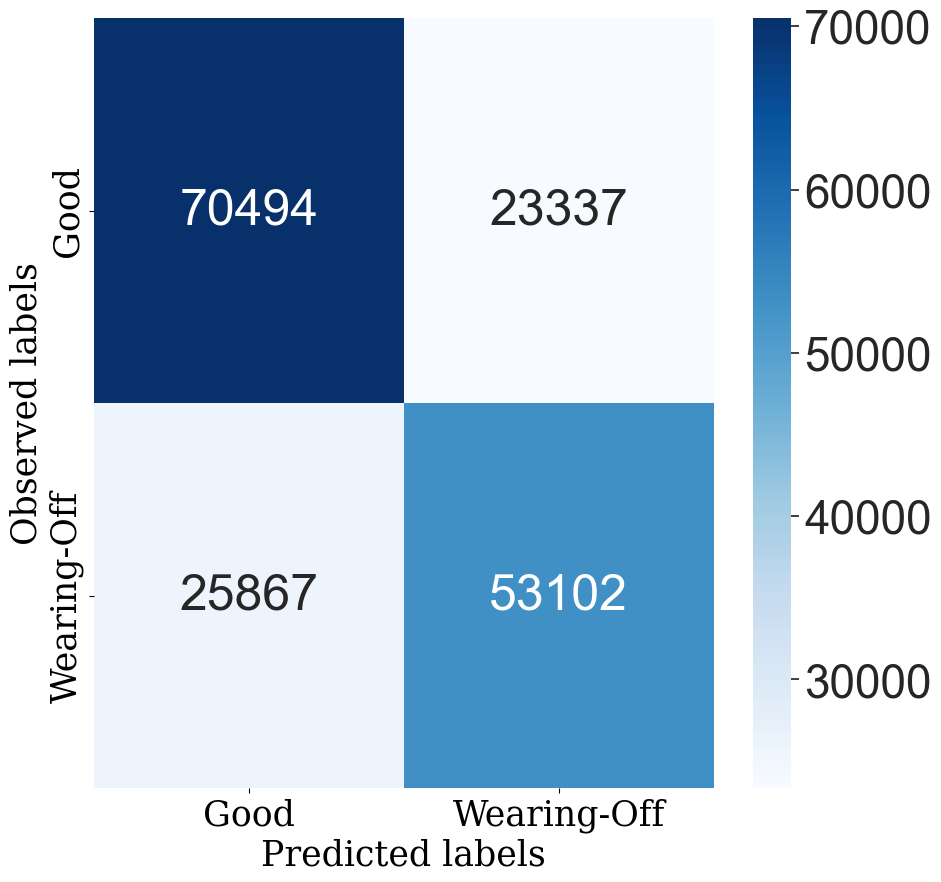


Computing permutation importances. This may take a while.
*****************************************************************************************************
Permutation Importances: Fitting model for outer fold 1
Permutation Importances: Calculating performances for outer fold 1


AttributeError: 'PhotonPipeline' object has no attribute 'classes_'

In [ ]:
final_pipeline1 = Hyperpipe('5 - Final Pipeline CI GB',
                    outer_cv = StratifiedKFold(n_splits=5, shuffle=False),
                    inner_cv = StratifiedKFold(n_splits=3, shuffle=False),
                    use_test_set = True,
                    metrics = list(metrics.keys()),
                    best_config_metric='balanced_accuracy',
                    optimizer='sk_opt',
                    optimizer_params={'n_configurations': 30},
                    project_folder=f'./analysis/{dataset_type}{user}_{frequency}',
                    cache_folder=f'./cache/{dataset_type}{user}_{frequency}/',
                    verbosity=1,
                    performance_constraints=[MinimumPerformanceConstraint('balanced_accuracy', 0.75, 'mean')])

tested_methods = Categorical(['RandomUnderSampler', 'RandomOverSampler', 'SMOTE', 'BorderlineSMOTE'])
final_pipeline1 += PipelineElement('ImbalancedDataTransformer',
                           hyperparameters={ 'method_name': tested_methods })

final_pipeline1 += PipelineElement('GradientBoostingClassifier', 
                            hyperparameters={
                                'loss': ['deviance', 'exponential'],
                                'learning_rate': FloatRange(0.001, 1, 'logspace')
                            }, random_state=4)

# Fit hyperpipe
final_pipeline1.fit(X, y)

# Show learning algorithms mean validation results
# print("Comparison on learning algorithms on validation set")
# print(final_pipeline1.results_handler.get_mean_of_best_validation_configs_per_estimator())

# # Show feature importances
# print_feature_importances(final_pipeline1)

# # View CV splits for debugging
# for k,v in final_pipeline1.cross_validation.outer_folds.items():
#     print(v.train_indices)
#     print(v.test_indices)
#     print(len(v.train_indices), len(v.test_indices))
#     print()

# Write other reports to summary file
add_other_report_to_summary(final_pipeline1, with_estimator_comparison=False)

# Show confusion matrix
plot_confusion_matrix_from_pipeline(final_pipeline1)


In [51]:
# Alternative 1: Built-in Feature Importances (Fastest)
print("Method 1: Built-in GradientBoosting Feature Importances")
print("-" * 55)
try:
    # Get the trained estimator
    gb_estimator = final_pipeline1.optimum_pipe.named_steps['GradientBoostingClassifier']
    
    if hasattr(gb_estimator, 'feature_importances_'):
        importances = gb_estimator.feature_importances_
        feature_names = np.array(columns[1:-1])
        
        # Sort by importance
        indices = np.argsort(importances)[::-1]
        
        for i, idx in enumerate(indices):
            print(f"{feature_names[idx]:<20} {importances[idx]:.4f}")
    else:
        print("Built-in feature importances not available")
        
except Exception as e:
    print(f"Error: {e}")

print("\n" + "="*60 + "\n")


Method 1: Built-in GradientBoosting Feature Importances
-------------------------------------------------------
time_from_last_drug_taken 0.7006
stress_score         0.1400
heart_rate           0.0865
total                0.0288
steps                0.0256
awake                0.0128
light                0.0031
rem                  0.0015
nonrem_total         0.0012
sleep_efficiency     0.0000
nonrem_percentage    0.0000
deep                 0.0000




In [ ]:
# Alternative 2: Using sklearn's permutation_importance directly
print("Method 2: Sklearn Permutation Importance")
print("-" * 40)
try:
    from sklearn.inspection import permutation_importance
    
    # Get the fitted pipeline
    fitted_pipeline = final_pipeline1.optimum_pipe
    
    # Use a subset of data for faster computation (optional)
    # X_sample = X.sample(n=min(1000, len(X)), random_state=42)
    # y_sample = y.loc[X_sample.index]
    
    # Calculate permutation importance
    perm_importance = permutation_importance(
        fitted_pipeline, X, y, 
        n_repeats=10,  # Reduced for speed
        random_state=42,
        scoring='balanced_accuracy'
    )
    
    feature_names = np.array(columns[1:-1])
    
    # Sort by importance
    indices = np.argsort(perm_importance.importances_mean)[::-1]
    
    for i, idx in enumerate(indices):
        print(f"{feature_names[idx]:<20} {perm_importance.importances_mean[idx]:.4f} "
              f"±{perm_importance.importances_std[idx]:.4f}")
        
except Exception as e:
    print(f"Error: {e}")

print("\n" + "="*60 + "\n")




[2] Computing Permutation Importance (sklearn)...
------------------------------------------------------------
❌ Failed to compute permutation importance: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices

Troubleshooting Tips:
- Verify model is trained (final_pipeline1.best_score exists)
- Check X and y have matching indices
- Try reducing sample_size further

Debug Info:
Best score: N/A
Model type: <class 'NoneType'>
X shape: (172800, 12), y shape: (172800,)


In [60]:
# Alternative 3: SHAP Values (if you have shap installed)
print("Method 3: SHAP Feature Importance")
print("-" * 35)
try:
    import shap
    
    # Get the fitted pipeline
    fitted_pipeline = final_pipeline1.optimum_pipe
    
    # Use a sample for SHAP (it can be slow on large datasets)
    X_sample = X.sample(n=min(500, len(X)), random_state=42)
    
    # Create explainer
    explainer = shap.Explainer(fitted_pipeline, X_sample)
    shap_values = explainer(X_sample)
    
    # Get mean absolute SHAP values as feature importance
    feature_importance = np.abs(shap_values.values).mean(0)
    feature_names = np.array(columns[1:-1])
    
    # Sort by importance
    indices = np.argsort(feature_importance)[::-1]
    
    for i, idx in enumerate(indices):
        print(f"{feature_names[idx]:<20} {feature_importance[idx]:.4f}")
        
except ImportError:
    print("SHAP not installed. Install with: pip install shap")
except Exception as e:
    print(f"Error: {e}")

print("\n" + "="*60 + "\n")



Method 3: SHAP Feature Importance
-----------------------------------
SHAP not installed. Install with: pip install shap




In [61]:
# Alternative 4: Simple DataFrame approach for better visualization
print("Method 4: DataFrame Summary")
print("-" * 25)
try:
    import pandas as pd
    
    # Using the original hyperpipe method but organizing results better
    r = final_pipeline1.get_permutation_feature_importances(
        n_repeats=20,  # Reduced for speed
        random_state=0, 
        scoring='balanced_accuracy'
    )
    
    # Create DataFrame for better organization
    importance_df = pd.DataFrame({
        'Feature': np.array(columns[1:-1]),
        'Importance': r["mean"],
        'Std_Dev': r["std"],
        'Lower_Bound': r["mean"] - 2 * r["std"],
        'Upper_Bound': r["mean"] + 2 * r["std"]
    })
    
    # Sort by importance
    importance_df = importance_df.sort_values('Importance', ascending=False)
    
    # Display top 10
    print("Top 10 Most Important Features:")
    print(importance_df.head(10).to_string(index=False, float_format='%.4f'))
    
    # Show only statistically significant features
    significant_features = importance_df[importance_df['Lower_Bound'] > 0]
    
    if len(significant_features) > 0:
        print(f"\nStatistically Significant Features ({len(significant_features)}):")
        print(significant_features.to_string(index=False, float_format='%.4f'))
    else:
        print("\nNo statistically significant features found")
        
except Exception as e:
    print(f"Error: {e}")

print("\n" + "="*60 + "\n")



Method 4: DataFrame Summary
-------------------------

Computing permutation importances. This may take a while.
*****************************************************************************************************
Permutation Importances: Fitting model for outer fold 1
Permutation Importances: Calculating performances for outer fold 1
Error: 'PhotonPipeline' object has no attribute 'classes_'




In [62]:
# Alternative 5: Quick and Simple (Minimal Code)
print("Method 5: Quick and Simple")
print("-" * 25)
try:
    # Just get the built-in importances with minimal code
    estimator = final_pipeline1.optimum_pipe.named_steps['GradientBoostingClassifier']
    importances = estimator.feature_importances_
    features = np.array(columns[1:-1])
    
    # Create sorted list of (importance, feature) tuples
    sorted_features = sorted(zip(importances, features), reverse=True)
    
    print("Feature Importance Ranking:")
    for i, (importance, feature) in enumerate(sorted_features[:15], 1):
        print(f"{i:2d}. {feature:<20} {importance:.4f}")
        
except Exception as e:
    print(f"Error: {e}")

Method 5: Quick and Simple
-------------------------
Feature Importance Ranking:
 1. time_from_last_drug_taken 0.6997
 2. stress_score         0.1331
 3. heart_rate           0.0932
 4. total                0.0278
 5. steps                0.0271
 6. awake                0.0153
 7. light                0.0023
 8. rem                  0.0009
 9. nonrem_total         0.0006
10. sleep_efficiency     0.0000
11. nonrem_percentage    0.0000
12. deep                 0.0000
